In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, subprocess, sys, json, glob
#from molmod import *
#from molmod.io import FCHKFile
#from molmod.io.xyz import XYZReader, XYZFile
import requests
#import wts
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [3]:
plots = "plots_eng/"
plots="/home/hagen/Masterarbeit/Verteidigung/plots/"

In [4]:
plotab = f'{plots}tables/'

In [5]:
plotab

'/home/hagen/Masterarbeit/Verteidigung/plots/tables/'

In [6]:
HH = "*_His/His"
CHM = "C_His/Met"
CHM = "C_Met/His"
BHIS = "B_-/His"

In [7]:
ud = ["ud ","uu ","du ", "dd "]

In [8]:
Propionate = "conformation of Propionate side chains"


In [9]:
redox = "$E_{red}^{exp}$ [mV]" #  "$E_{Red} [mV]$"
redox_calc = "$E_{red}^{calc}$ [eV]" #  "$E_{Red} [mV]$"
dihedruf = "dihedral angle ruffling"
dihedsad = "dihedral angle saddling"
dihedruf = "dihedral angle ruffling [°]"
dihedsad = "dihedral angle saddling [°]"

dihedruf = "$ ruffling$ $[°]$"
dihedsad = "$ saddling$ $[°]$"
edif = "Difference $E_{Ox}$ $E_{Red}$"


Colorbar ={HH:"magenta",BHIS:"cyan",CHM:"orange","other":"grey"}
Colorbar ={HH:"red",BHIS:"blue",CHM:"orange","other":(0,0,0)}

Energie = " [eV]"

sighnbar ={HH:"^",BHIS:"o",CHM:"--","other":"o"}
redox

'$E_{red}^{exp}$ [mV]'

In [10]:
cmap1 = "inferno"

In [11]:
plots

'/home/hagen/Masterarbeit/Verteidigung/plots/'

In [12]:
if 'df_work2' in globals():
    df_work2[[i for i in df_work2.columns if "homo" in i or "lumo" in i ]+["Em_lit"]].to_csv("tables/homo_lumo_lit.csv")
    

# Helpers

In [13]:
def objecthash(df, col1, col2):
    dfb = pd.DataFrame({col2:df[col2].value_counts().index})
    for c1 in df[col1].value_counts().index:
        ls = []
        for c2 in df[col2].value_counts().index:
            try:
               # print(c1,c2,df.groupby([col1,col2]).size().loc[c1].loc[c2])
                ls.append(df.groupby([col1,col2]).size().loc[c1].loc[c2])
            except:
                #print(c1,c2,0)
                ls.append(0)
        dfb[c1] = ls
    
    dfb = dfb.set_index(col2)
    return dfb
            

In [14]:
def hashmap(dflg,col1,col2):
    #sns.set (rc = {'figure.figsize':(8, 5)})
    ax = sns.heatmap(objecthash(dflg,col1,col2),linewidths=0.5,annot= True)#,yticklabels=1)
    #ax = sns.heatmap(objecthash(dflg,col1,col2),annot= True)#,yticklabels=1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    #sns.set(font_scale=200)
    ax.set_xlabel(col1)
    
    return ax

In [15]:
def blindserie(columns,spin,met,pdb):
    ser={}
 #   spin= 5
  #  met = "nbo"
   # pdb = "1CCC"
    for c in columns:
        if c ==  "spin":
            ser[c] = [spin]
        elif c ==  "Ox":
            ser[c] = {1:[0],2:[1],5:[0],6:[1]}[spin]
        elif c == "method":
            ser[c] = [met]
        else:
            ser[c] = [None]
    return pd.DataFrame(ser,index=[pdb])

In [16]:
def dfkat(df,kat,**kwargs):
    defcolname="Kategorie"
    colname = kwargs.pop('column', defcolname)
    defboolean = True
    boolean = kwargs.pop("inlist", defboolean)
    if boolean:
        return df[[kat in i for i in df[colname]]]
    else:
        return df[[not kat in i for i in df[colname]]]

In [17]:
#c : "red", "marker" :  "D", "facecolor" :"none", "edgecolor" : "black" ,"s" : 2


scatterdict = {HH:{"c" : "magenta", "marker" :  "D", "zorder":3, "s":10},
           BHIS:{"c":"cyan", "marker" :  "D", "zorder":3, "s":9},
           CHM:{"c":"orange", "marker" :  "D", "zorder":3, "s":9},
           "other":{"c":(0,0,0),"marker":"D","s":20}}

sio = 20
sil = 10
scatterdict = {HH:{"c" : "magenta", "marker" :  "D", "zorder":3, "s":sil},
           BHIS:{"c":"cyan", "marker" :  "D", "zorder":3, "s":sil},
           CHM:{"c":"orange", "marker" :  "D", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"D","s":sio}}

sio = 30
sil = 30
scatterdict2 = {HH:{"c" : "magenta", "marker" :  "D", "zorder":3, "s":sil},
           BHIS:{"c":"cyan", "marker" :  "D", "zorder":3, "s":sil},
           CHM:{"c":"orange", "marker" :  "D", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"D","s":sio}}


scatterdict = {HH:{"c" : "#e34234", "marker" :  "d", "zorder":3, "s":sil},
           BHIS:{"c":"cyan", "marker" :  "+", "zorder":3, "s":sil},
           CHM:{"c":"yellow", "marker" :  "v", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"o","s":sio}}
scatterdict = {HH:{"facecolor" : "#e34234","edgecolor":"black", "marker" :  "D", "zorder":3, "s":sil},
           BHIS:{"facecolor":"cyan","edgecolor":"black", "marker" :  "d", "zorder":3, "s":sil},
           CHM:{"facecolor":"yellow","edgecolor":"black", "marker" :  "v", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"o","s":sio}}

Colorbarheme = ("black","red","green")
Colorbar = {} 
for k in scatterdict.keys():
    try:
        Colorbar[k] = scatterdict[k]["c"]
    except:
        Colorbar[k] = scatterdict[k]["facecolor"]
    
    
def scatterkat(dfg,x,y, katlist, dictionary = scatterdict):
    df = dfg
    f  = plt.scatter(df[x],df[y], **dictionary["other"],label="all")
    for kat in katlist:
        df = dfg[dfg["Kategorie2"] ==kat]
        plt.scatter(df[x],df[y], **dictionary[kat],label=kat)
    df = dfg
    
    return f

    
def scatterkat(dfg,x,y, katlist, dictionary = scatterdict):
    df = dfg
    #f  = plt.scatter(df[x],df[y], **dictionary["other"],label="all")
    abc = [i for i in df["Kategorie2"].value_counts().index if i not in katlist]
    df["Kategorie3"]  = ["other" if i in abc else i for i in df["Kategorie2"]]
    
    for kat in katlist+["other"]:
        df = dfg[dfg["Kategorie3"] ==kat]
        plt.scatter(df[x],df[y], **dictionary[kat],label=kat)
    df = dfg
    
    return f
fig = plt.figure(dpi = 150)#,figsize=(10,3))

if 'df_work2' in globals():
    scatterkat(df_work2,"diff_2_nbo","Em_lit",Kategorie)
    plt.legend()
    plt.ylabel(redox)
    fig.legend()


<Figure size 900x600 with 0 Axes>

In [18]:
HH

'*_His/His'

In [19]:
def string1(str1):
    str1 =str1.replace(HH,"HisHis")
    str1 =str1.replace(CHM,"C\_MH")
    str1 = str1.replace(BHIS,"B\_His")
    str1 =str1.replace("chem_pot","chempot")
    str1 =str1.replace("Em_lit","Em")

    str1 =str1.replace("_nbo","}")
    
    str1 = str1.replace("_","_{")
    str1 =str1.replace("chempot","chem pot")    
    return f"${str1}$"

In [20]:
def string2(str1):
    if "edif" in str1:
        ff = str1
        return f"$edif$ {str(ff[-4])}-{str(ff[-2])}"
    if BHIS in str1 or CHM in str1 or HH in str1:
        str1 =str1.replace(HH,"HisHis")
        str1 =str1.replace(CHM,"C\_MH")
        str1 = str1.replace(BHIS,"B\_His")
    return f"${str1}$"
    str1 =str1.replace("chem_pot","chempot")
    str1 =str1.replace("Em_lit","Em")

    str1 =str1.replace("_nbo","}")
    
    str1 = str1.replace("_","_{")
    str1 =str1.replace("chempot","chem pot")    
    return f"${str1}$"



In [21]:
string1(BHIS)

'$B\\_{His$'

In [22]:
def pca_show(df_work2, **kwargs):
    """num_comp = number of components default 6"""    
    default_value_n_components=6
    num_of_componentes = kwargs.pop('num_comp', default_value_n_components) 
    if num_of_componentes>df_work2.shape[1]:
        num_of_componentes=df_work2.shape[1]
        
    
    
    best_n=3
    best_par = kwargs.pop('best_par', default_value_n_components)     
    if best_par> num_of_componentes:
        best_par== num_of_componentes
        
    default_value_whiten = False
    whiten_ = kwargs.pop('whiten', default_value_whiten)
    
    df_work2 = df_work2[[n for n in df_work2.columns if not n in [i for i in df_work2.dtypes[df_work2.dtypes==object].index]]]

    X = df_work2.values
    s = StandardScaler()
    X = s.fit_transform(X)
    p = PCA(n_components = num_of_componentes, whiten = whiten_)
    p.fit(X)
    X_transformed = p.transform(X)
    X_transformed_filtered = X_transformed
    
    print("noise variance: ",p.noise_variance_)
    print( "number of componentes: ", num_of_componentes) 
    print((p.explained_variance_ratio_[:]))
    
    cols = list(df_work2.columns)
    df =  pd.DataFrame(p.components_,columns = cols)
    df["variance_ratio"] = p.explained_variance_ratio_[:]
    return df 

In [23]:
def best_components(df, **kwargs):
        
    default_value_n_components=6
    num_of_componentes = kwargs.pop('num_comp', default_value_n_components) 
    
    default_value_min_Em_lit = 0.1
    min_Em_lit = kwargs.pop('min_Em_lit', default_value_min_Em_lit)

    default_value_min_PC = 0.15
    min_PC = kwargs.pop('min_PC', default_value_min_PC)
    
    
    
    df  =pca_show(df,num_comp=num_of_componentes, whiten = True) #,num_comp=32)
    df_abs = df.abs()

    bo = df[df_abs["Em_lit"]> min_Em_lit ].index

    list_of_df = []

    for b in bo:

        numname = [(np.round(v,4),i) for i,v in zip(df.loc[b].index,df.loc[b]) if abs(v)>min_PC]
        names = [i[1] for i in numname] 
        nums = [i[0] for i in numname] 
        list_of_df.append(pd.DataFrame({df.loc[b]["Em_lit"]:nums}, index= names))

    if len(list_of_df)>1:
        a = []
        for i in list_of_df:
            a = a+ list( i.index)
        a = list(set(a))


        list_of_best = [i for i in a if all([i in j.index for j in list_of_df]) ]
        Matrix = [[ld.loc[[lb]].iloc[0,0] for ld in list_of_df] for lb in list_of_best]
        #print(Matrix, list_of_df)
        df_bo = pd.DataFrame(Matrix, index = list_of_best, columns = [(df.loc[b]["Em_lit"]) for b in bo])
        df_bo["mean"] = df_bo.mean(axis = 1)
        list_of_df.append( df_bo)
        return list_of_df

In [24]:
def pca_col(df,col, **kwargs):
    """ num_comp = 6"""
    default_value_n_components=6
    num_of_componentes = kwargs.pop('num_comp', default_value_n_components)     
    
    
    df = pca_show(df,num_comp = num_of_componentes)

    "variance_ratio" in df.columns
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)
    
    bo = df[col].abs().nlargest(2).index
    
    #df_abs = df.abs()
    #bo = df[df_abs[col]> col_min ].index
    
    dff= {}

    for i,b in enumerate(bo):
        dff[i]={col:np.round(df.loc[b][col],4)}
        
        
        serie = df.loc[b][[i for i in df.columns if i != col]].abs().nlargest(2)
        vals = list(serie)
        ind = serie.index
        dff[i]["df"]=pd.DataFrame({i:vals},index=ind)
        dff[i]["variance_ratio"] = variance_ratio.loc[b]
        dff[i]["HK"]=b
    return dff




In [25]:
if 'dfpca1' in globals():

    di = pca_col(dfpca1,"Em_lit")
    di[1]["df"]

In [26]:
if 'dfpca1' in globals():
    import pprint
    d = pca_col(dfpca1,"ruffling")
    pprint.pprint(d)

In [27]:
try:
    fig = plt.figure(dpi = 150)
    plt.scatter(dfpca1["diff_1_nbo"],dfpca1["elekphil_1_nbo"],c= dfpca1["ruffling"],vmax= 20)
    plt.colorbar()
except:
    2

<Figure size 900x600 with 0 Axes>

# Tabellen

In [28]:
dflg = pd.read_csv("tables/df_dih_lit.csv")
#dflg = pd.read_csv("/home/hagen/Schreibtisch/df_lit.csv")

In [29]:
dflg = dflg.set_index("pdb")
dflg["PDB"] = dflg.index

In [30]:
df_work2 = pd.read_csv("tables/df_calc_dih_lit.csv")


In [31]:
df_work2 = df_work2.set_index("PDB")
df_work2["PDB"] = df_work2.index

#df_work22 = df_work22.set_index("PDB")
#df_work22["PDB"] = df_work22.index

In [32]:
'''for i in df_work22.index:
    if not i in df_work2.index:
        print(i)
        
print("____________")        
for i in df_work2.index:
    if not i in df_work22.index:
        print(i)'''

'for i in df_work22.index:\n    if not i in df_work2.index:\n        print(i)\n        \nprint("____________")        \nfor i in df_work2.index:\n    if not i in df_work22.index:\n        print(i)'

In [33]:
'''for a in df_work22.columns:
    if a not in df_work2.columns :
        print(a)
        
print("_______________")        
for a in df_work2.columns:
    if a not in df_work22.columns :
        print(a)      '''  

'for a in df_work22.columns:\n    if a not in df_work2.columns :\n        print(a)\n        \nprint("_______________")        \nfor a in df_work2.columns:\n    if a not in df_work22.columns :\n        print(a)      '

In [34]:
'''for i in [i  for i in df_work2.columns if "_nbo" in i]:
    try:
        df_work2[i] = df_work22[i]
    except:
        print(i)'''
    

'for i in [i  for i in df_work2.columns if "_nbo" in i]:\n    try:\n        df_work2[i] = df_work22[i]\n    except:\n        print(i)'

In [35]:
dflg["Kategorie2"] = [i if i !="andere" else "other" for i in dflg["Kategorie2"]]
dflg["ax_ql_r"] = [i if i !="andere" else "other" for i in dflg["ax_ql_r"]]
dflg["ax_qn_r"] = [i if i !="andere" else "other" for i in dflg["ax_qn_r"]]

df_work2["Kategorie2"] = [i if i !="andere" else "other" for i in df_work2["Kategorie2"]]

In [36]:
Kategorie = list(dflg["Kategorie2"].value_counts().index)

Kategorie.remove("other")

In [37]:
Kategorie = list(dflg["Kategorie2"].value_counts().index)
Kategorie.remove("other")
Kategorie


['C_Met/His', 'B_-/His', '*_His/His']

# literaturwerte allein ohne QM

In [38]:
dflg["Kategorie"].value_counts()

['C_Met/His']    27
[]               22
['B_-/His']      12
['*_His/His']     9
Name: Kategorie, dtype: int64

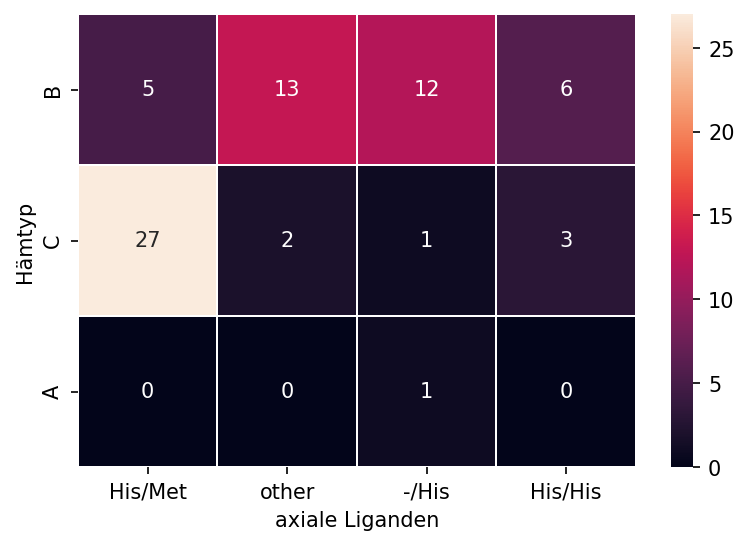

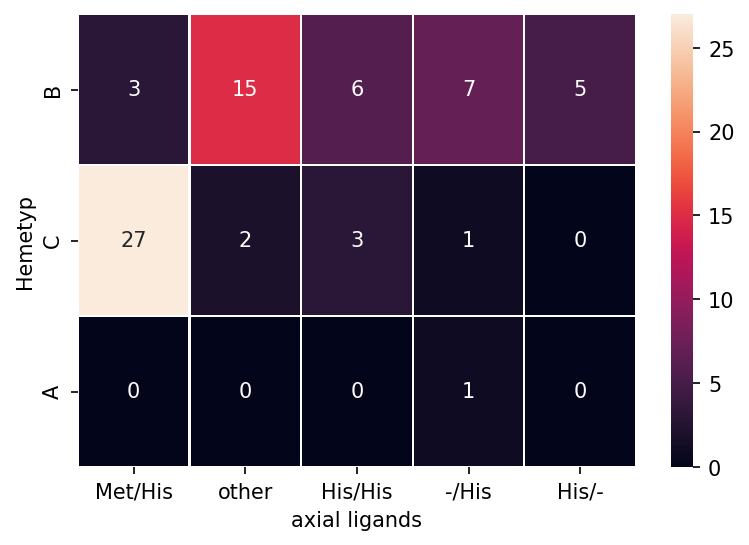

In [39]:
df =dflg.copy()
df["Hämtyp"] = df["Hemetyp"]
fig = plt.figure(dpi=150)
#f = hashmap(dflg, "ax_ql_r","Hemetyp")
df["axiale Liganden"] = df["ax_ql_r"]

f = hashmap(df, "axiale Liganden","Hämtyp")

type(f)
fig.savefig(f"{plots}Heme_ax_ql.png")

fig = plt.figure(dpi=150)
df["axial ligands"] = df["ax_qn_r"]
f = hashmap(df, "axial ligands","Hemetyp")
type(f)
fig.savefig(f"{plots}Heme_ax_qn.png")

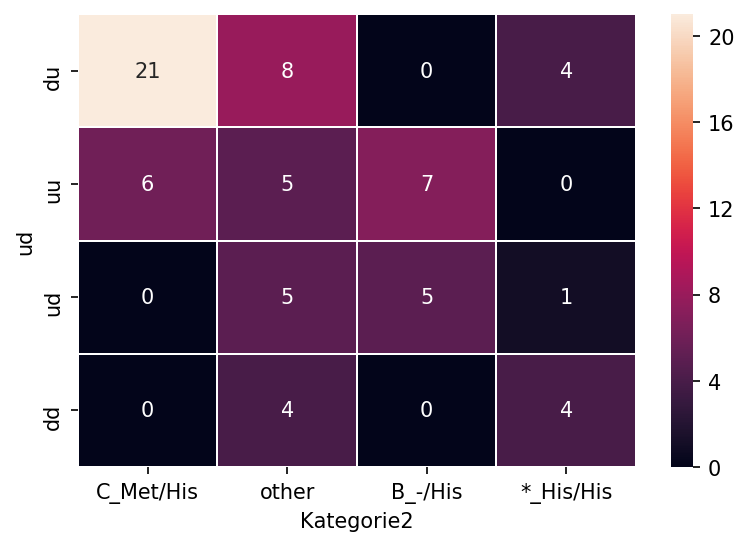

In [40]:
fig = plt.figure(dpi=150)
f = hashmap(dflg, "Kategorie2","ud")

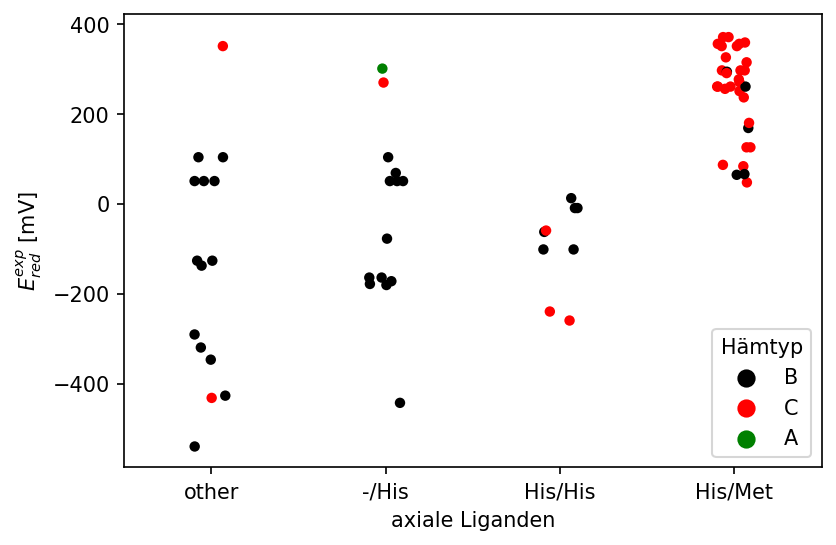

In [41]:
#Colorbarheme = ("black","red","green")
plt.figure(dpi=150)
df = dflg
df["axiale Liganden"] =df["ax_ql_r"]
df[redox]  =df["Em_lit"]
df["Hämtyp"] = df["Hemetyp"]
#fig = sns.stripplot(data =dflg, x = "ax_ql_r",hue = "Hemetyp", y = "Em_lit",palette=Colorbarheme)
fig = sns.stripplot(data =df, x = "axiale Liganden",hue = "Hämtyp", y = redox,palette=Colorbarheme)
fig.figure.savefig(f"{plots}Liganden1.png")

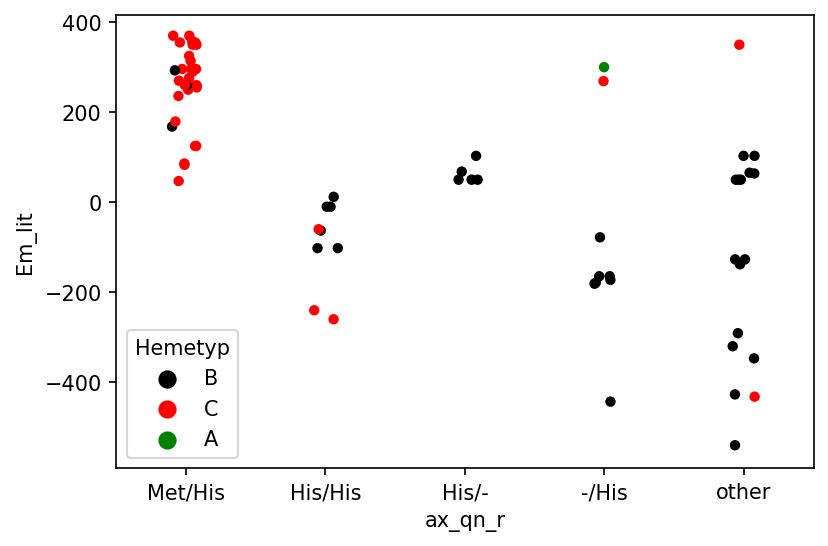

In [42]:
#Colorbarheme = ("black","red","green")
plt.figure(dpi=150)
order=  ["Met/His", "His/His","His/-", "-/His","other"]
fig = sns.stripplot(data =dflg, x = "ax_qn_r",hue = "Hemetyp", y = "Em_lit",palette=Colorbarheme, order = order)


#fig.figure.savefig(f"{plots}Liganden1.png")

In [43]:
df  = dflg.copy()
df = df[df["ax_qn_r"]=="-/HIS"]
df = df[df["Em_lit"]<-200]
df["Em_lit"]


Series([], Name: Em_lit, dtype: float64)

In [44]:
df  = dflg.copy()
#df.loc[[i for i in df.index if "PCB" in i]]["Em_lit"]


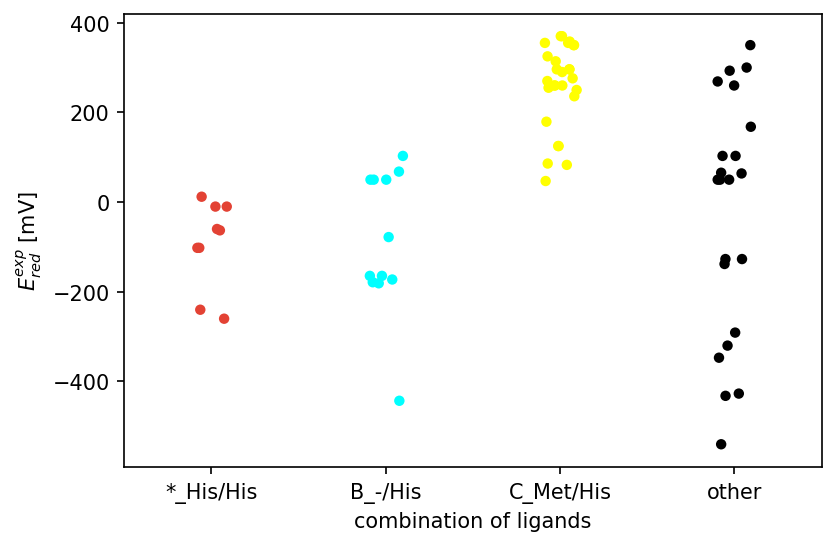

In [45]:
plt.figure(dpi=150)
df = dflg.copy()
df[redox]= df["Em_lit"]
df["combination of ligands"] = df["Kategorie2"]
#fig = sns.stripplot(data =dflg, x = "Kategorie2", order = Colorbar.keys(),y = "Em_lit",palette=Colorbar.values())
fig = sns.stripplot(data =df, x = "combination of ligands", order = Colorbar.keys(),y = redox,palette=Colorbar.values())
fig.figure.savefig(f"{plots}Liganden2.png")

In [46]:
plots

'/home/hagen/Masterarbeit/Verteidigung/plots/'

In [47]:
df = dflg.copy()
df = df[df["ax_qn_r"]=="other"]
dd = df["ax_qn"].value_counts().to_dict()
for k in dd:
    dd[k]=[dd[k]]
dff = pd.DataFrame(dd ,index= ["n"])#.to_csv(f"{plots}tables/others1.csv")    

In [48]:
df = dflg.copy()
#df = df[df["Kategorie2"]=="other"]
df = df[df["ax_qn_r"] == "other"]
dd = df["ax_qn"].value_counts().to_dict()

pd.DataFrame({"n":list(dd.values())}, index = list(dd.keys())).to_csv(f"{plots}tables/others2.csv")  

#dff.to_csv(f"{plots}tables/others2.csv")  

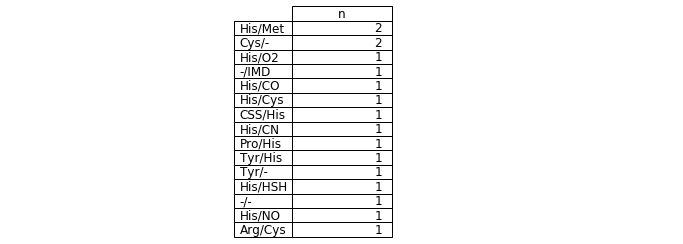

In [49]:
dfother = pd.DataFrame({"n":list(dd.values())}, index = list(dd.keys()))
from pandas.plotting import table

dates = pd.date_range('20130101',periods=6)
df = dfother

#df.index = [item.strftime('%Y-%m-%d') for item in df.index] # Format date

fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, df, loc='center', colWidths=[0.1]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.5, 1.2) # change size table
plt.savefig(f'{plots}tables/table_1.png', transparent=True)

In [50]:
dfother.shape

(15, 1)

# print(f"{plots}tables/others2.csv")  

In [51]:
df = dflg.copy()
#df = df[df["Kategorie2"]=="other"]
df = df[df["ax_qn_r"] == "other"]
df["abc"]= [f"{H}_{ax}" for H,ax in zip(df["Hemetyp"], df["ax_qn"])]
dd = df["abc"].value_counts().to_dict()

#for a,b in df["abc"].value_counts().to_dict()

df2 =df[["Hemetyp","ax_qn","abc"]].set_index("abc")
df2["bc"]=[dd[col] for col in df2.index]

df2 = df2.drop_duplicates()
df3= pd.DataFrame()
df3["Häm"] = df2["Hemetyp"]
df3["ax Lig"] = df2["ax_qn"]
df3["n"] = df2["bc"]
df3 = df3.set_index("Häm")
df3 = df3.sort_index(ascending = False)
df3.to_csv(f"{plots}tables/others2.csv")  
df3
#pd.DataFrame({"n":list(dd.values())},  index = list(dd.keys())).to_csv(f"{plots}tables/others2.csv")  

ax Lig  n
Häm            
C    Tyr/His  1
C    CSS/His  1
B     His/CO  1
B     His/O2  1
B        -/-  1
B      -/IMD  1
B     His/CN  1
B     His/NO  1
B    His/Cys  1
B    His/HSH  1
B    His/Met  2
B      Tyr/-  1
B      Cys/-  2
B    Arg/Cys  1
B    Pro/His  1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Dihed ruffling vs $E_{red}^{exp}$ [mV]


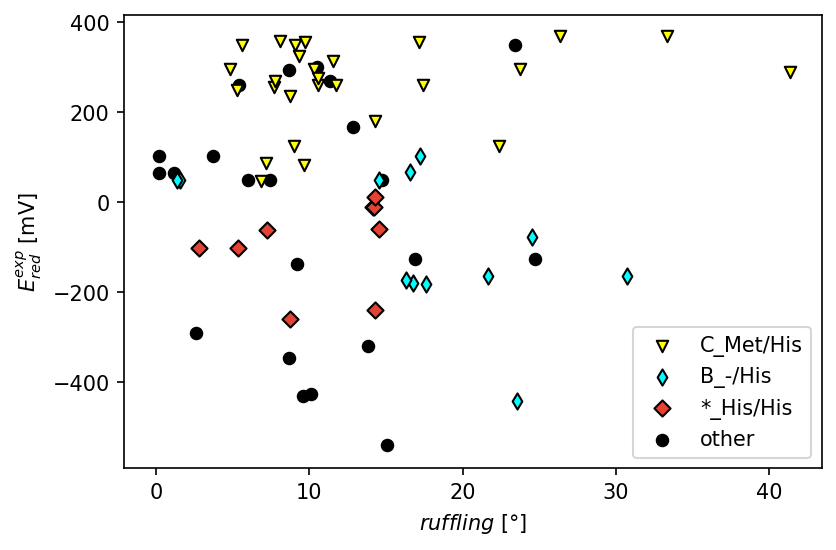

In [52]:
plt.figure(dpi=150)
scatterkat(dflg,"ruffling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedruf)
print(f"Dihed ruffling vs {redox}")
plt.legend()

plt.savefig(f"{plots}ruffling.png")

In [53]:
Kategorie

['C_Met/His', 'B_-/His', '*_His/His']

Dihed ruffling vs $E_{red}^{exp}$ [mV]


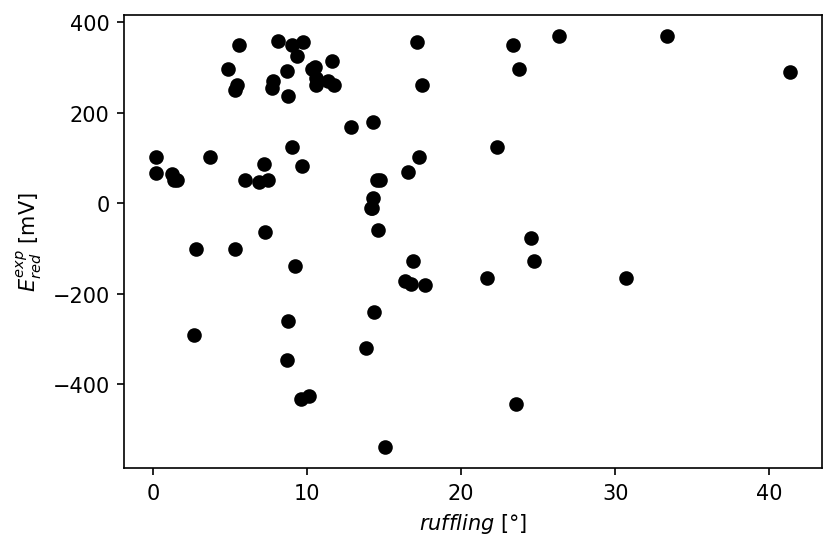

In [54]:
plt.figure(dpi=150)
df = dflg.copy()
plt.scatter(df["ruffling"],df["Em_lit"],c="black")
#scatterkat(dflg,"ruffling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedruf)
print(f"Dihed ruffling vs {redox}")
#plt.legend()
#
plt.savefig(f"{plots}ruffling_black.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Dihed ruffling vs $E_{red}^{exp}$ [mV]


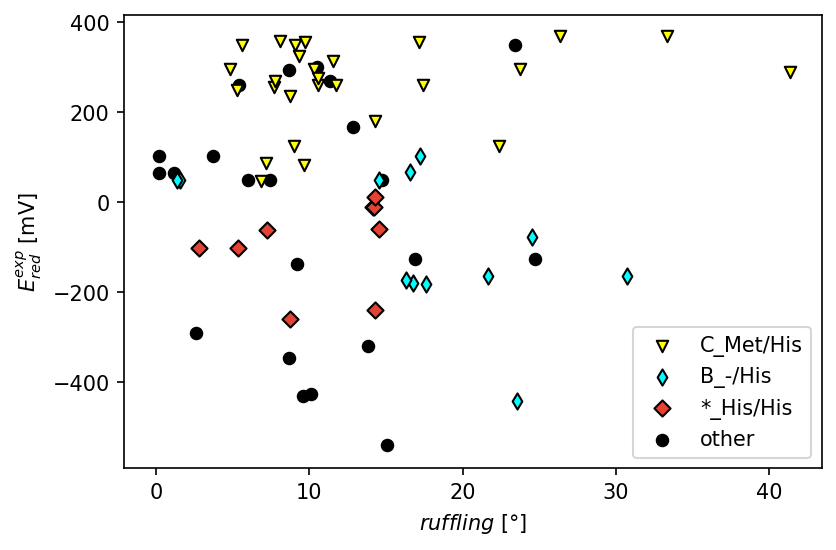

In [55]:
plt.figure(dpi=150)
scatterkat(dflg,"ruffling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedruf)
print(f"Dihed ruffling vs {redox}")
plt.legend()

plt.savefig(f"{plots}ruffling.png")

In [56]:
df = df_work2.copy()
X = df[["ruffling","Em_lit"]]

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

Em_lit vs ruffling


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


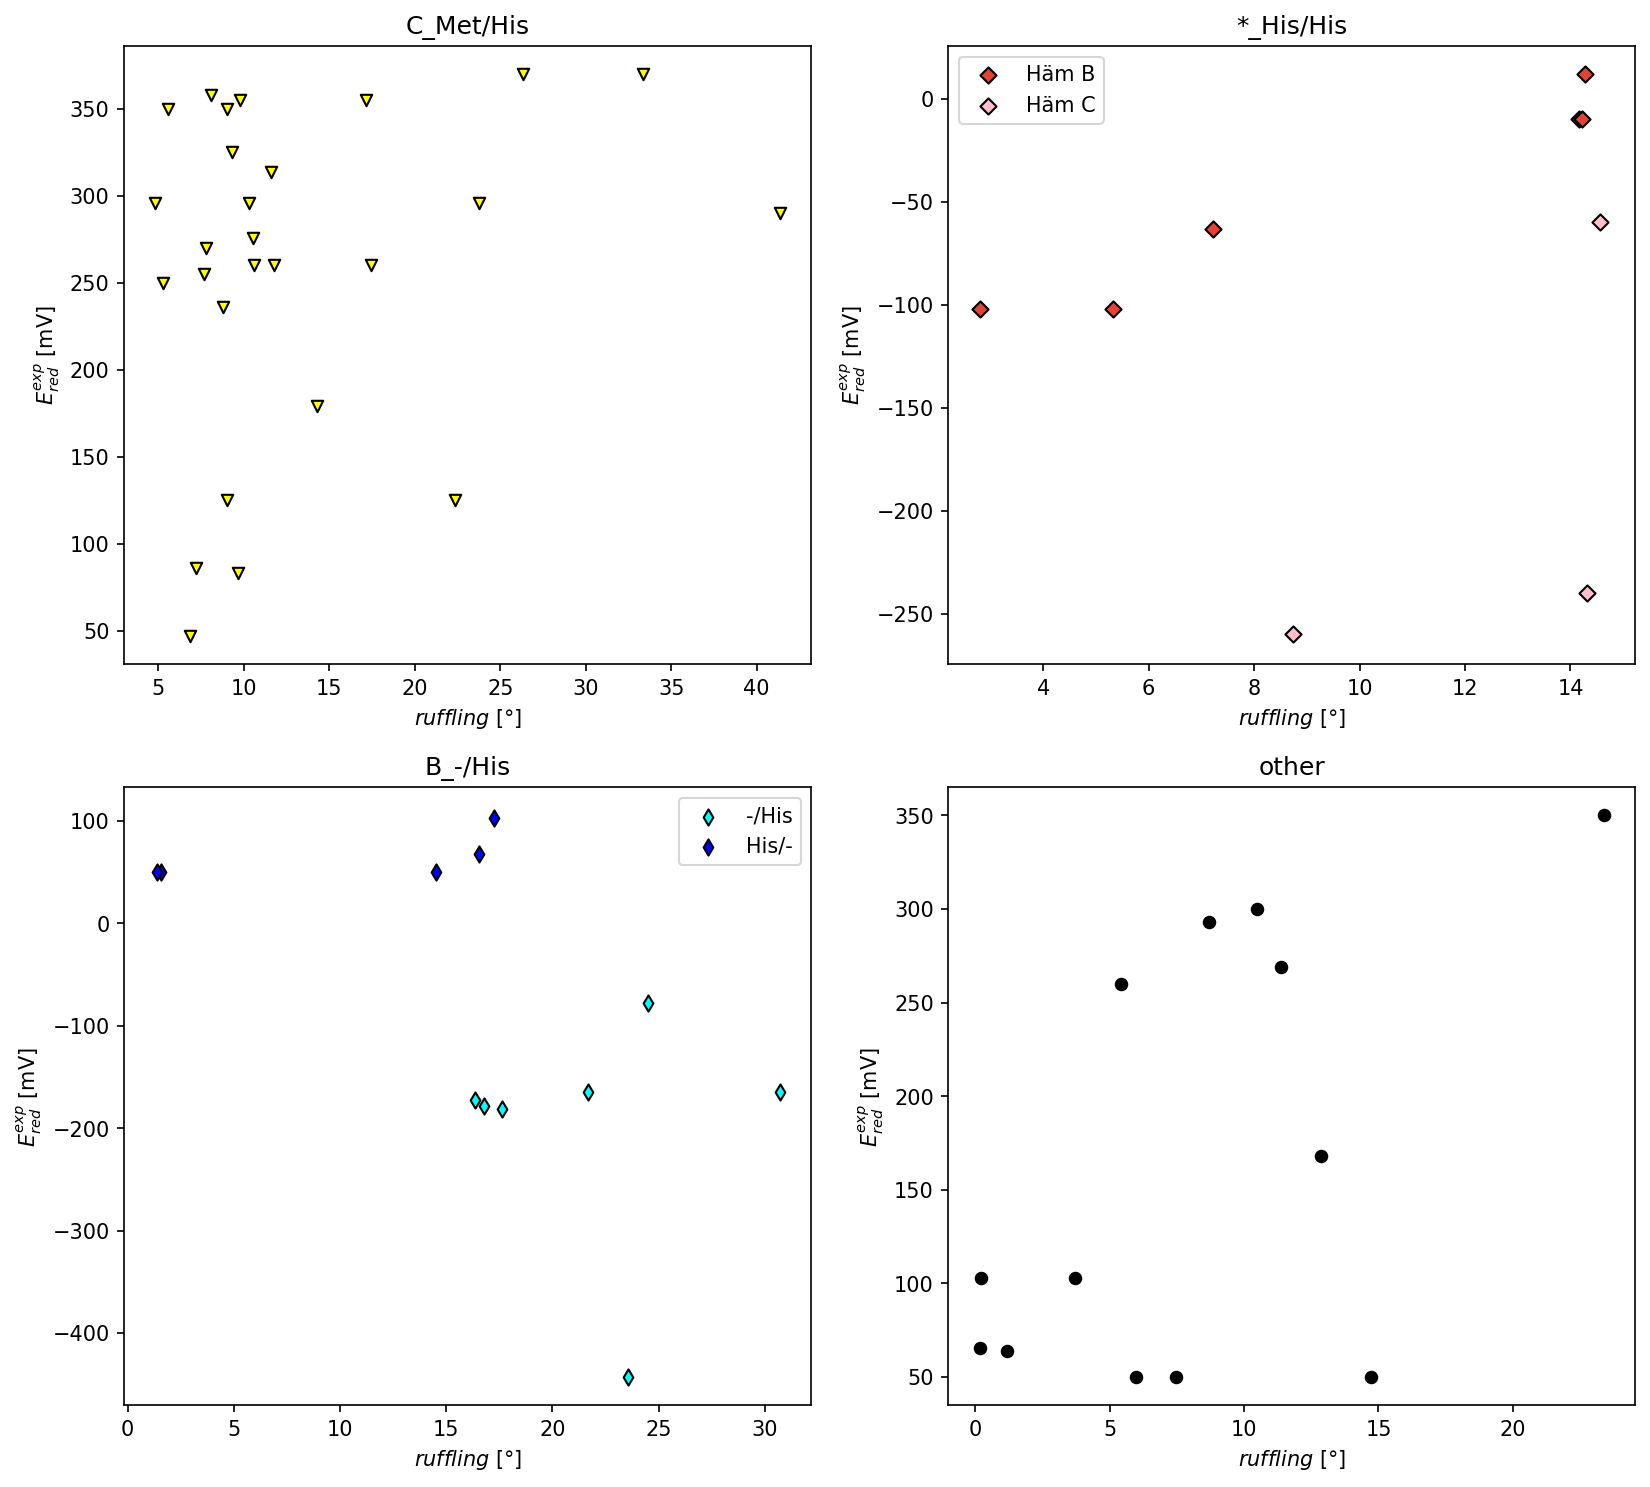

In [59]:
fig = plt.figure(dpi = 150,figsize=[13,12])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]
edif  = "Em_lit"
print(f"{edif} vs ruffling")
#fig.suptitle(f"{edif} vs ruffling",fontsize =16)



model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "orange",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "yellow",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = dflg.copy()
df = df[df["Kategorie2"]==kat]
df = df[df["ruffling"]<30]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "red",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )













df = dflg.copy()
df = df[df["Kategorie2"]==kat]


#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
#plt.scatter(df["ruffling"],df[edif], label = kat,**scatterdict[kat])#,c =df[edif])
plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])#,c =df[edif])

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
#plt.legend()
plt.subplot(222)
kat = HH
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["Hemetyp"].value_counts().index):
    df = df2[df2["Hemetyp"]==a]

    #plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
    plt.scatter(df["ruffling"],df[edif],**scatterdict[kat],label=f"Häm {a}",c={"C":"pink","B":scatterdict[kat]["facecolor"]}[a])

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}")

plt.legend()
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["ligup"].value_counts().index):
    df = df2[df2["ligup"]==a]
    #df = df[df[edif]>0]
    plt.scatter(df["ruffling"],df[edif],**scatterdict[kat],label={"-":"-/His","His" :"His/-"}[a],c={"His":"blue","-":scatterdict[kat]["facecolor"]}[a])

   # plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])
  #  plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])
    #plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat],c={0:scatterdict[kat]["facecolor"],1:"blue"}[a1])

    
    
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
x = np.linspace(14,30)

#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "blue",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )
#plt.legend()


plt.subplot(224)
kat = "other"
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}")
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df = df[df[edif]>0]
plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])#,c =df[edif])
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
fig.savefig(f"{plots}ruffling_2.png")

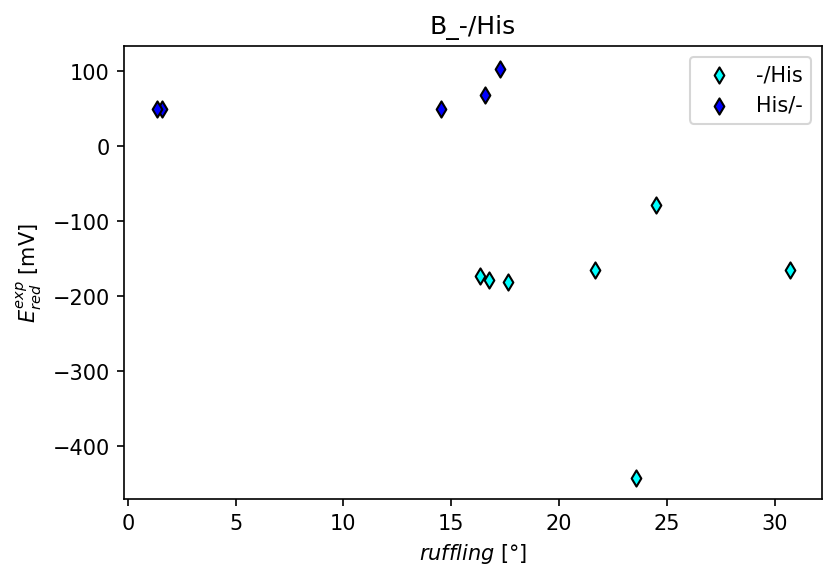

In [60]:
fig = plt.figure(dpi=150)
kat = BHIS
plt.title(kat)
plt.scatter
df = dflg.copy()
df = df[df["Kategorie2"]==kat]
df2 = df.copy()
for a1,a in enumerate (df2["ligup"].value_counts().index):
    df = df2[df2["ligup"]==a]
    plt.scatter(df["ruffling"],df["Em_lit"],**scatterdict[kat],label={"-":"-/His","His" :"His/-"}[a],c={"His":"blue","-":scatterdict[kat]["facecolor"]}[a])
edif = "Difference $E_{Ox}$ $E_{Red}$"
plt.legend()
    
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}")
fig.savefig(f"{plots}ruffling_BHIS.png")


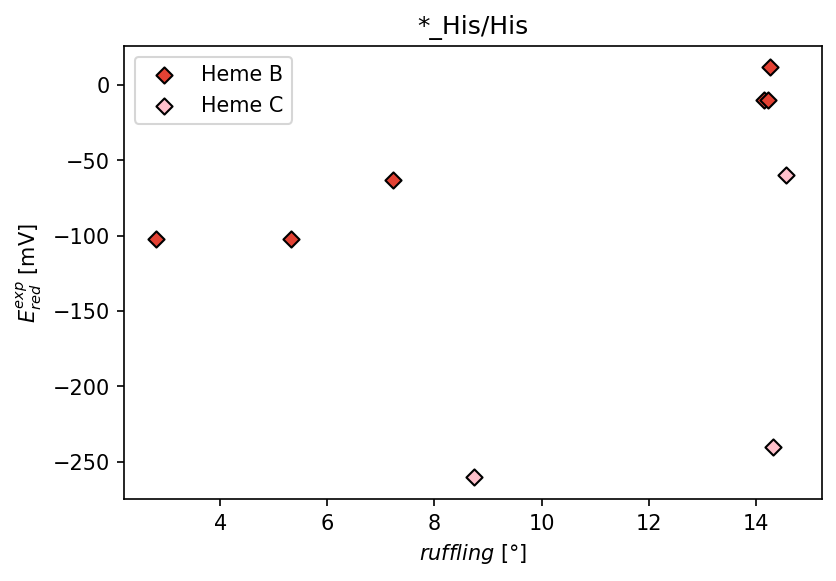

In [61]:
fig = plt.figure(dpi=150)
kat = HH
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["Hemetyp"].value_counts().index):
    df = df2[df2["Hemetyp"]==a]

    #plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
    plt.scatter(df["ruffling"],df["Em_lit"],**scatterdict[kat],label=f"Heme {a}",c={"C":"pink","B":scatterdict[kat]["facecolor"]}[a])

plt.xlabel(dihedruf)
plt.ylabel(redox)

plt.legend()
fig.savefig(f"{plots}ruffling_HH.png")


In [62]:
df =dflg.copy()
df = df[df["ruffling"]<25]
df = df[df["ruffling"]>20]
df = df[df["Kategorie2"]==CHM]
df[["Em_lit","ruffling"]]

Em_lit   ruffling
pdb                    
1CRY   296.0  23.777117
5MCS   125.0  22.346135

In [63]:
model = KMeans(n_clusters = 3)
model.fit(X_transformed)

labels = model.labels_

labels
#plt.scatter(df["ruffling"], df["Em_lit"], c = labels)
#plt.show()

array([2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 0, 2, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 2, 1, 2, 2, 1,
       2, 1, 0, 0, 0, 0], dtype=int32)

Text(0.5, 1.0, 'Heme B')

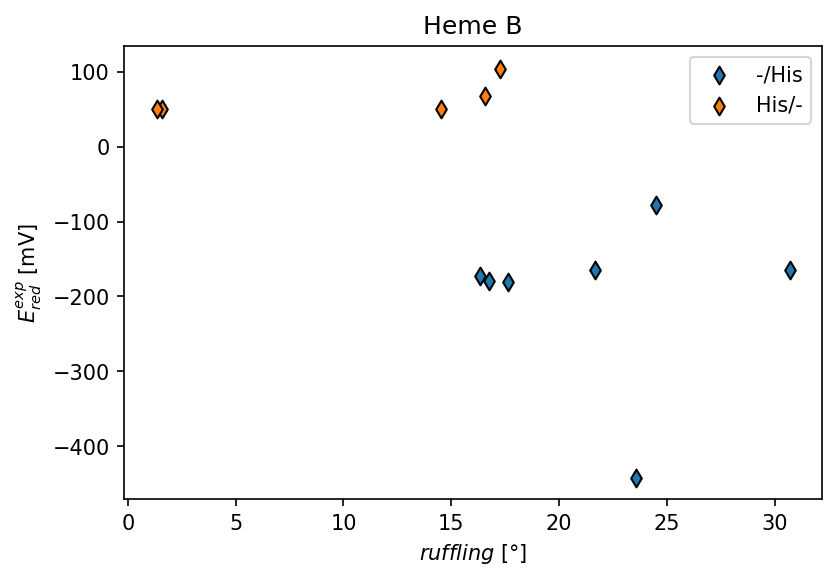

In [64]:
df = dflg.copy()
df = df[df["Kategorie2"]==BHIS]
plt.figure(dpi=150)
from matplotlib.markers import MarkerStyle


for i,c in enumerate (df["ax_qn"].value_counts().index):

    
    
    df2 = df[df["ax_qn"] ==c]
    plt.scatter(df2["ruffling"], df2["Em_lit"],label =c,edgecolor="black", marker = "d")#,c = scatterdict[BHIS]["facecolor"])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(redox)
plt.title("Heme B")
#plt.savefig(f"{plots}ruffling_BHIS.png")

Text(0.5, 1.0, '*_His/His')

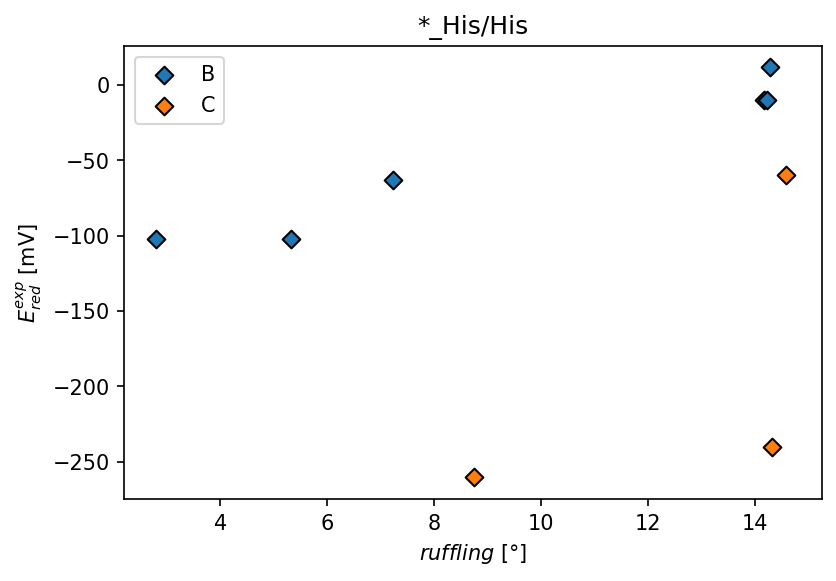

In [65]:
df = dflg.copy()
df = df[df["Kategorie2"]==HH]
plt.figure(dpi=150)
from matplotlib.markers import MarkerStyle


for i,c in enumerate (df["Hemetyp"].value_counts().index):
    m = MarkerStyle("D")
    m._transform.rotate_deg(90*i)
    
    
    df2 = df[df["Hemetyp"] ==c]
    plt.scatter(df2["ruffling"], df2["Em_lit"],label =c,edgecolor="black", marker = m)#,c = scatterdict[BHIS]["facecolor"])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(redox)
plt.title(HH)
#plt.savefig(f"{plots}ruffling_BHIS.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Dihed saddling vs $E_{red}^{exp}$ [mV]


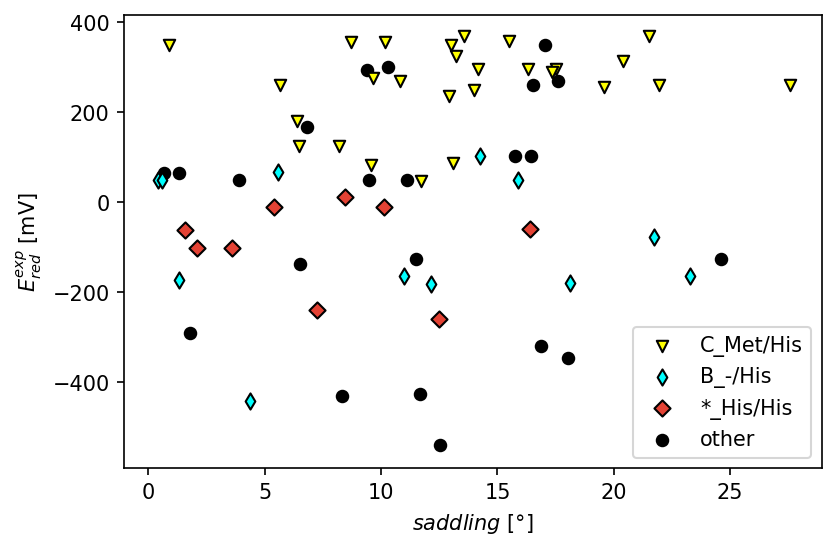

In [66]:

plt.figure(dpi=150)
scatterkat(dflg,"saddling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedsad)
print(f"Dihed saddling vs {redox}")
plt.legend()
plt.savefig(f"{plots}saddling.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Dihed ruffling vs $E_{red}^{exp}$ [mV]


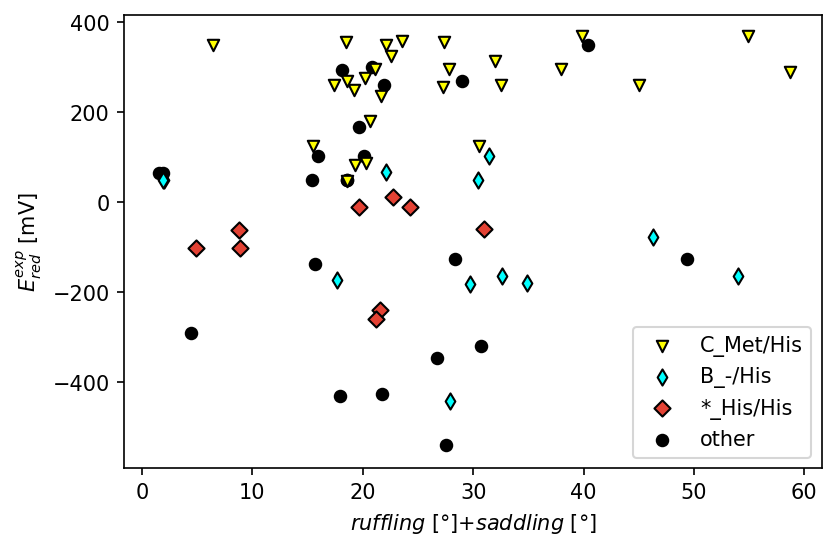

In [67]:
df = dflg.copy()
df["combi"] = df["ruffling"] + df["saddling"]
fig = plt.figure(dpi=150)
scatterkat(df,"combi","Em_lit",Kategorie)
plt.xlabel(f"{dihedruf}+{dihedsad}")
plt.ylabel(redox)
print(f"Dihed ruffling vs {redox}")
plt.legend()
fig.savefig(f"{plots}linearcombi1.png")

saddling vs EM_lit für C_Met/His
/home/hagen/Masterarbeit/Verteidigung/plots/saddling_Emlit_CHM.png


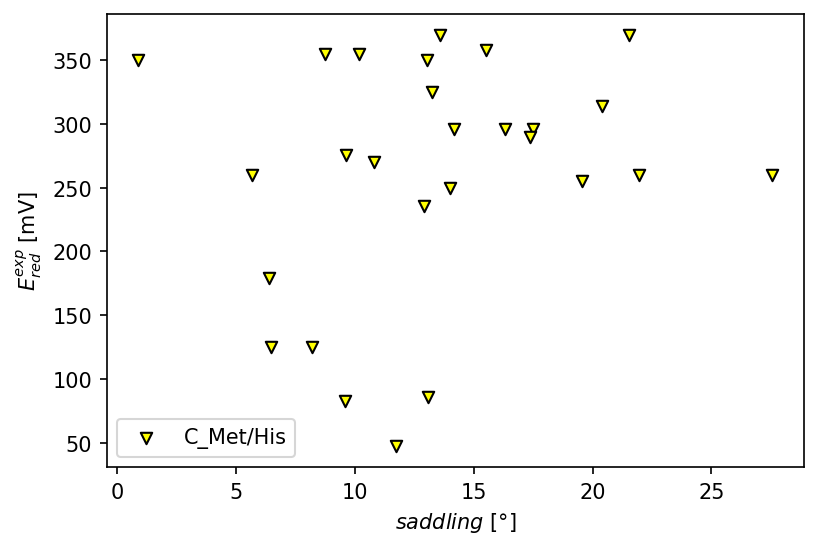

In [68]:
fig = plt.figure(dpi=150)

kombi = CHM
print(f"saddling vs EM_lit für {kombi}")
df = dflg.copy()
df = df[df[kombi] == 1]
plt.scatter(df["saddling"], df["Em_lit"],**scatterdict[kombi],label = kombi)
plt.xlabel(dihedsad)
plt.ylabel(redox)
fig.savefig(f"{plots}saddling_Emlit_CHM.png")
print(f"{plots}saddling_Emlit_CHM.png")
plt.legend()

saddling vs EM_lit für C_Met/His
/home/hagen/Masterarbeit/Verteidigung/plots/saddling_Emlit_CHM.png


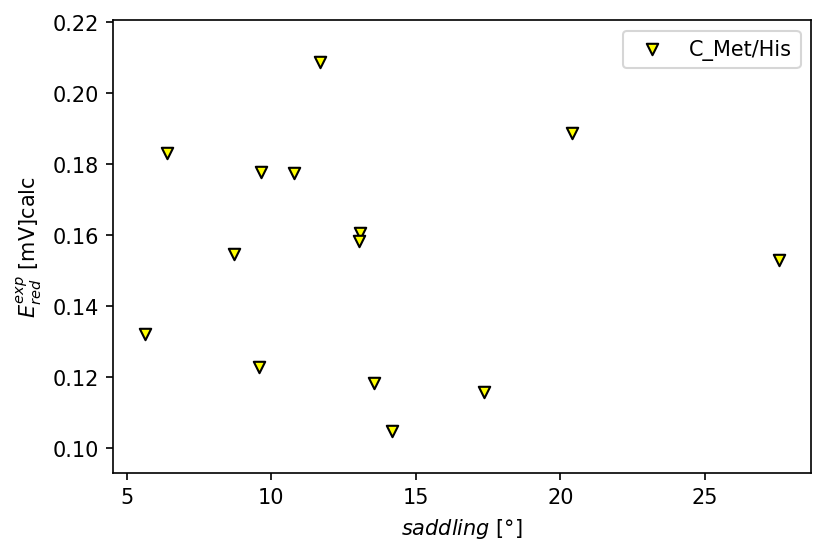

In [69]:
fig = plt.figure(dpi=150)
edif = "edif-2-1"
kombi = CHM
print(f"saddling vs EM_lit für {kombi}")
df = df_work2.copy()
df = df[df[kombi] == 1]
df = df[df[edif]>-0.5]
plt.xlabel(dihedsad)
plt.ylabel(redox+"calc")
plt.scatter(df["saddling"], df[edif],**scatterdict[kombi],label = kombi)

print(f"{plots}saddling_Emlit_CHM.png")
plt.legend()

In [70]:
#df_work6["Kategorie2"].value_counts()

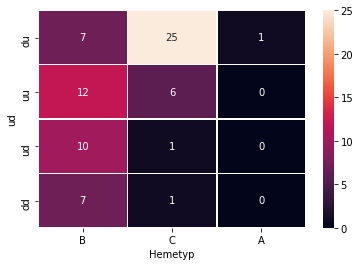

In [71]:
hashmap(dflg, "Hemetyp","ud")

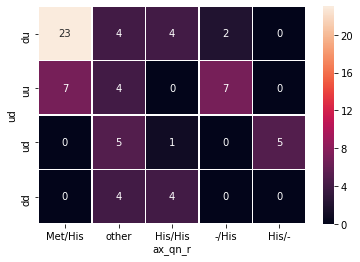

In [72]:
hashmap(dflg, "ax_qn_r","ud")

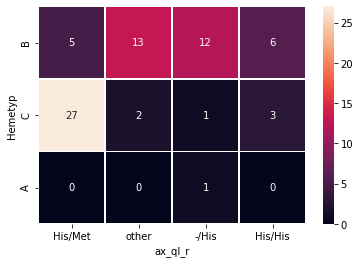

In [73]:
hashmap(dflg, "ax_ql_r","Hemetyp")

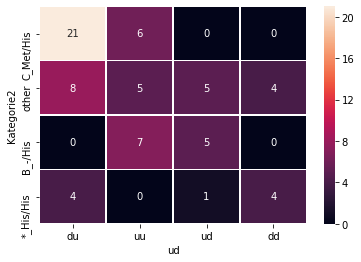

In [74]:
hashmap(dflg,"ud","Kategorie2")

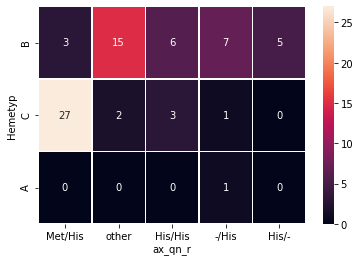

In [75]:
hashmap(dflg, "ax_qn_r","Hemetyp")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, '$ ruffling$ $[°]$')

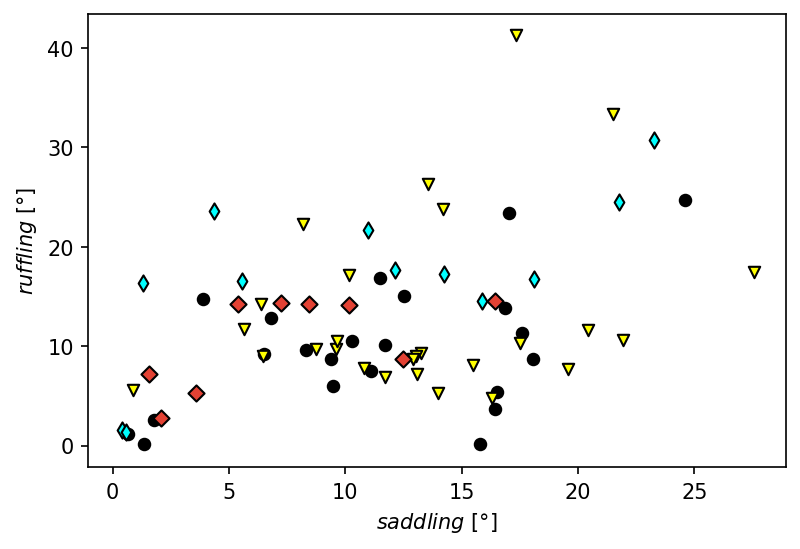

In [76]:
fig = plt.figure(dpi = 150)
scatterkat(dflg,"saddling","ruffling",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)

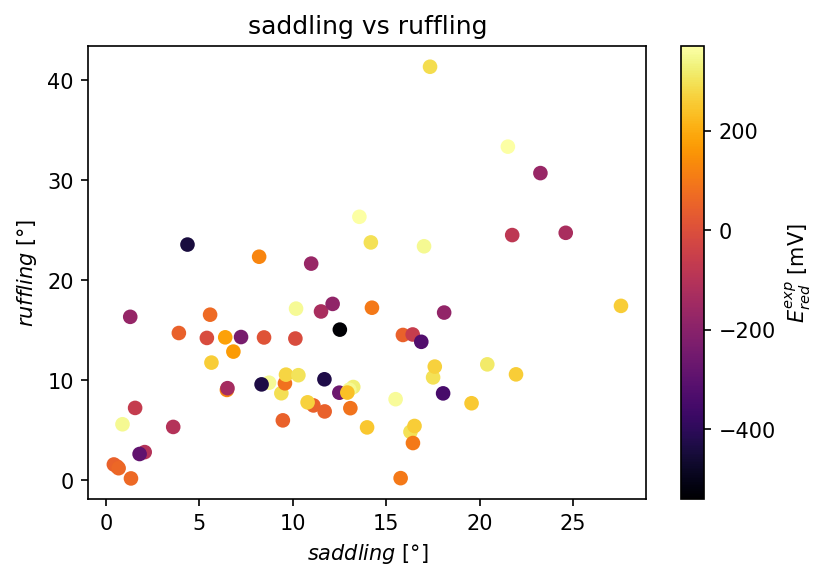

In [77]:
fig = plt.figure(dpi = 150)

plt.xlabel(dihedsad)
plt.ylabel(dihedruf)
plt.title("saddling vs ruffling")
plt.scatter(dflg["saddling"],dflg["ruffling"],c = dflg["Em_lit"],cmap =cmap1)
col = plt.colorbar()
col.set_label(redox)
fig.savefig(f"{plots}ruffling_vs_saddling.png")

In [78]:
Propionate

'conformation of Propionate side chains'

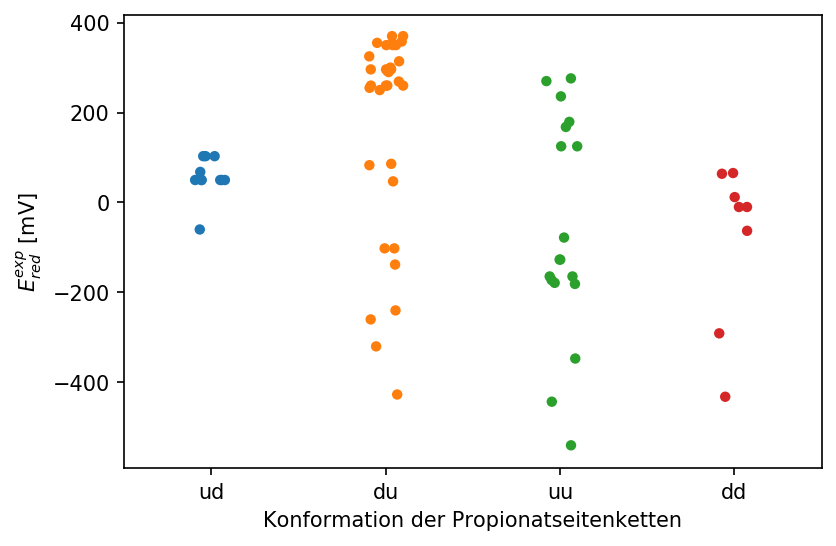

In [79]:
plt.figure(dpi=150)
df = dflg.copy()
df[redox] = df["Em_lit"]
Propionate = "Konformation der Propionatseitenketten"
df[Propionate] = df["ud"]
#fig = sns.stripplot(data=dflg, x = "ud", y ="Em_lit")
fig = sns.stripplot(data=df, x = Propionate, y =redox)

fig.figure.savefig(f"{plots}ud.png")

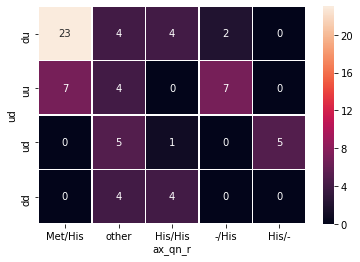

In [80]:
sns.stripplot(data=dflg, x = "ud", y ="Em_lit")

hashmap(dflg,"ax_qn_r","ud")

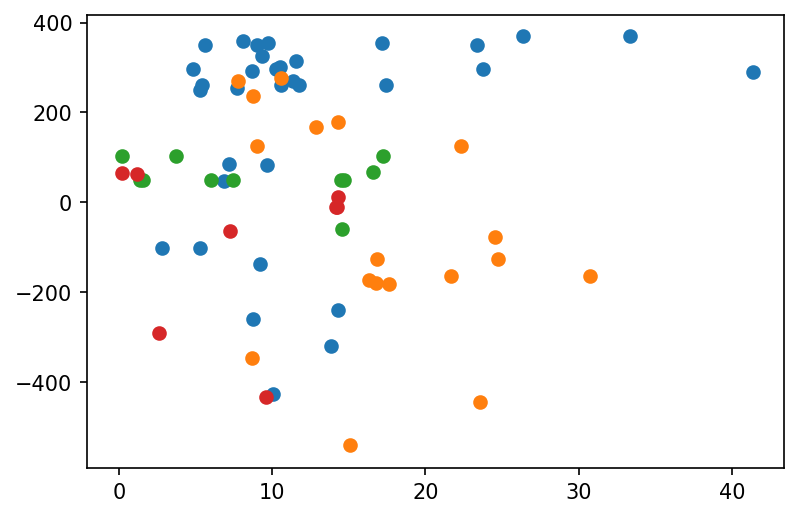

In [81]:
plt.figure(dpi=150)
for u in  dflg["ud"].value_counts().index:
    df =dflg.copy()
    df = df[df["ud"] == u]
    plt.scatter(df["ruffling"],df["Em_lit"])

# Graphiken mit QM   50

matplotlib.axes._subplots.AxesSubplot

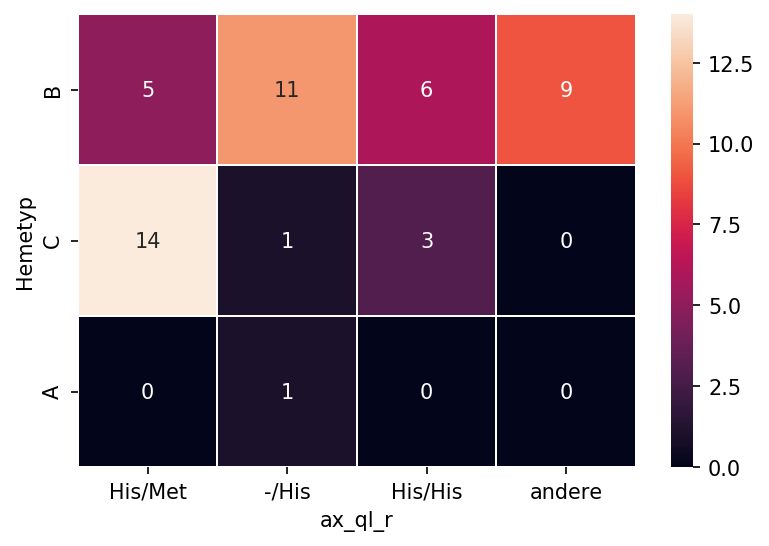

In [82]:
fig = plt.figure(dpi=150)

f = hashmap(df_work2, "ax_ql_r","Hemetyp")

type(f)


In [83]:
df_work2["Kategorie2"].value_counts()

other        16
C_Met/His    14
B_-/His      11
*_His/His     9
Name: Kategorie2, dtype: int64

In [84]:
print(Kategorie)
Kategorieqm = [BHIS,CHM]
Kategorieqm

['C_Met/His', 'B_-/His', '*_His/His']


['B_-/His', 'C_Met/His']

In [85]:
df_work2.head()

ud Hemetyp  Em_lit ligup ligdown Elektrode    ax_qn    ax_ql  ax_qn_r  \
PDB                                                                           
1AW3  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1F1C  du       C  -260.0   His     His       NHE  His/His  His/His  His/His   
1DJ1  uu       B  -172.6     -     His       SHE    -/His    -/His    -/His   
1A6G  ud       B    50.0   His      CO       NHE   His/CO   CO/His   andere   
4MU8  du       C   269.0     -     His       SHE    -/His    -/His    -/His   

      ax_ql_r  ... dipole_6_nbo qpole1_6_nbo qpole2_6_nbo  qpole3_6_nbo  \
PDB            ...                                                        
1AW3  His/His  ...       8.3028    35.294886   -12.169188    -23.125698   
1F1C  His/His  ...      11.5338    26.460276     6.064814    -32.525091   
1DJ1    -/His  ...       9.0051    47.237104    -0.996015    -46.241089   
1A6G   andere  ...       3.0235    35.285049   -13.194981    -22.090068   
4MU8    -/His  ...       8.8811    32.568814     2.506590    -35.075404   

      qpole4_6_nbo  edif-2-1  edif-2-5  edif-6-1  edif-6-5   PDB  
PDB                                                               
1AW3     43.916011  0.174495  0.158217  0.180812  0.164535  1AW3  
1F1C     42.365195  0.156362  0.200516  0.117515  0.161669  1F1C  
1DJ1     66.110320  0.220645  0.225211  0.196823  0.201388  1DJ1  
1A6G     43.670509  0.185926  0.164437  0.232666  0.211177  1A6G  
4MU8     47.930102  0.167708  0.188829  0.153440  0.174561  4MU8  

[5 rows x 77 columns]

Redoxpotential berechnet vs gemessen


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

/home/hagen/Masterarbeit/Verteidigung/plots/edif_Em_lit.png


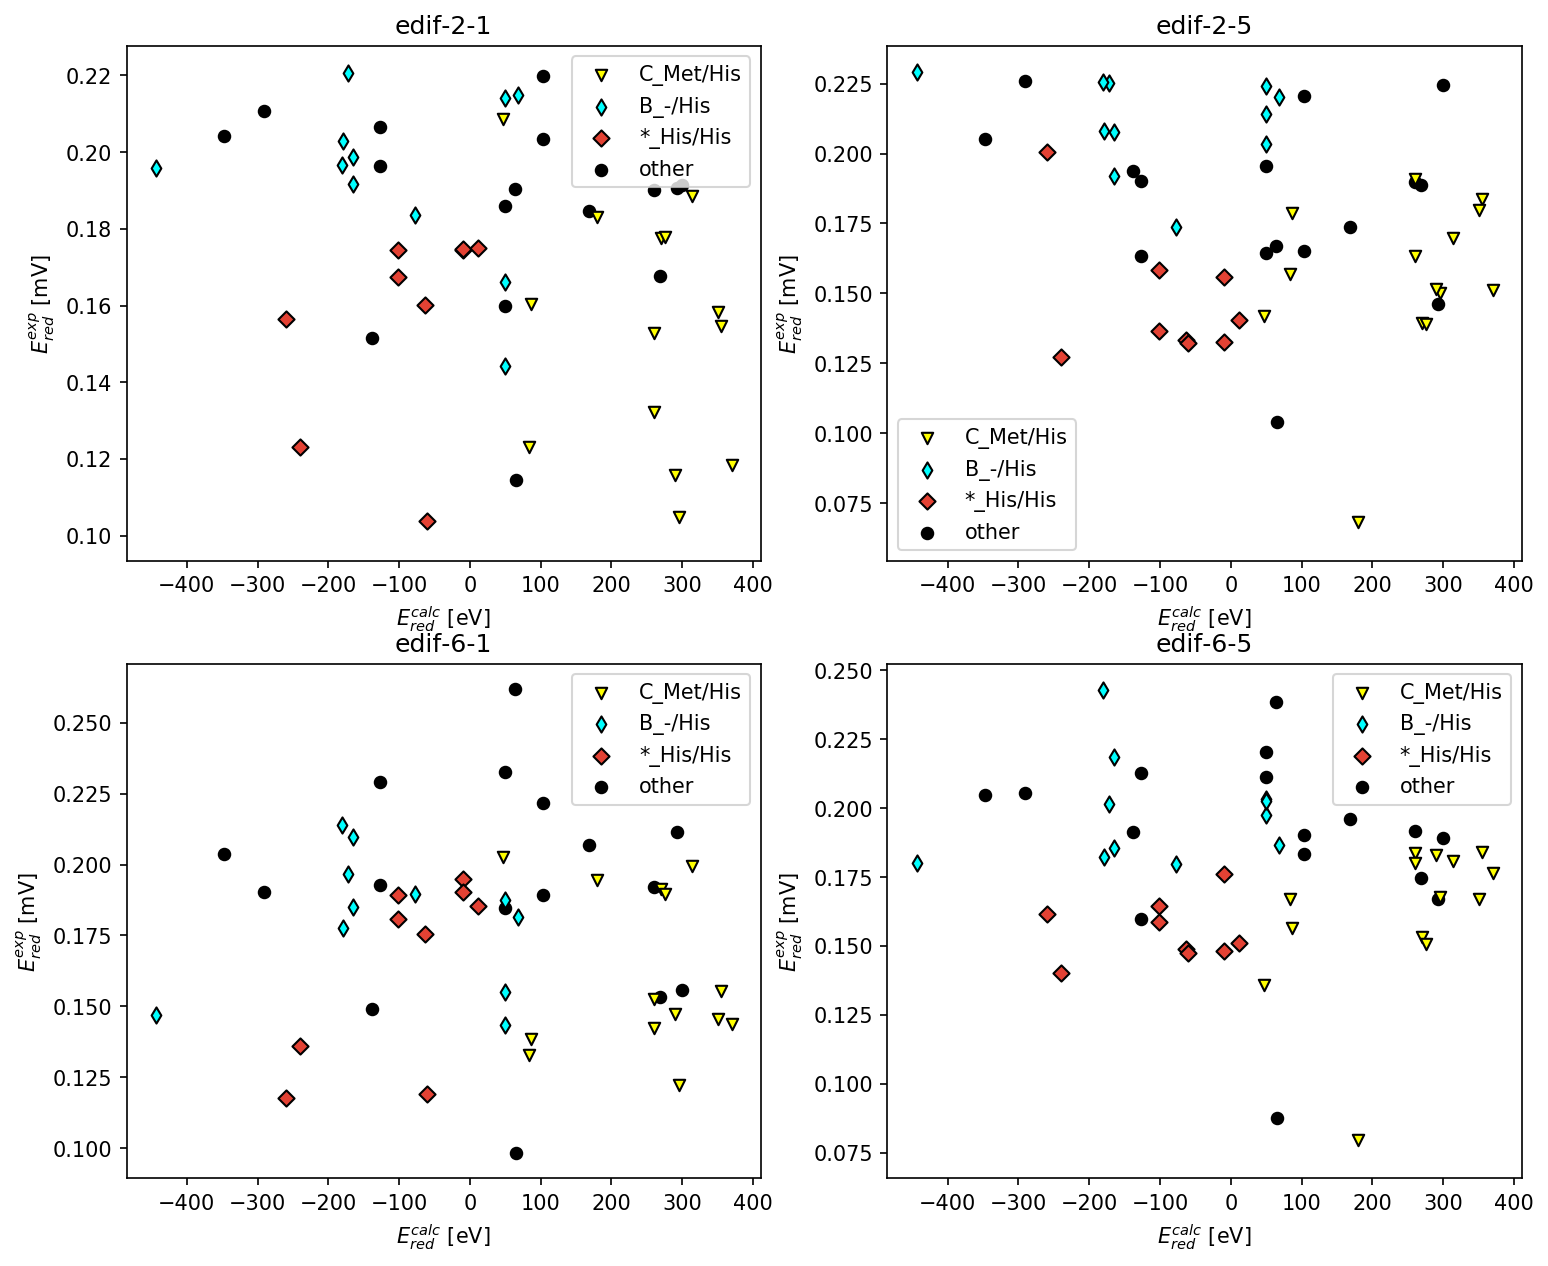

In [86]:
lit = "Em_lit"

if (True):
    fig = plt.figure(dpi=150,figsize=[12,10])
    #fig.suptitle("Redoxpotential berechnet vs gemessen",fontsize =16)
    print("Redoxpotential berechnet vs gemessen")
    for i,c in enumerate ([i for i in  df_work2.columns if "edif-" in i]):
        plt.subplot(2,2,i+1)
        df = df_work2[df_work2[c]>0]
        plt.title(c)
        scatterkat(df,lit,c,Kategorie)
        plt.ylabel(redox)
        plt.xlabel(redox_calc)
        plt.legend()
else:
    c = "edif-2-1"

    fig = plt.figure(dpi=150)#,figsize=[12,10])
    
    df = df_work2[df_work2[c]>0]
    plt.title(f"{edif} vs"+"  $E_{redox}(lit)$" )#, fontsize=16)
    scatterkat(df,lit,c,Kategorie)
    plt.ylabel(redox)
    plt.xlabel(redox_calc)   
    plt.legend()
fig.savefig(f"{plots}edif_{lit}.png")
print(f"{plots}edif_{lit}.png")


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Redoxpotential berechnet vs Dihedral saddling
edif-2-1
edif-2-5
edif-6-1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


edif-6-5
/home/hagen/Masterarbeit/Verteidigung/plots/edif_saddling.png


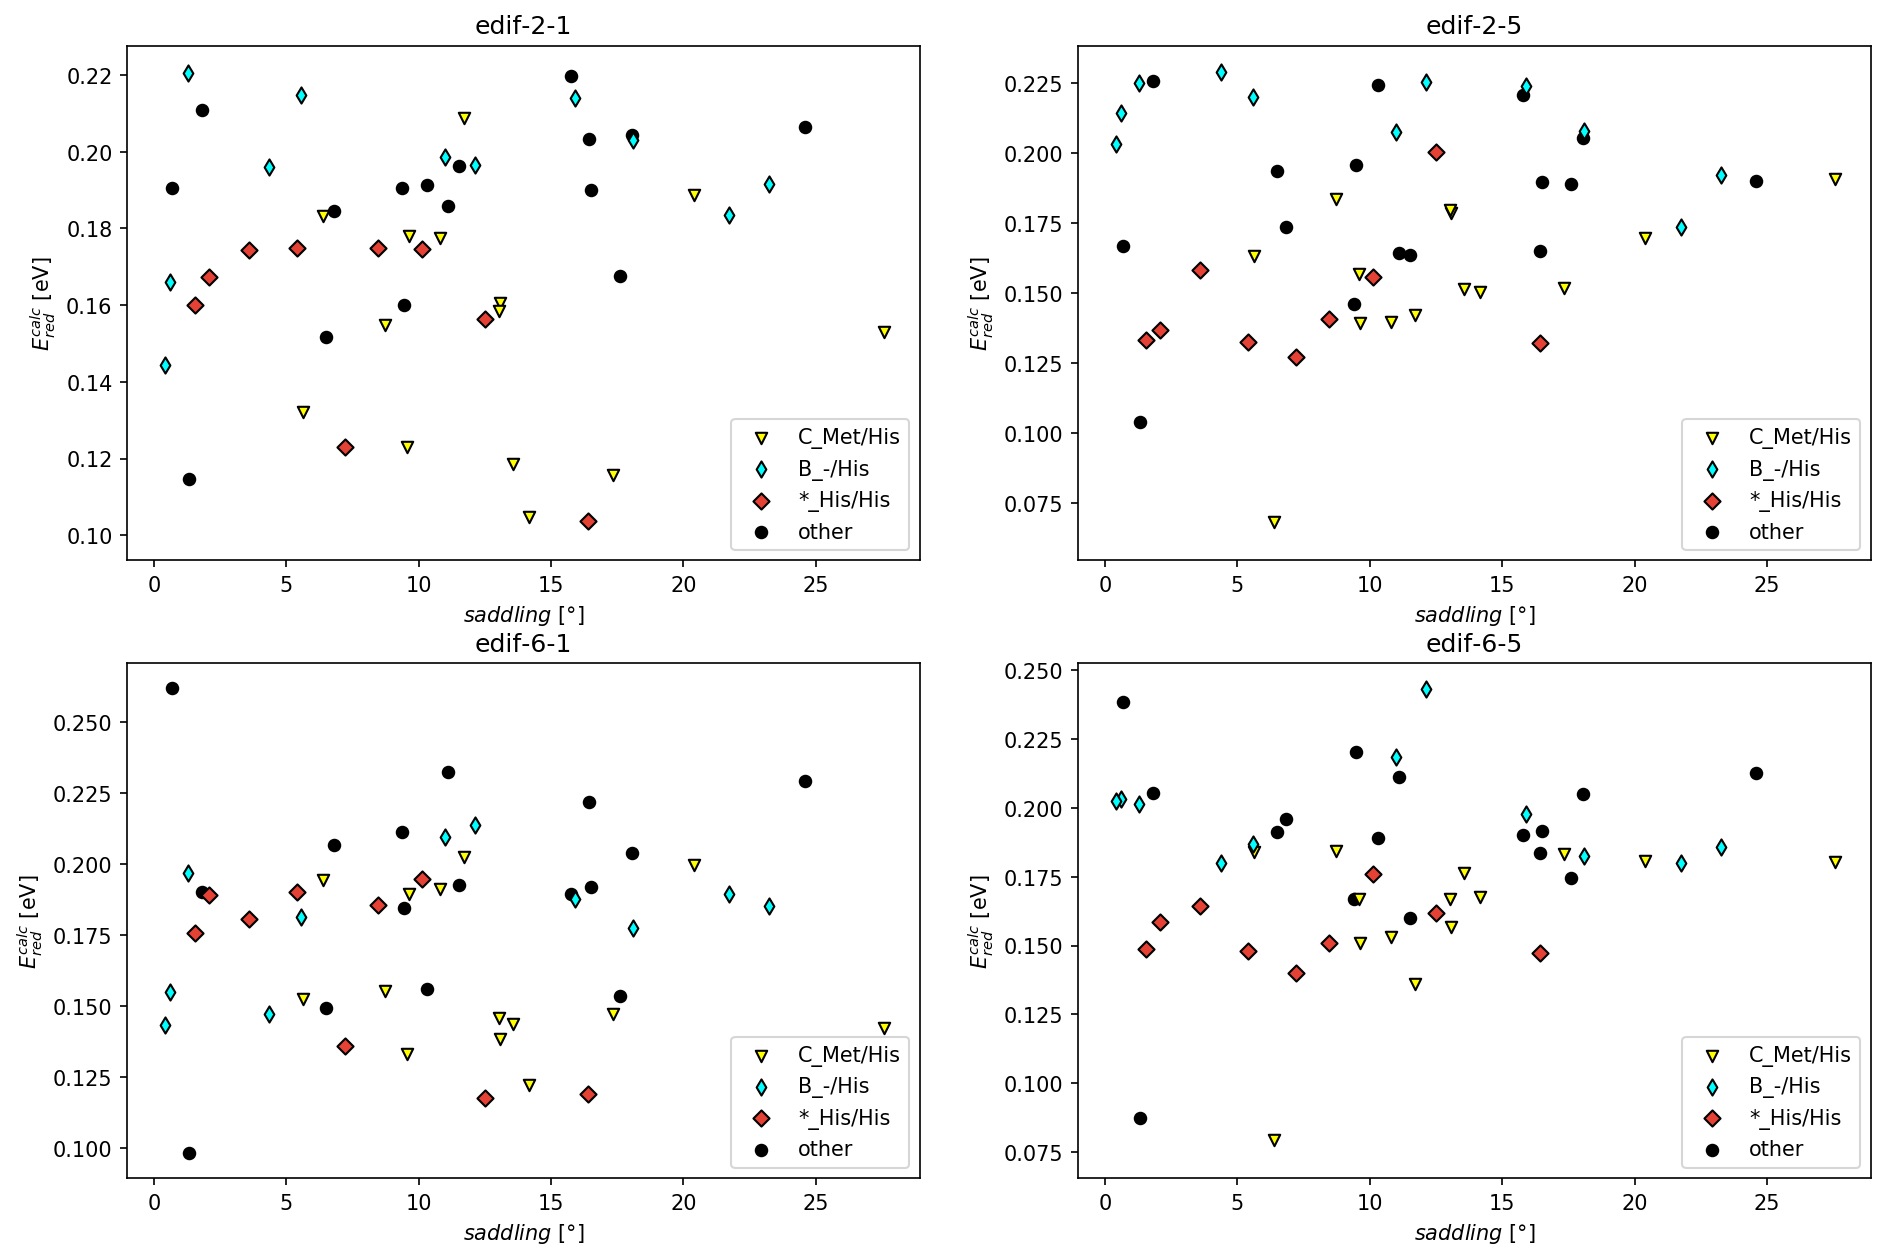

In [87]:
lit = "saddling"



if(True):
    fig = plt.figure(dpi=150, figsize=(15,10))
    #fig.suptitle("Redoxpotential berechnet vs Dihedral saddling",fontsize =16)
    print("Redoxpotential berechnet vs Dihedral saddling")    
    for i,c in enumerate ([i for i in  df_work2.columns if "edif-" in i]):
        print(c)
        plt.subplot(2,2,i+1)
        df = df_work2[df_work2[c]>0]
        plt.title(c)
        scatterkat(df,lit,c,Kategorie)
        plt.xlabel(dihedsad)
        plt.ylabel(redox_calc)
        plt.legend()
else:        
    c = "edif-2-1"
    print(c)
    fig = plt.figure(dpi=150)
    df = df_work2[df_work2[c]>0]
    plt.title(f"{edif} vs  {dihedruf}" )#, fontsize=16)
    scatterkat(df,lit,c,Kategorie)
    plt.xlabel(dihedruf)
    plt.ylabel(redox_calc)  
    plt.legend()

fig.savefig(f"{plots}edif_{lit}.png")
print(f"{plots}edif_{lit}.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Redoxpotential berechnet vs Dihedral ruffling
edif-2-1
edif-2-5
edif-6-1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


edif-6-5
/home/hagen/Masterarbeit/Verteidigung/plots/edif_ruffling.png


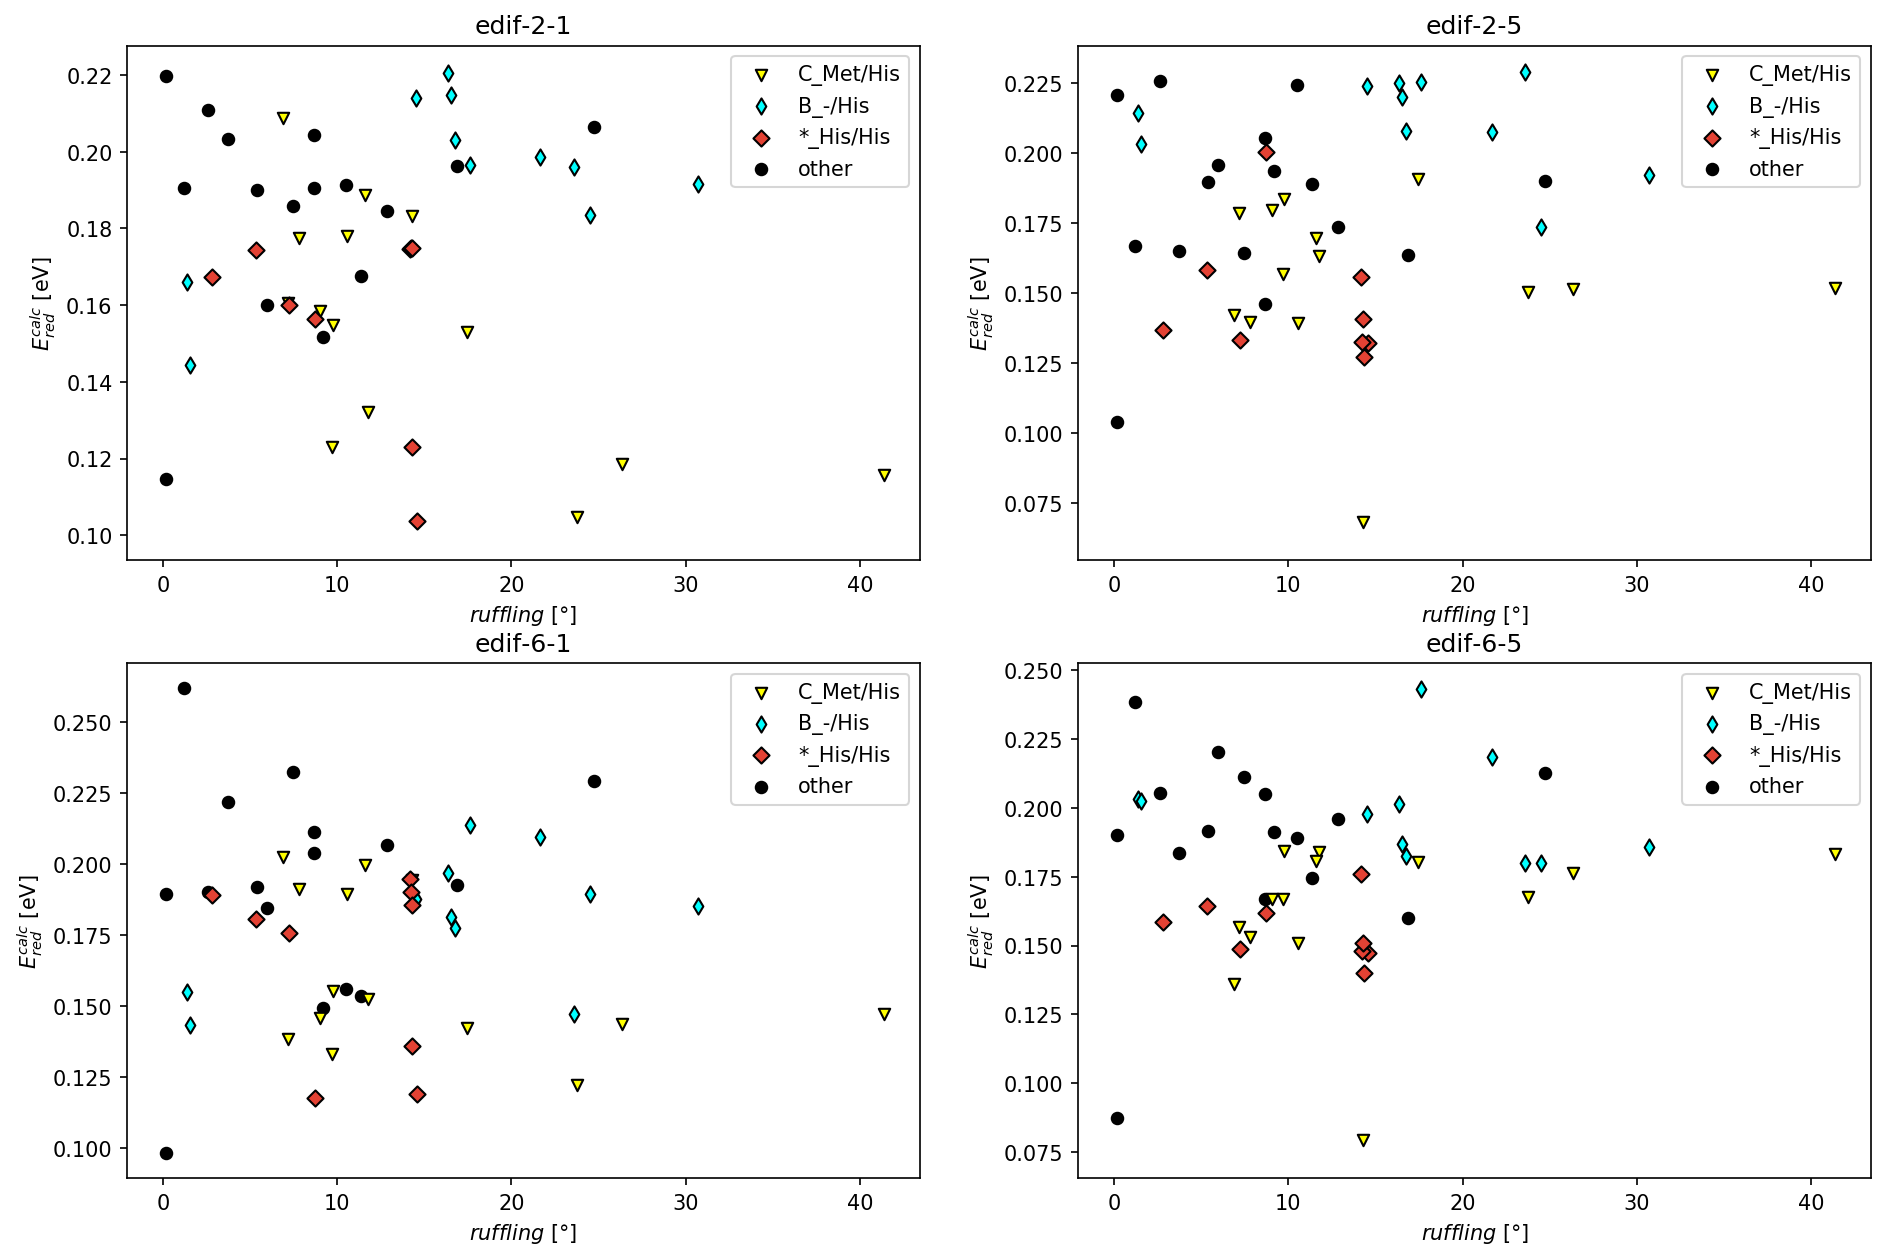

In [88]:
lit = "ruffling"



if(True):
    fig = plt.figure(dpi=150, figsize=(15,10))
    #fig.suptitle("Redoxpotential berechnet vs Dihedral ruffling",fontsize =16)
    print("Redoxpotential berechnet vs Dihedral ruffling")
    for i,c in enumerate ([i for i in  df_work2.columns if "edif-" in i]):
        print(c)
        plt.subplot(2,2,i+1)
        df = df_work2[df_work2[c]>0]
        plt.title(c)
        scatterkat(df,lit,c,Kategorie)
        plt.xlabel(dihedruf)
        plt.ylabel(redox_calc)
        plt.legend()
else:        
    c = "edif-2-1"
    print(c)
    fig = plt.figure(dpi=150)
    df = df_work2[df_work2[c]>0]
    plt.title(f"{edif} vs  {dihedruf}" )#, fontsize=16)
    scatterkat(df,lit,c,Kategorie)
    plt.xlabel(dihedruf)
    plt.ylabel(redox_calc)  
    plt.legend()

fig.savefig(f"{plots}edif_{lit}.png")
print(f"{plots}edif_{lit}.png")

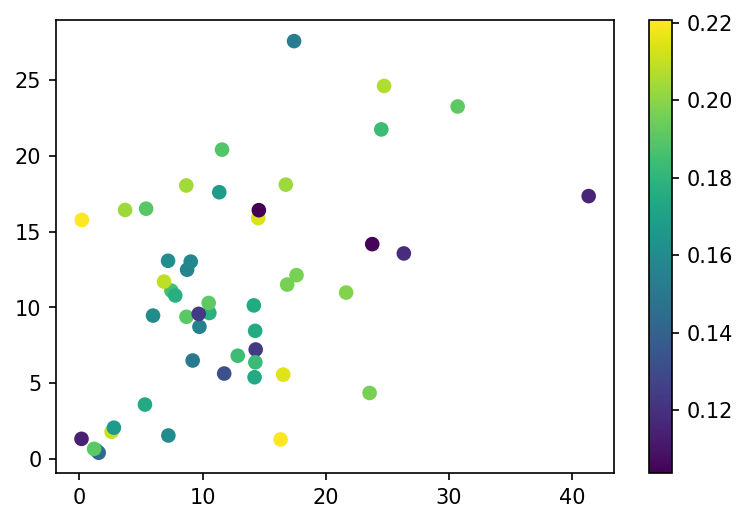

In [89]:
plt.figure(dpi=150)
df = df_work2.copy()
edif  = "edif-2-1"
#edif  = "edif-2-5"
df = df[df[edif]>0]
df2 = df.copy()
plt.scatter(df["ruffling"],df["saddling"],c =df[edif])
plt.colorbar()

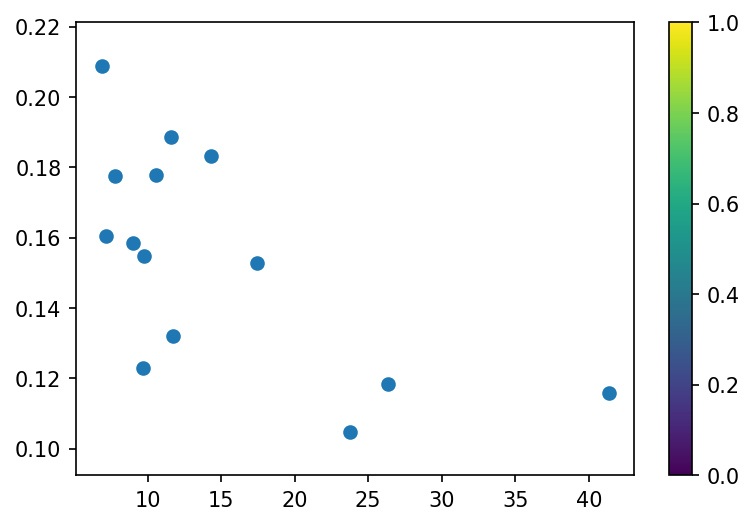

In [90]:
plt.figure(dpi=150)
df = df_work2.copy()
df = df[df["Kategorie2"]==CHM]
edif  = "edif-2-1"
#edif  = "edif-2-5"
df = df[df[edif]>0]
df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    plt.scatter(df["ruffling"],df[edif])#,c =df[edif])
plt.colorbar()

No handles with labels found to put in legend.


edif-2-1 vs ruffling


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


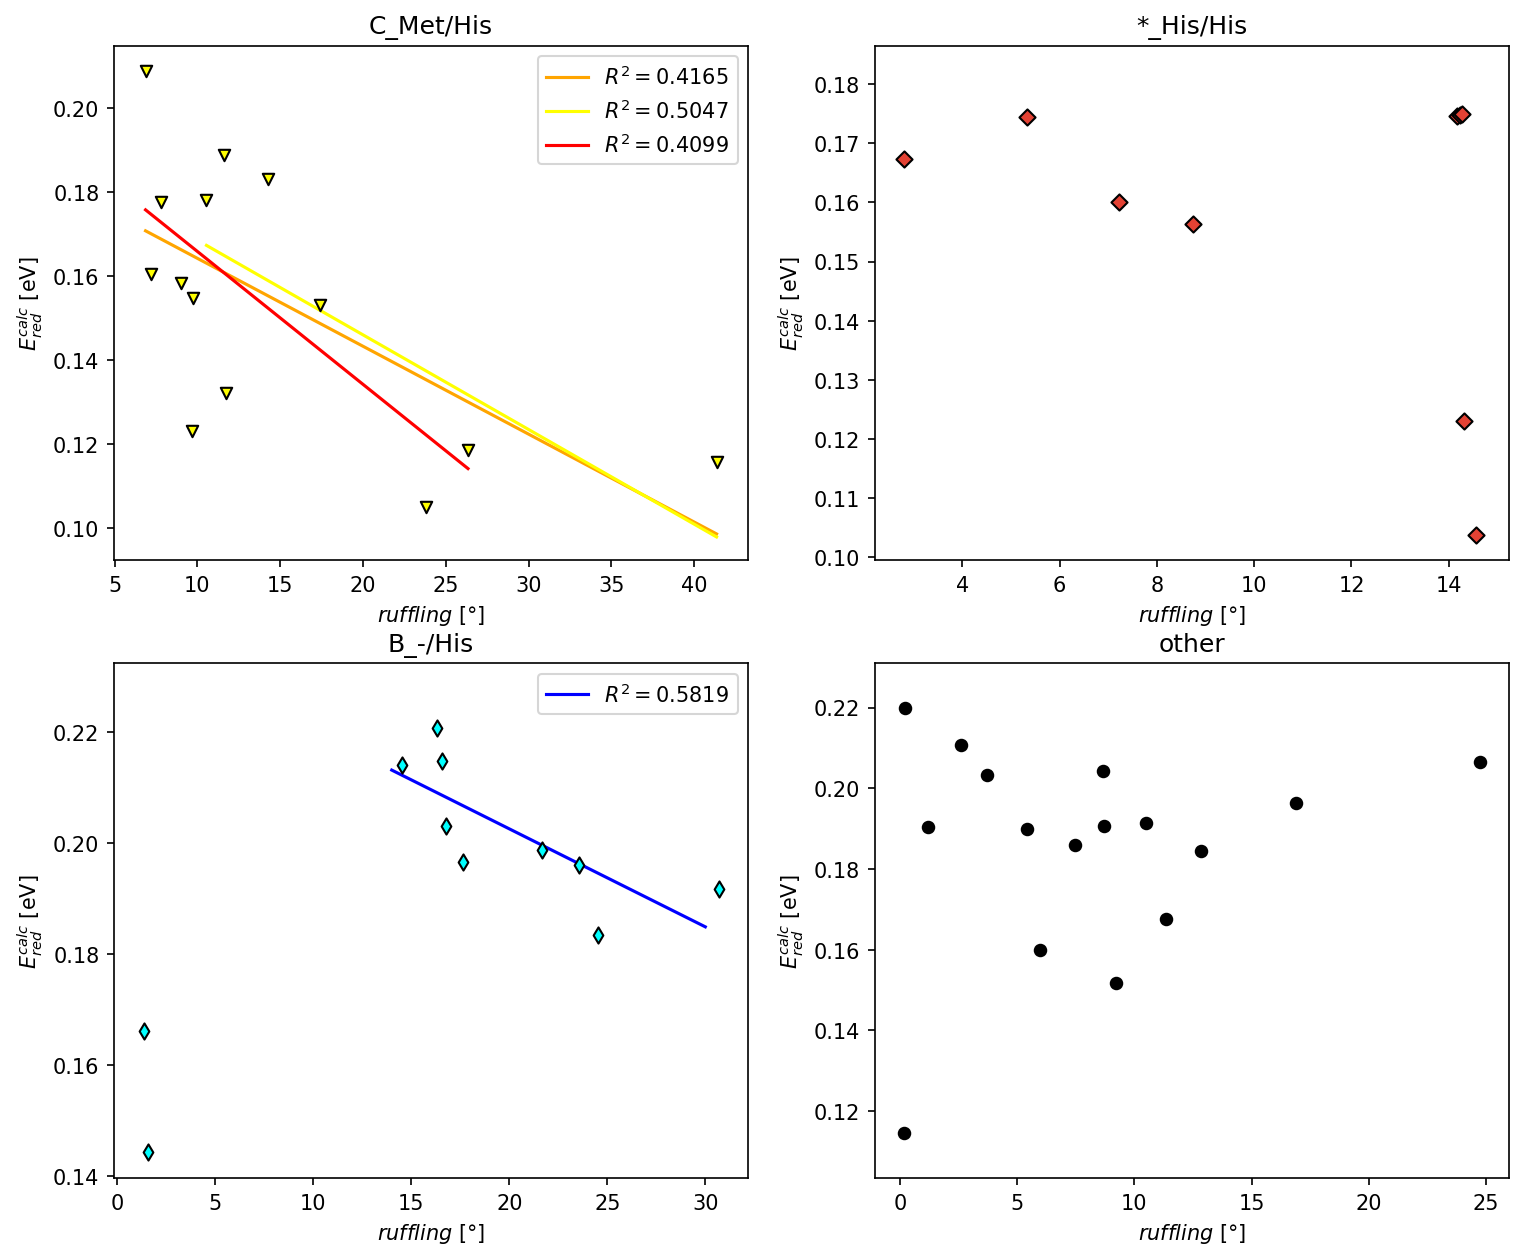

In [91]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
print(f"{edif} vs ruffling")
#fig.suptitle(f"{edif} vs ruffling",fontsize =16)



model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "orange",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "yellow",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
df = df[df["ruffling"]<30]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "red",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )













df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df = df[df[edif]>0]

#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
#plt.scatter(df["ruffling"],df[edif], label = kat,**scatterdict[kat])#,c =df[edif])
plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])#,c =df[edif])

plt.xlabel(dihedruf)
plt.ylabel(redox_calc)
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
plt.legend()
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["Hemetyp"].value_counts().index):
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    #plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
    plt.scatter(df["ruffling"],df[edif],**scatterdict[kat])#,c =df[edif])
    #plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])#,c =df[edif])
   # plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat],c={0:scatterdict[kat]["facecolor"],1:"pink"}[a1])

#plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(redox_calc)
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["ax_qn"].value_counts().index):
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

   # plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])
    plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])
    #plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat],c={0:scatterdict[kat]["facecolor"],1:"blue"}[a1])

    
    
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(redox_calc)
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
x = np.linspace(14,30)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "blue",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )
plt.legend()


plt.subplot(224)
kat = "other"
plt.xlabel(dihedruf)
plt.ylabel(redox_calc)
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]
plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])#,c =df[edif])
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
fig.savefig(f"{plots}edif21.png")

In [92]:
X.shape

(9, 1)

Text(0, 0.5, '$E_{red}^{exp}$ [mV]_calc')

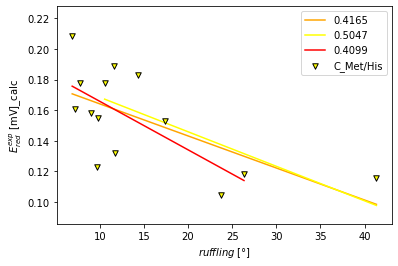

In [93]:
kat = CHM
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
plt.scatter(df["ruffling"],df[edif], label = kat,**scatterdict[kat])#,c =df[edif])

#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")


#df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "orange",label=np.round(model.score(X,y),4))

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "yellow",label=np.round(model.score(X,y),4))

df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
df = df[df["ruffling"]<30]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "red",label=np.round(model.score(X,y),4))


plt.xlabel(dihedruf)
plt.legend()
plt.ylabel(f"{redox}_calc")



#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


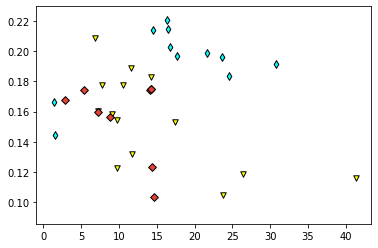

In [94]:
df = df_work2.copy()
df = df[df["Kategorie2"]!="other"]

scatterkat(df,"ruffling",edif,Kategorie)

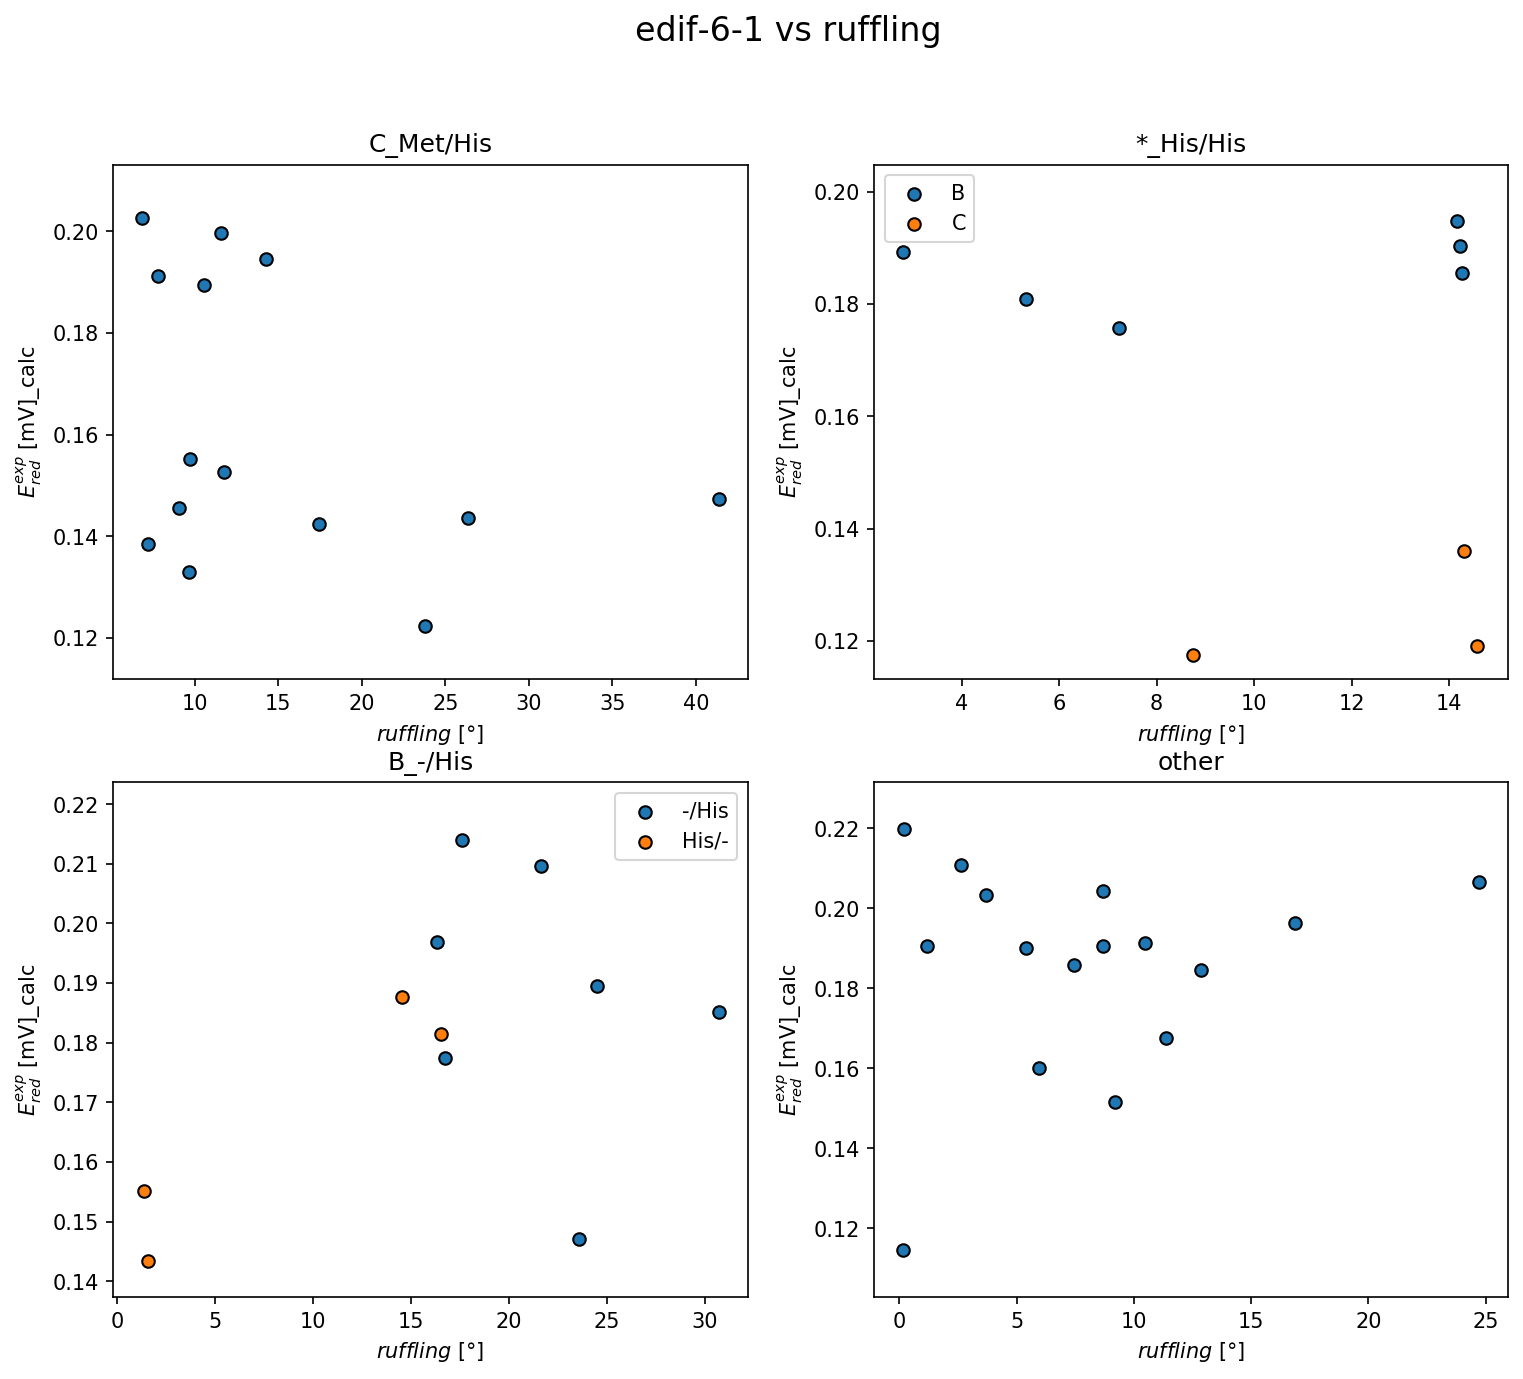

In [95]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

edif  = "edif-6-1"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)

df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["Hemetyp"].value_counts().index:
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")

plt.subplot(224)
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
kat = "other"
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

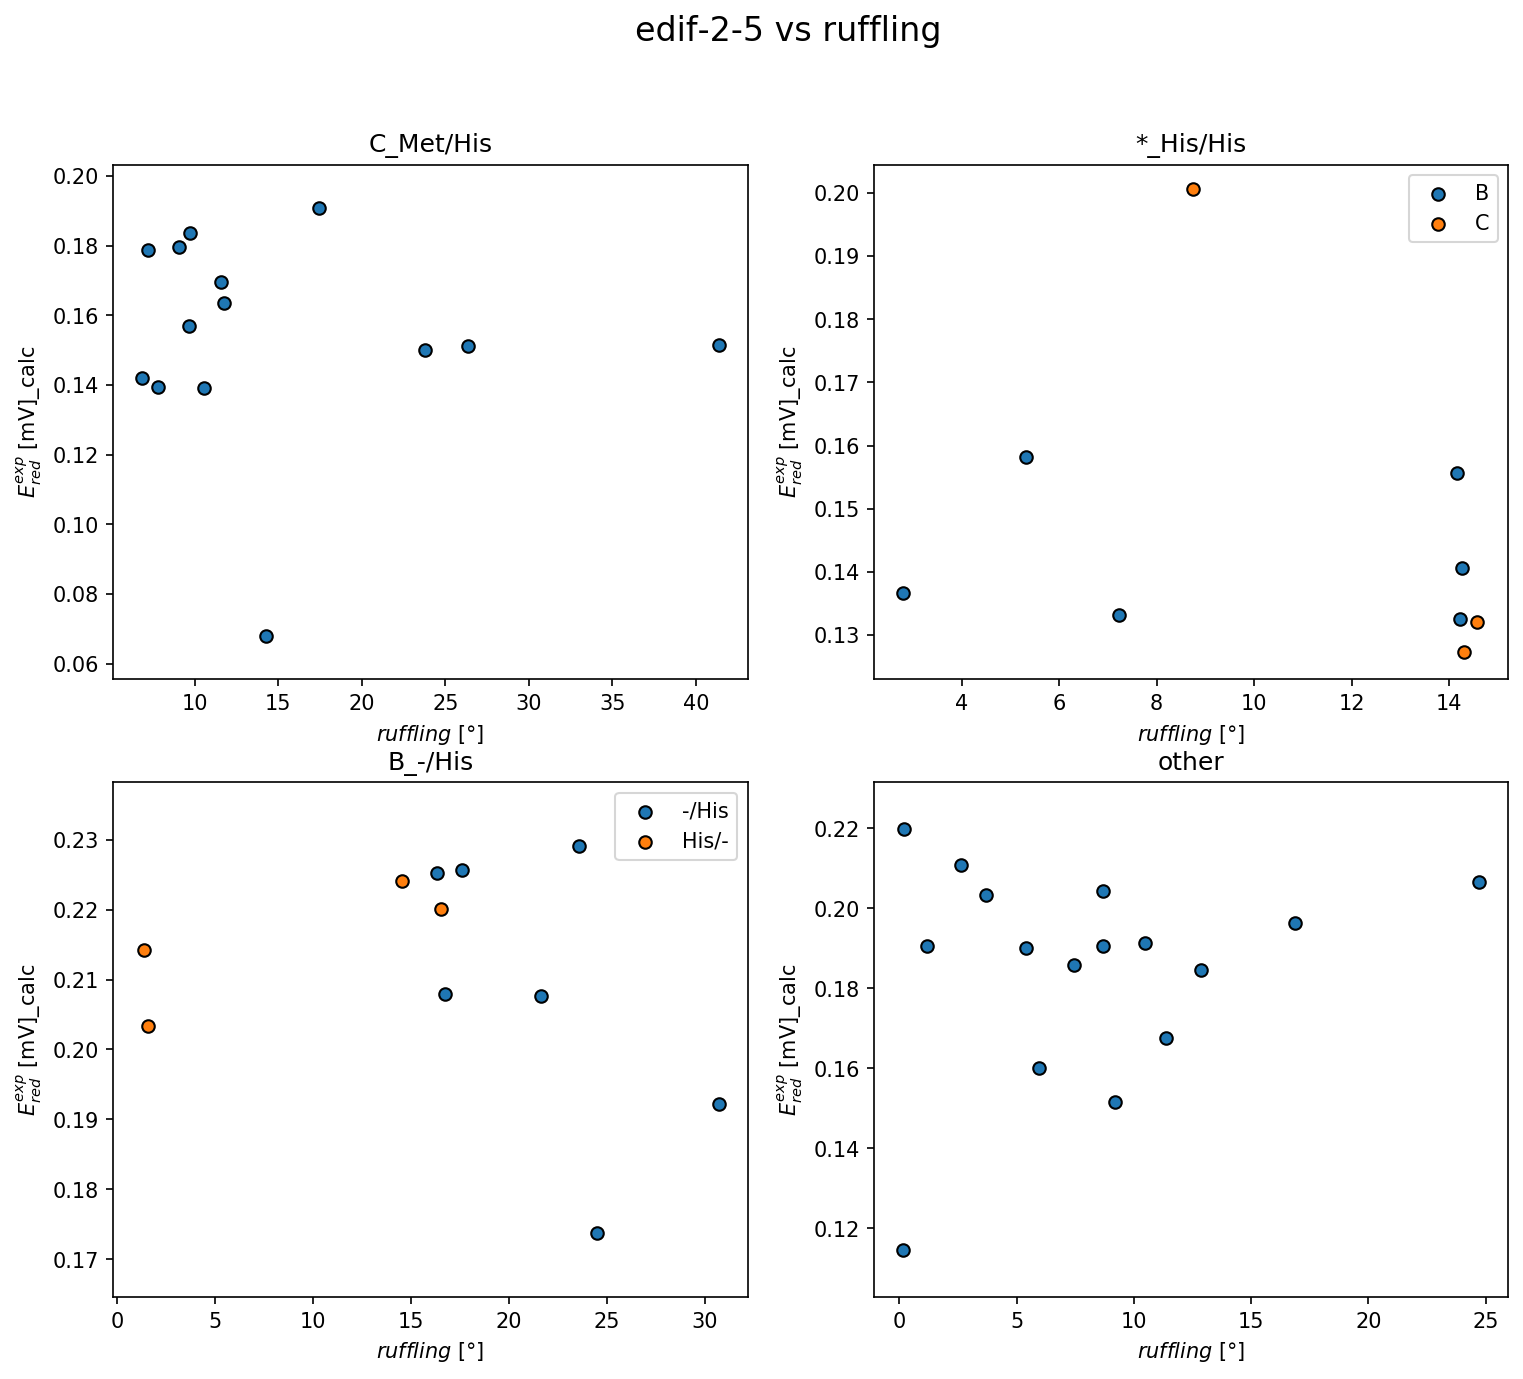

In [96]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-5"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)

df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["Hemetyp"].value_counts().index:
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")

plt.subplot(224)
kat = "other"
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

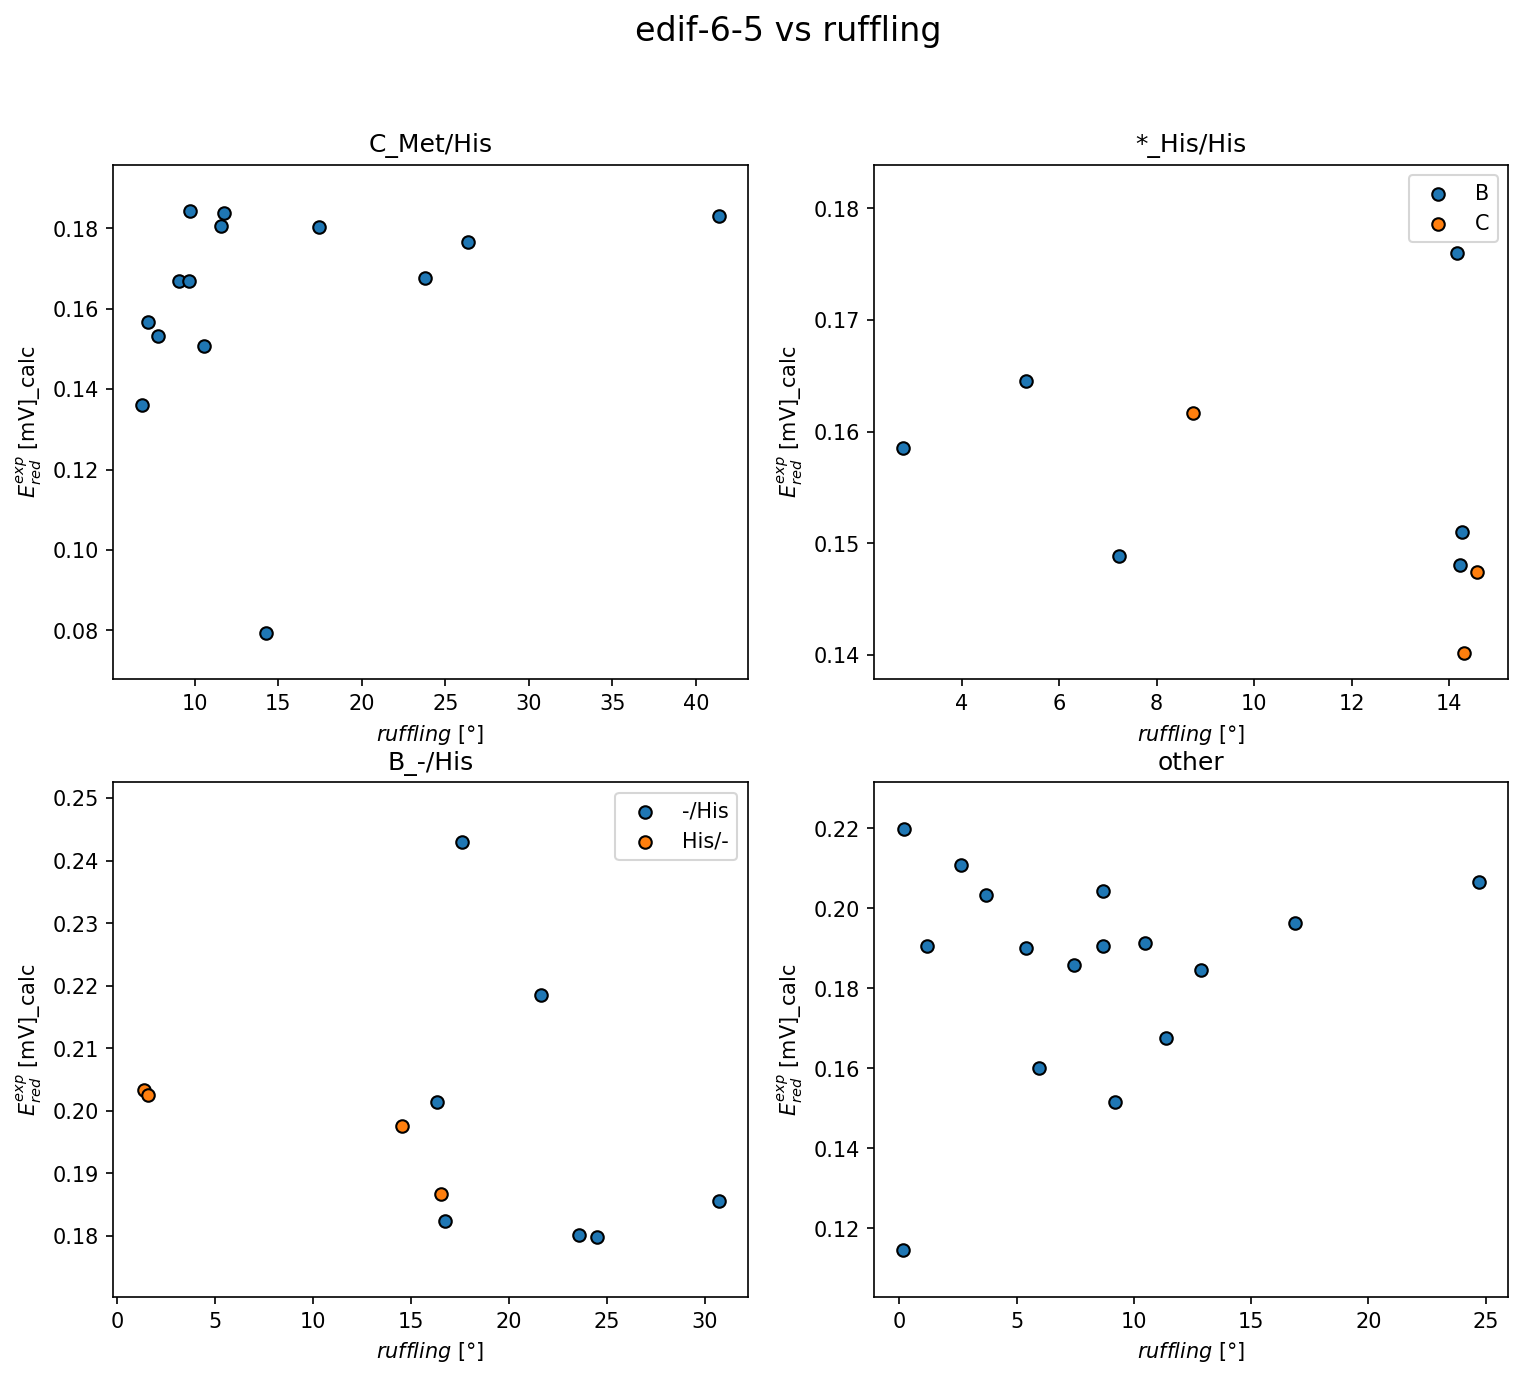

In [97]:
fig = plt.figure(dpi = 150,figsize=[12,10])


plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-6-5"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)
df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["Hemetyp"].value_counts().index:
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")


plt.subplot(224)
kat = "other"
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

In [98]:
df = dflg[dflg["ax_qn"] =="His/-"]
df[["ruffling","saddling","Em_lit","ud","Hemetyp"]]

ruffling   saddling  Em_lit  ud Hemetyp
pdb                                           
1A6K  14.519887  15.892665    50.0  ud       B
1DRM  16.548711   5.573944    68.0  ud       B
1FLP  17.245902  14.236266   103.0  ud       B
1JP6   1.566411   0.423901    50.0  ud       B
1JP9   1.356857   0.593972    50.0  ud       B

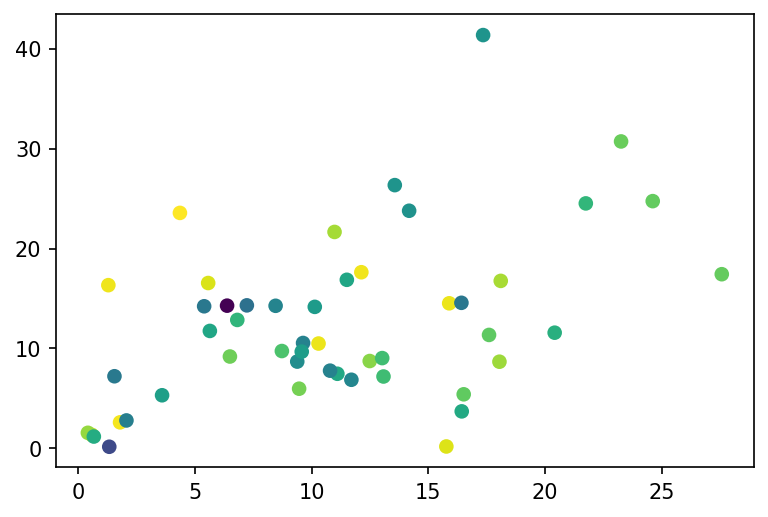

In [99]:
plt.figure(dpi=150)
edif = "edif-2-5"
df = df_work2.copy()
df = df[df[edif]>0]
plt.scatter(df["saddling"],df["ruffling"],c = df[edif])

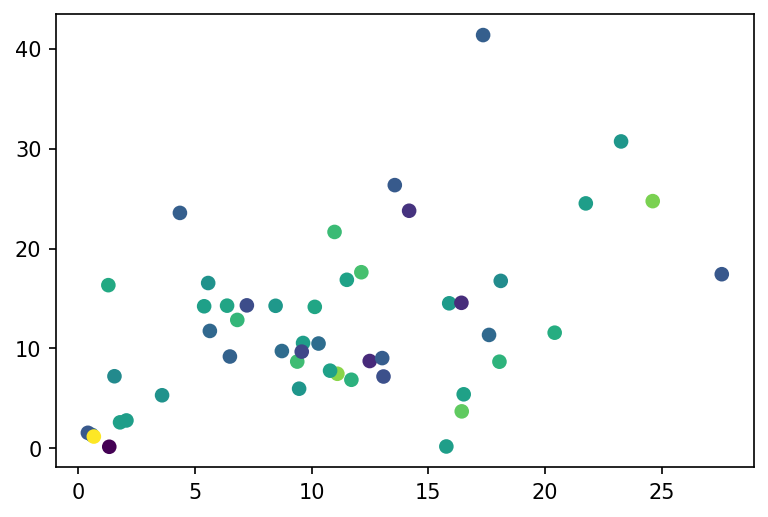

In [100]:
plt.figure(dpi=150)
edif = "edif-6-1"
df = df_work2.copy()
df = df[df[edif]>0]
plt.scatter(df["saddling"],df["ruffling"],c = df[edif])

Text(0, 0.5, '$ ruffling$ $[°]$')

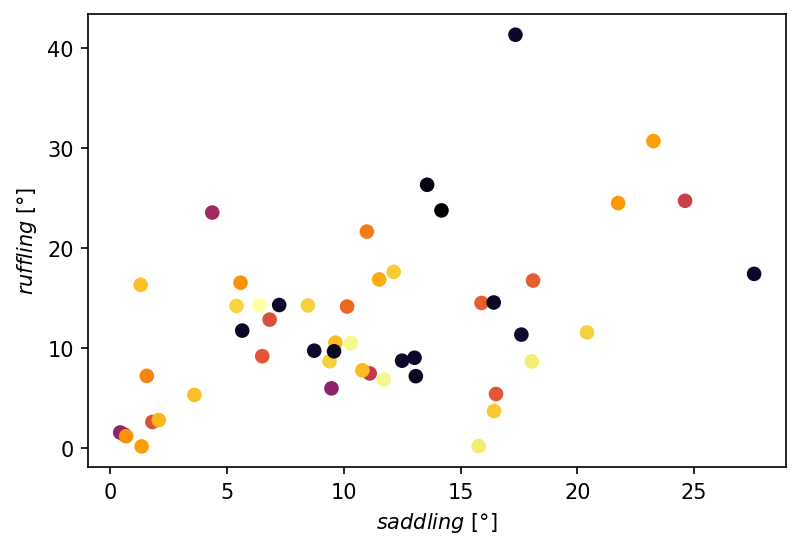

In [101]:
fig = plt.figure(dpi = 150)
#scatterkat(dflg,"saddling","ruffling",Kategorie)
plt.scatter(df_work2["saddling"],df_work2["ruffling"],c = df_work2["diff_1_nbo"],cmap =cmap1)
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)

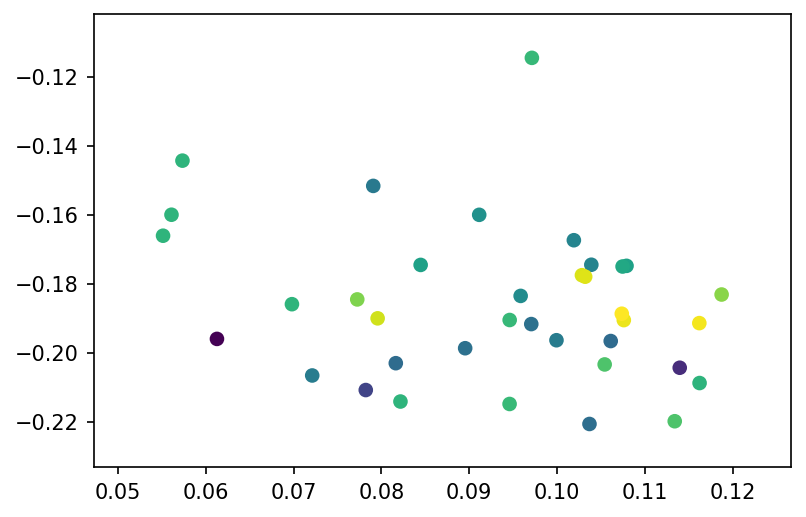

In [102]:
df = df_work2.copy()
df["redpot"] = df["e_1_nbo"] -df["e_2_nbo"]
fig = plt.figure(dpi = 150)

df = df[df["redpot"]<2] #-1]
df = df[df["diff_1_nbo"]>0.03]
plt.scatter(df["diff_1_nbo"],df["redpot"],c = df["Em_lit"])


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

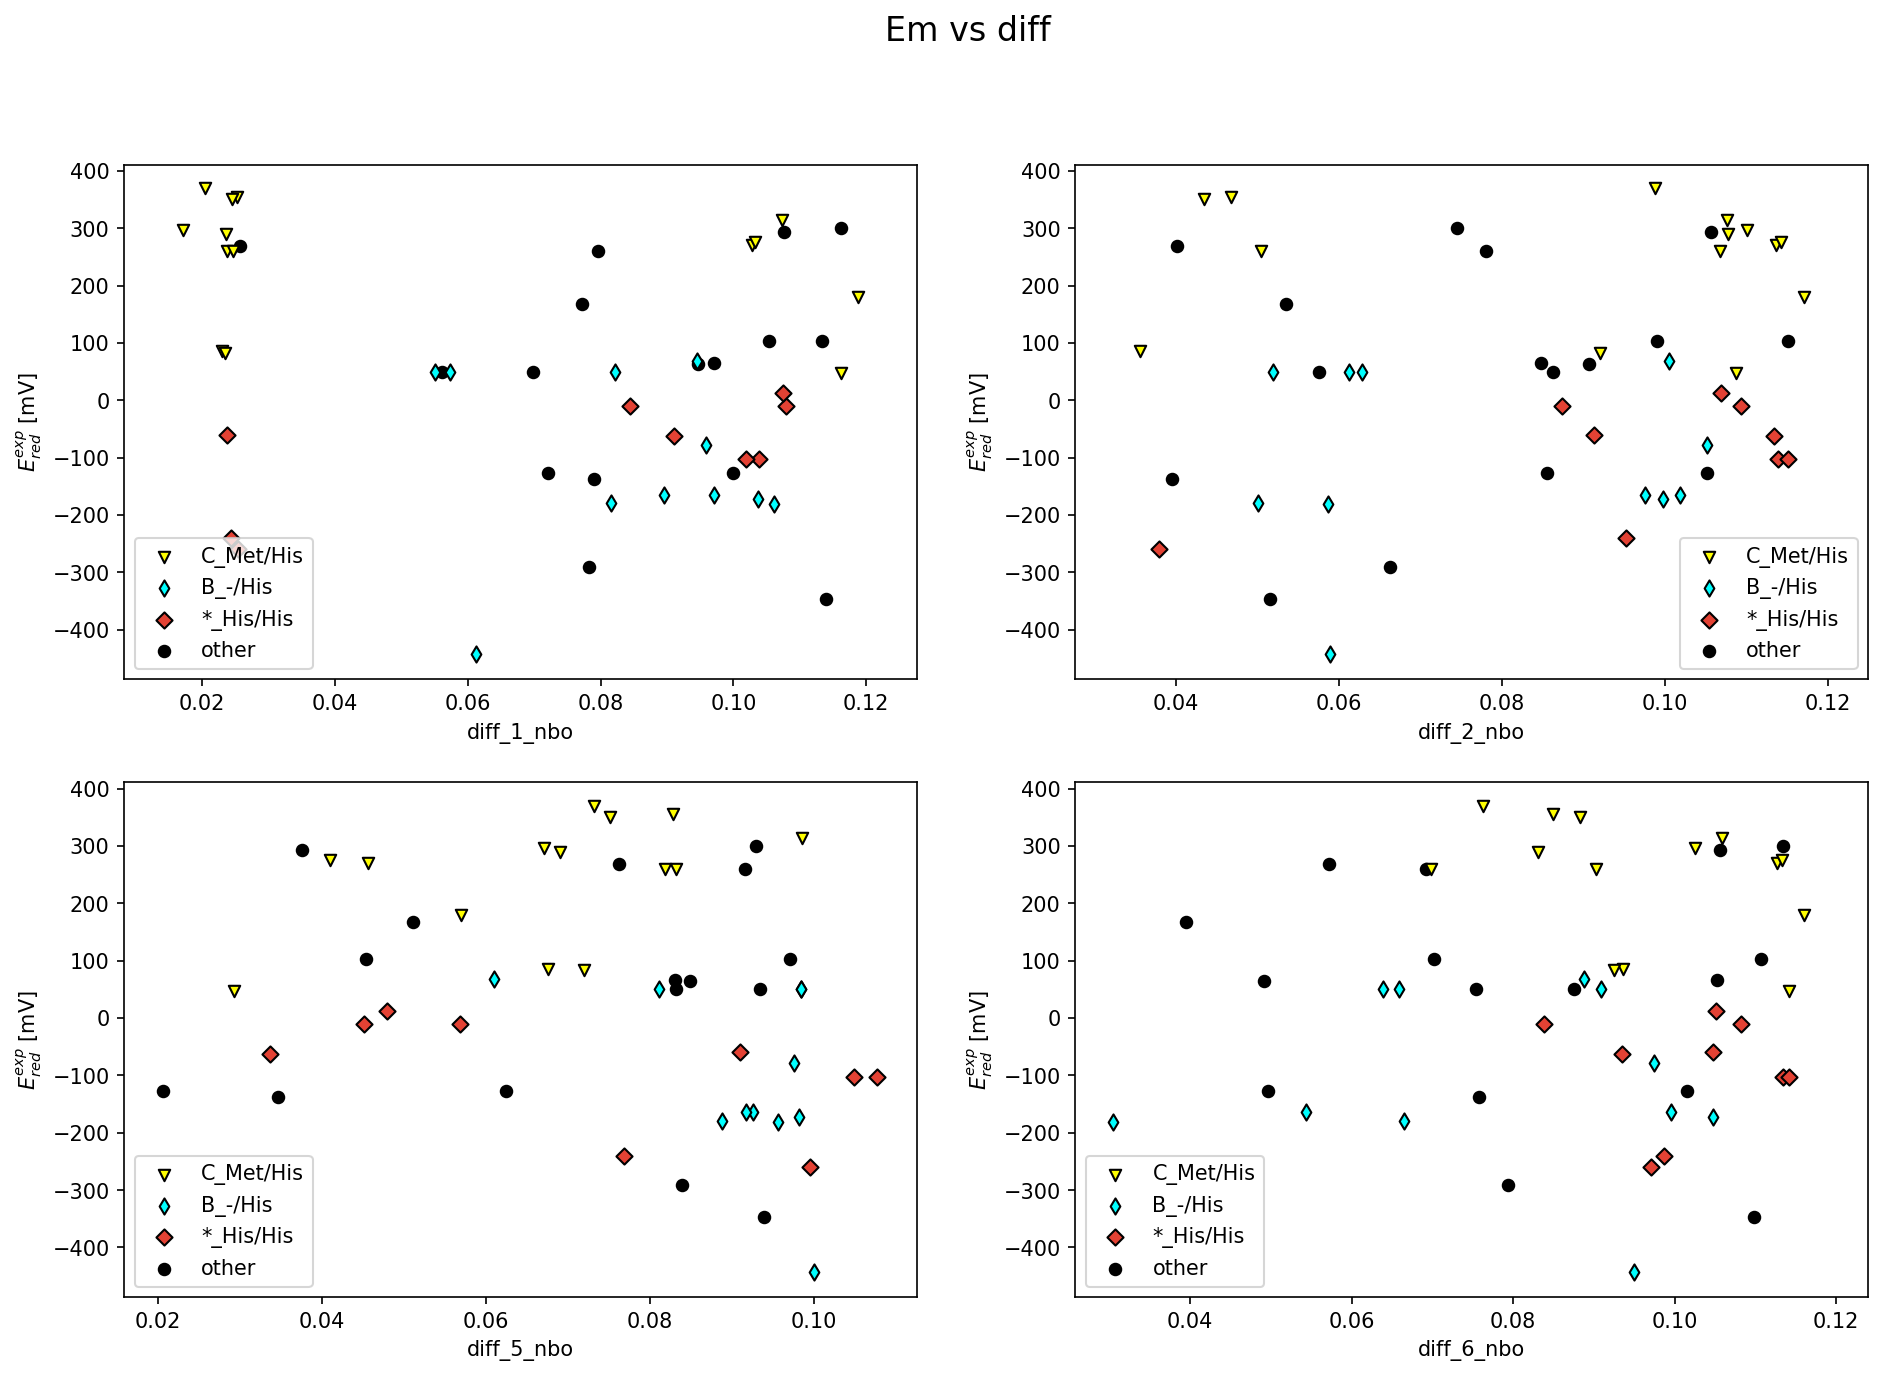

In [103]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('Em vs diff', fontsize=16)
    plt.subplot(2,2,i)
    scatterkat(df_work2,f"diff_{str(s)}_nbo","Em_lit",Kategorie)
    plt.legend()
    plt.xlabel(f"diff_{str(s)}_nbo")
    plt.ylabel(redox)
fig.savefig(f"{plots}Em_diff.png")            

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

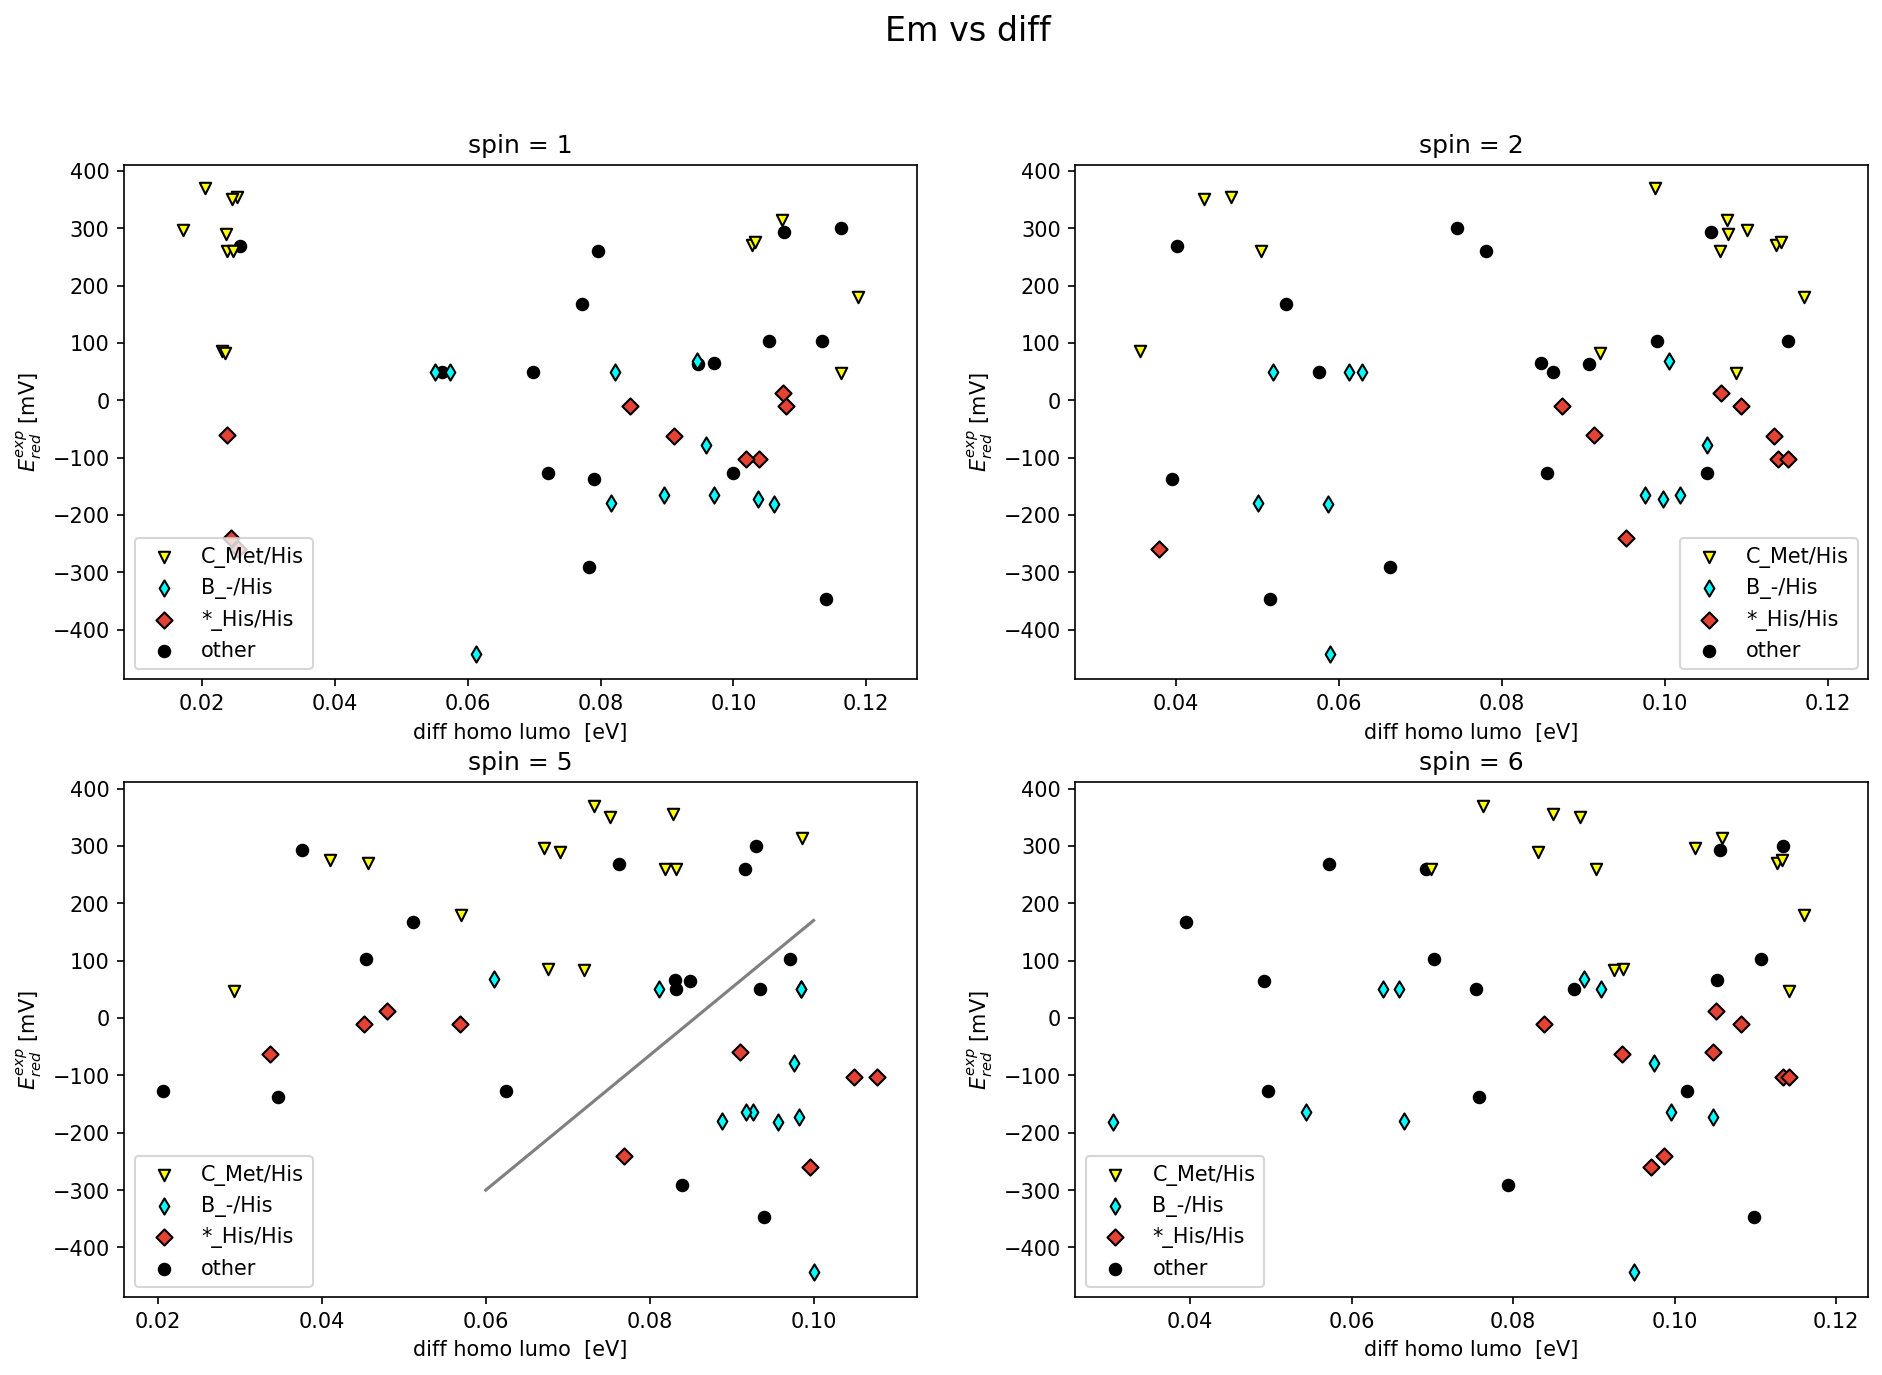

In [104]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    #df= df_work2[df_work2[f"diff_{str(s)}_nbo"]>0.04]
    df = df_work2
    fig.suptitle('Em vs diff', fontsize=16)
    plt.subplot(2,2,i)
    plt.ylabel(redox)
    plt.title(f"spin = {s}")
    plt.xlabel(f"diff homo lumo {Energie}")    
    scatterkat(df,f"diff_{str(s)}_nbo","Em_lit",Kategorie)
    plt.legend()
    if s ==5:
        plt.plot([0.06,0.1], [-300,170], c = "grey")
    
fig.savefig(f"{plots}Em_diff.png")        

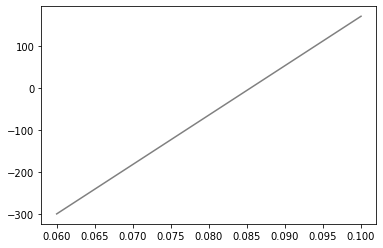

In [105]:
plt.plot([0.06,0.1], [-300,170], c = "grey")

### clusteranalyse fpr diff vs emlit

In [106]:
x = np.array([0.06,0.1]).reshape(-1, 1)
y = np.array([-300,170]).reshape(-1, 1)
model = LinearRegression()
model.fit(x,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

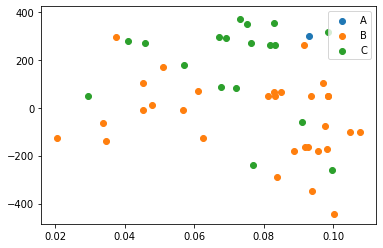

In [107]:
df  = df_work2.copy()
for H  in ["A","B","C"]:
    df  = df_work2.copy()    
    df = df[df["Hemetyp"]==H]
    plt.scatter(df["diff_5_nbo"], df["Em_lit"],label=H)
plt.legend()

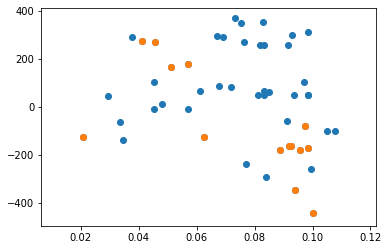

In [108]:
df  = df_work2.copy()
plt.scatter(df["diff_5_nbo"], df["Em_lit"])

df = df[df["ud"]=="uu"]
plt.scatter(df["diff_5_nbo"], df["Em_lit"])


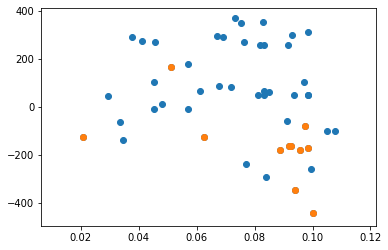

In [109]:
df  = df_work2.copy()
plt.scatter(df["diff_5_nbo"], df["Em_lit"])
df = df[df["Hemetyp"] == "B"]
df = df[df["ud"] =="uu"]
plt.scatter(df["diff_5_nbo"], df["Em_lit"])

df  = df_work2.copy()




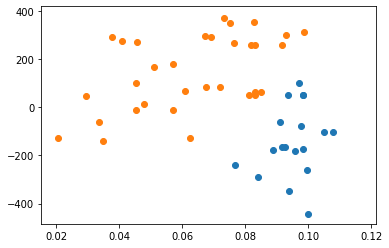

In [110]:
df  = df_work2.copy()

df["cluster"] = [(model.predict([[d]])>e)[0][0] for d,e in zip(df["diff_5_nbo"], df["Em_lit"])]
#plt.scatter(df["diff_5_nbo"], df["Em_lit"])
df1 = df[df["cluster"]]
plt.scatter(df1["diff_5_nbo"], df1["Em_lit"])
df2 = df[df["cluster"]==False]
plt.scatter(df2["diff_5_nbo"], df2["Em_lit"])



In [111]:
df1[["ligup","ligdown","Hemetyp","ud"]]
#df1["ax_qn"].value_counts()

ligup ligdown Hemetyp  ud
PDB                           
1AW3   His     His       B  du
1F1C   His     His       C  du
1DJ1     -     His       B  uu
1JBQ   His     Cys       B  dd
1A6M   His      O2       B  ud
3CCX     -     His       B  uu
1CMQ     -     His       B  uu
1JP9   His       -       B  ud
1NSI   Arg     Cys       B  uu
1CCK     -     His       B  uu
1GU2   His     His       C  ud
1FHF     -     His       B  uu
1CMT     -     His       B  uu
1CCC     -     His       B  uu
1MZ4   His     His       C  du
1B5A   His     His       B  du
1JP6   His       -       B  ud
1EBT   His      CN       B  ud

In [112]:
df2[["ligup","ligdown","Hemetyp","ud"]]
#df2["ax_qn"].value_counts()

ligup ligdown Hemetyp  ud
PDB                           
1A6G   His      CO       B  ud
4MU8     -     His       C  du
1CRY   Met     His       C  du
1CXC   Met     His       C  du
1QPU   Met     His       B  uu
1V9Z   His     Met       B  dd
1A6K   His       -       B  ud
1EUE   His     His       B  dd
1JDL   Met     His       B  du
1DRM   His       -       B  ud
1YCC   Met     His       C  du
1CYO   His     His       B  dd
1CYI   Met     His       C  du
1GIW   Met     His       C  du
1C75   Met     His       C  du
451C   Met     His       C  uu
2CE0   Met     His       C  du
1FJ0   Met     His       C  du
1CPO   Cys       -       B  du
1CCG     -     IMD       B  uu
1MOH   His     HSH       B  ud
2PCB   Met     His       B  du
351C   Met     His       C  uu
1EHB   His     His       B  dd
1VB6   His     Met       B  dd
2V07   Met     His       C  du
1CCE     -       -       B  uu
1ES1   His     His       B  dd
1F1F   Met     His       C  du
6U97   Met     His       C  uu
1HRC   Met     His       C  du
2GSM     -     His       A  du

In [113]:
df1["ax_ql"].value_counts()

-/His      9
His/His    5
CN/His     1
His/O2     1
Cys/His    1
Arg/Cys    1
Name: ax_ql, dtype: int64

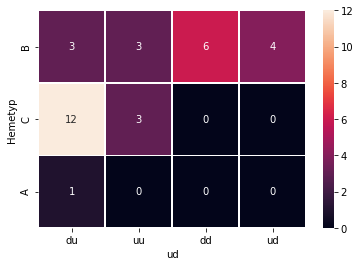

In [114]:
hashmap(df2,"ud","Hemetyp")

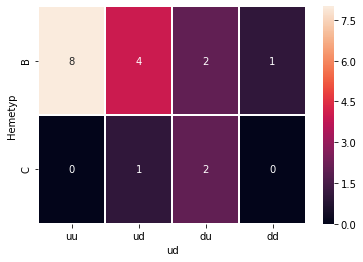

In [115]:
hashmap(df1,"ud","Hemetyp")

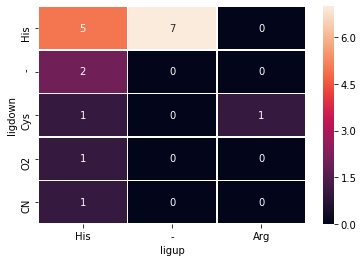

In [116]:
hashmap(df1,"ligup","ligdown")

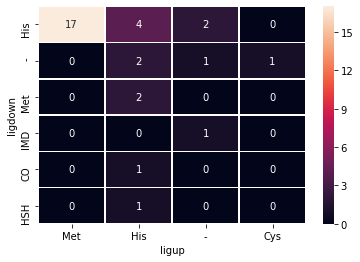

In [117]:
hashmap(df2,"ligup","ligdown")

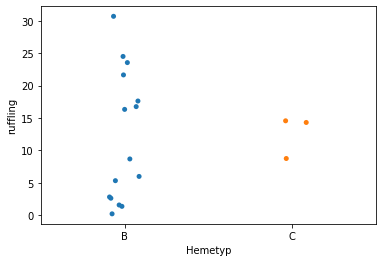

In [118]:
sns.stripplot(data=df1,y = "ruffling",x = "Hemetyp")

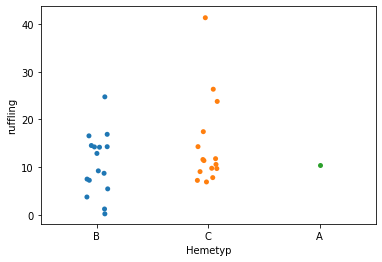

In [119]:
sns.stripplot(data=df2,y = "ruffling",x = "Hemetyp")

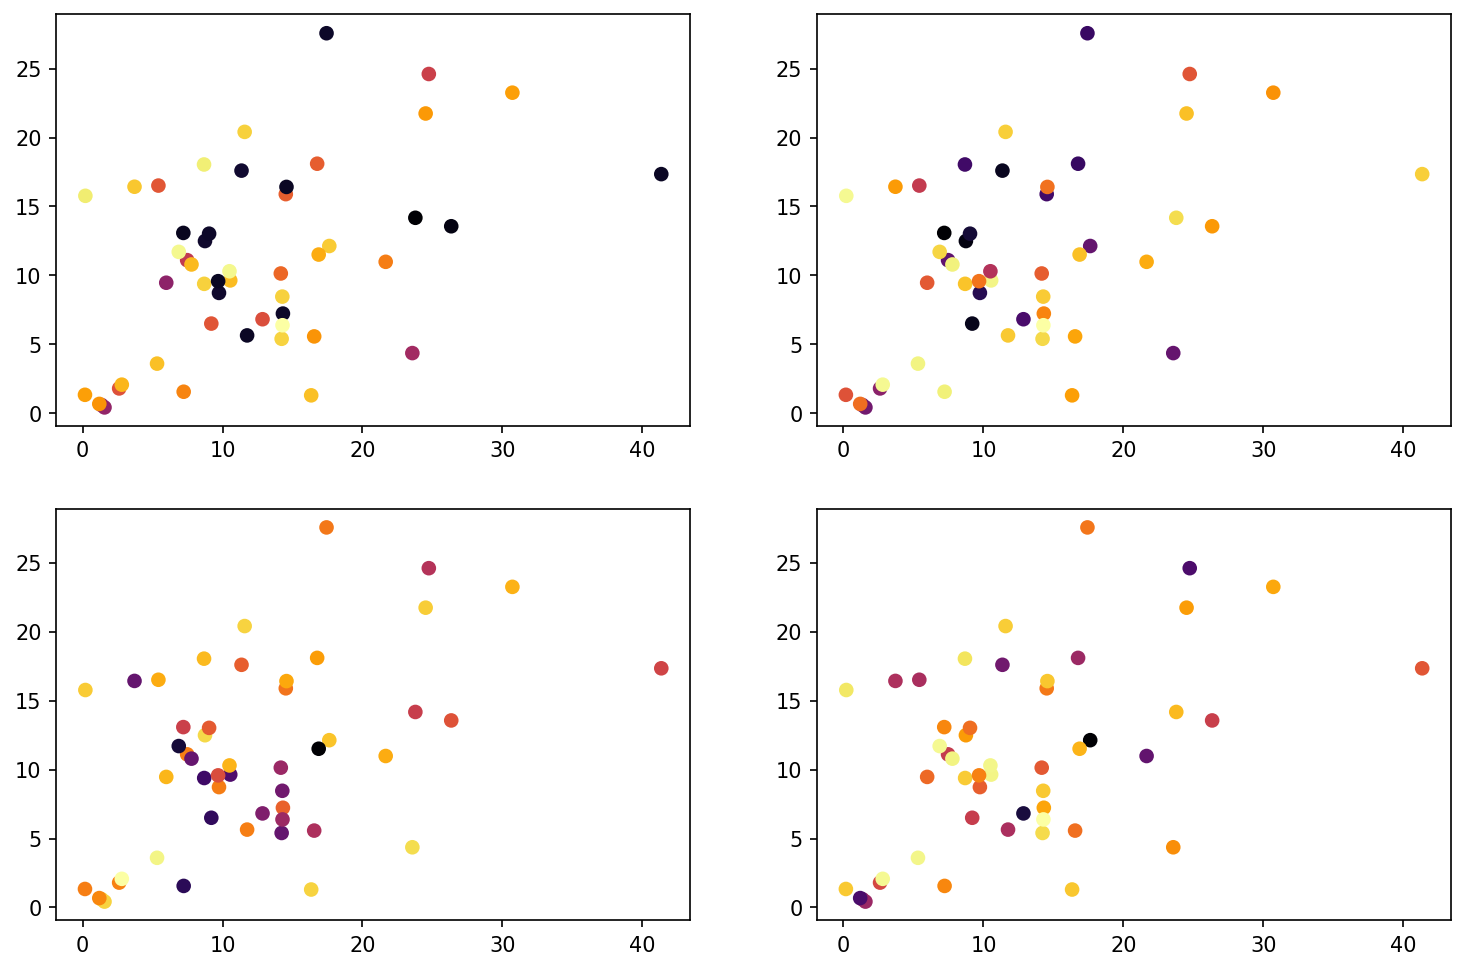

In [120]:
plt.figure(dpi=150, figsize=[12,8])
df = df_work2
for i,s in zip([1,2,3,4],[1,2,5,6]):
    plt.subplot(2,2,i)
    plt.scatter(df["ruffling"], df["saddling"] , c = df[f"diff_{str(s)}_nbo"] ,cmap =cmap1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

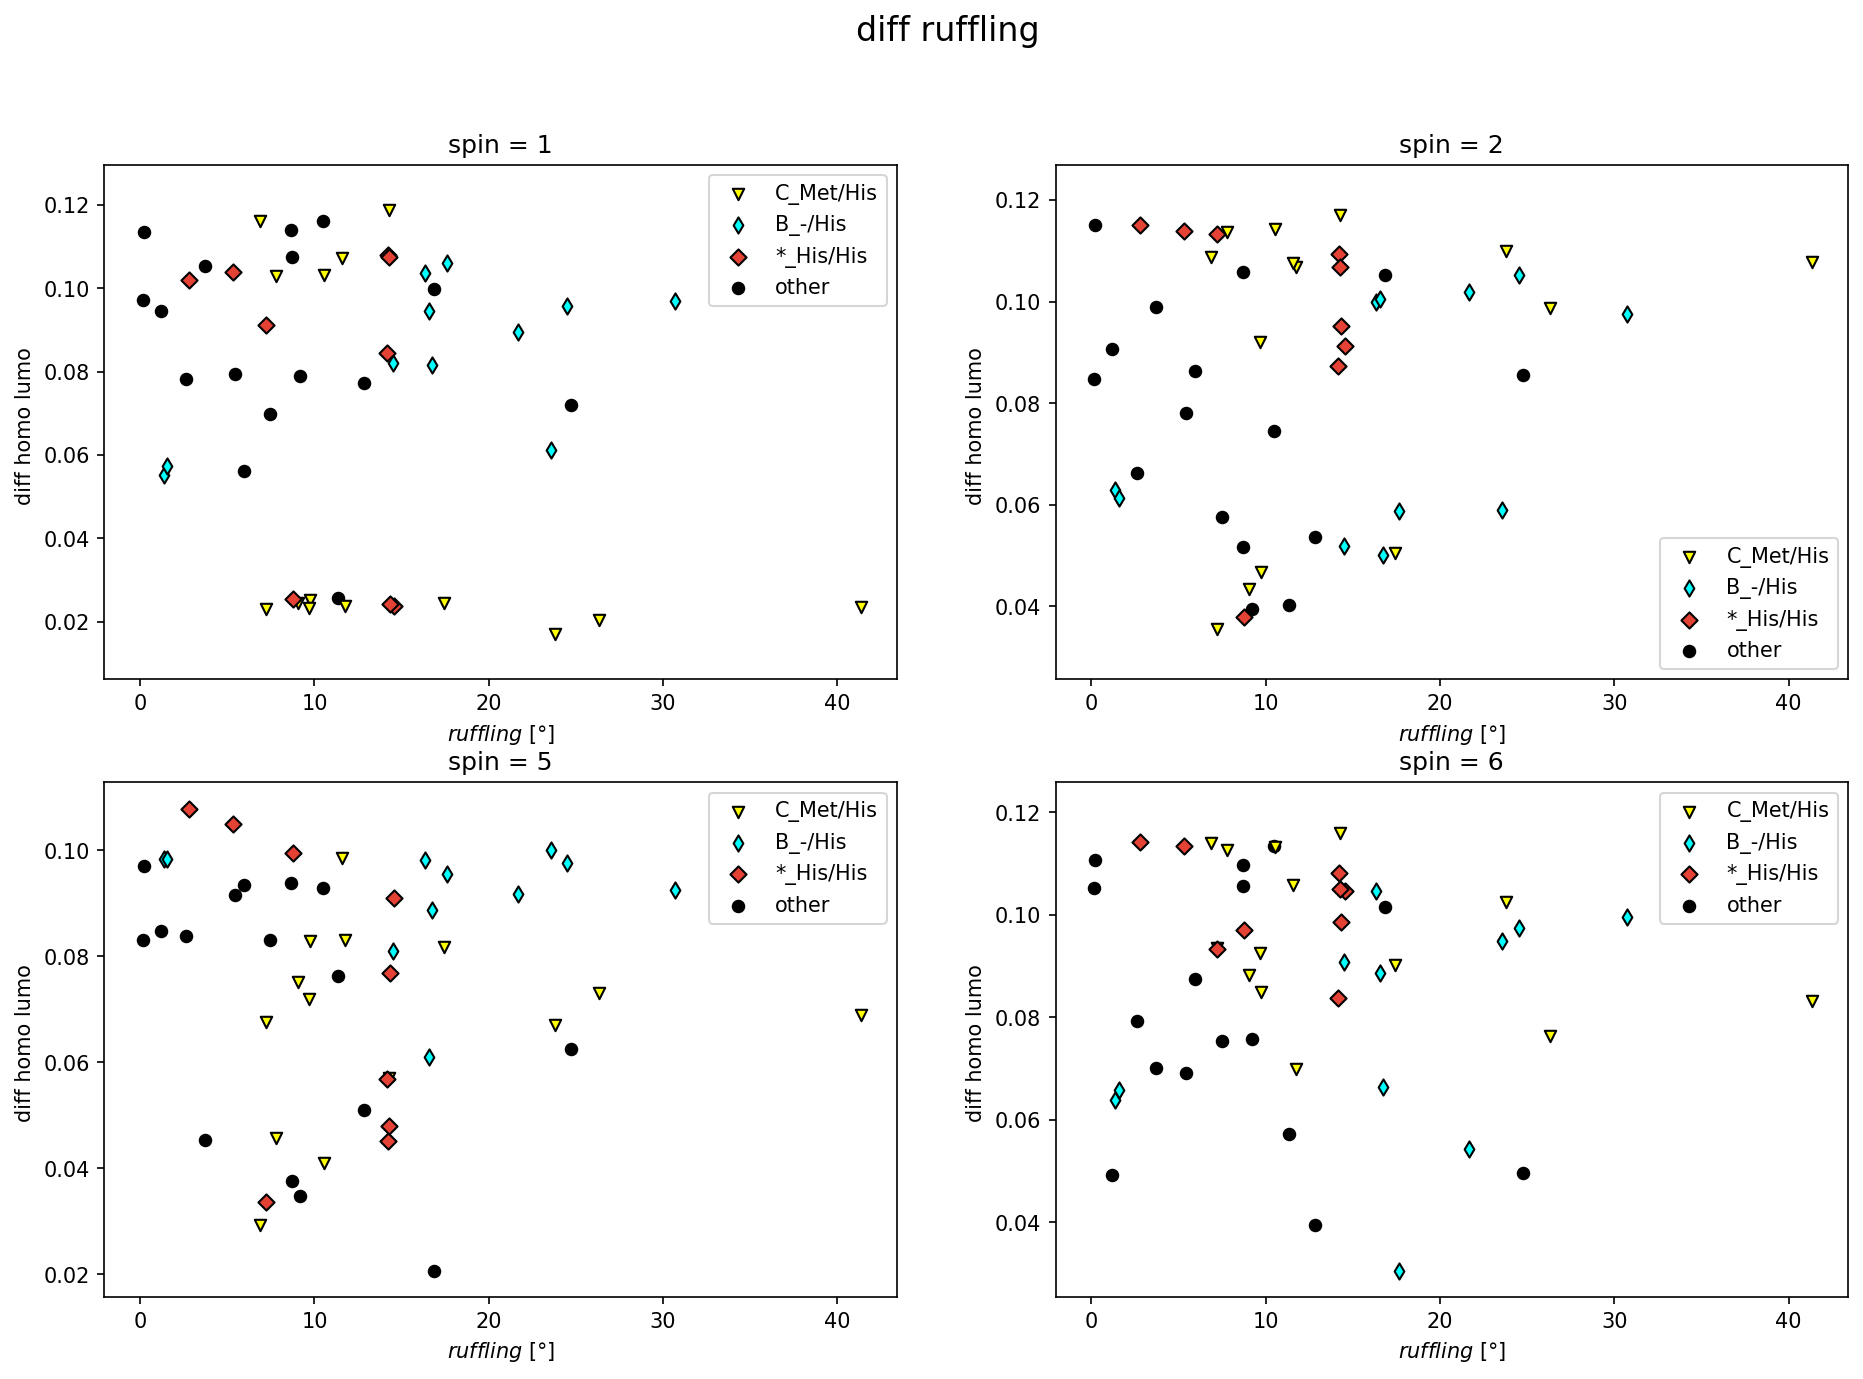

In [121]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    df= df_work2[df_work2[f"diff_{str(s)}_nbo"]>0.00]
    fig.suptitle('diff ruffling', fontsize=16)

    plt.subplot(2,2,i)
    scatterkat(df, "ruffling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"spin = {s}")

    plt.ylabel("diff homo lumo ")    
    plt.xlabel(dihedruf)
    plt.legend()
fig.savefig(f"{plots}diff_ruffling.png")        

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


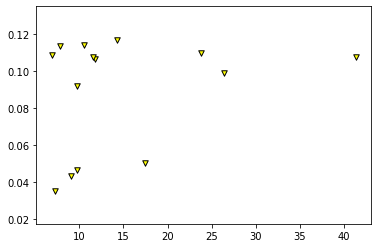

In [122]:
df= df_work2.copy()
df = df[df["Kategorie2"]==CHM]
scatterkat(df,"ruffling","diff_2_nbo",Kategorie)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

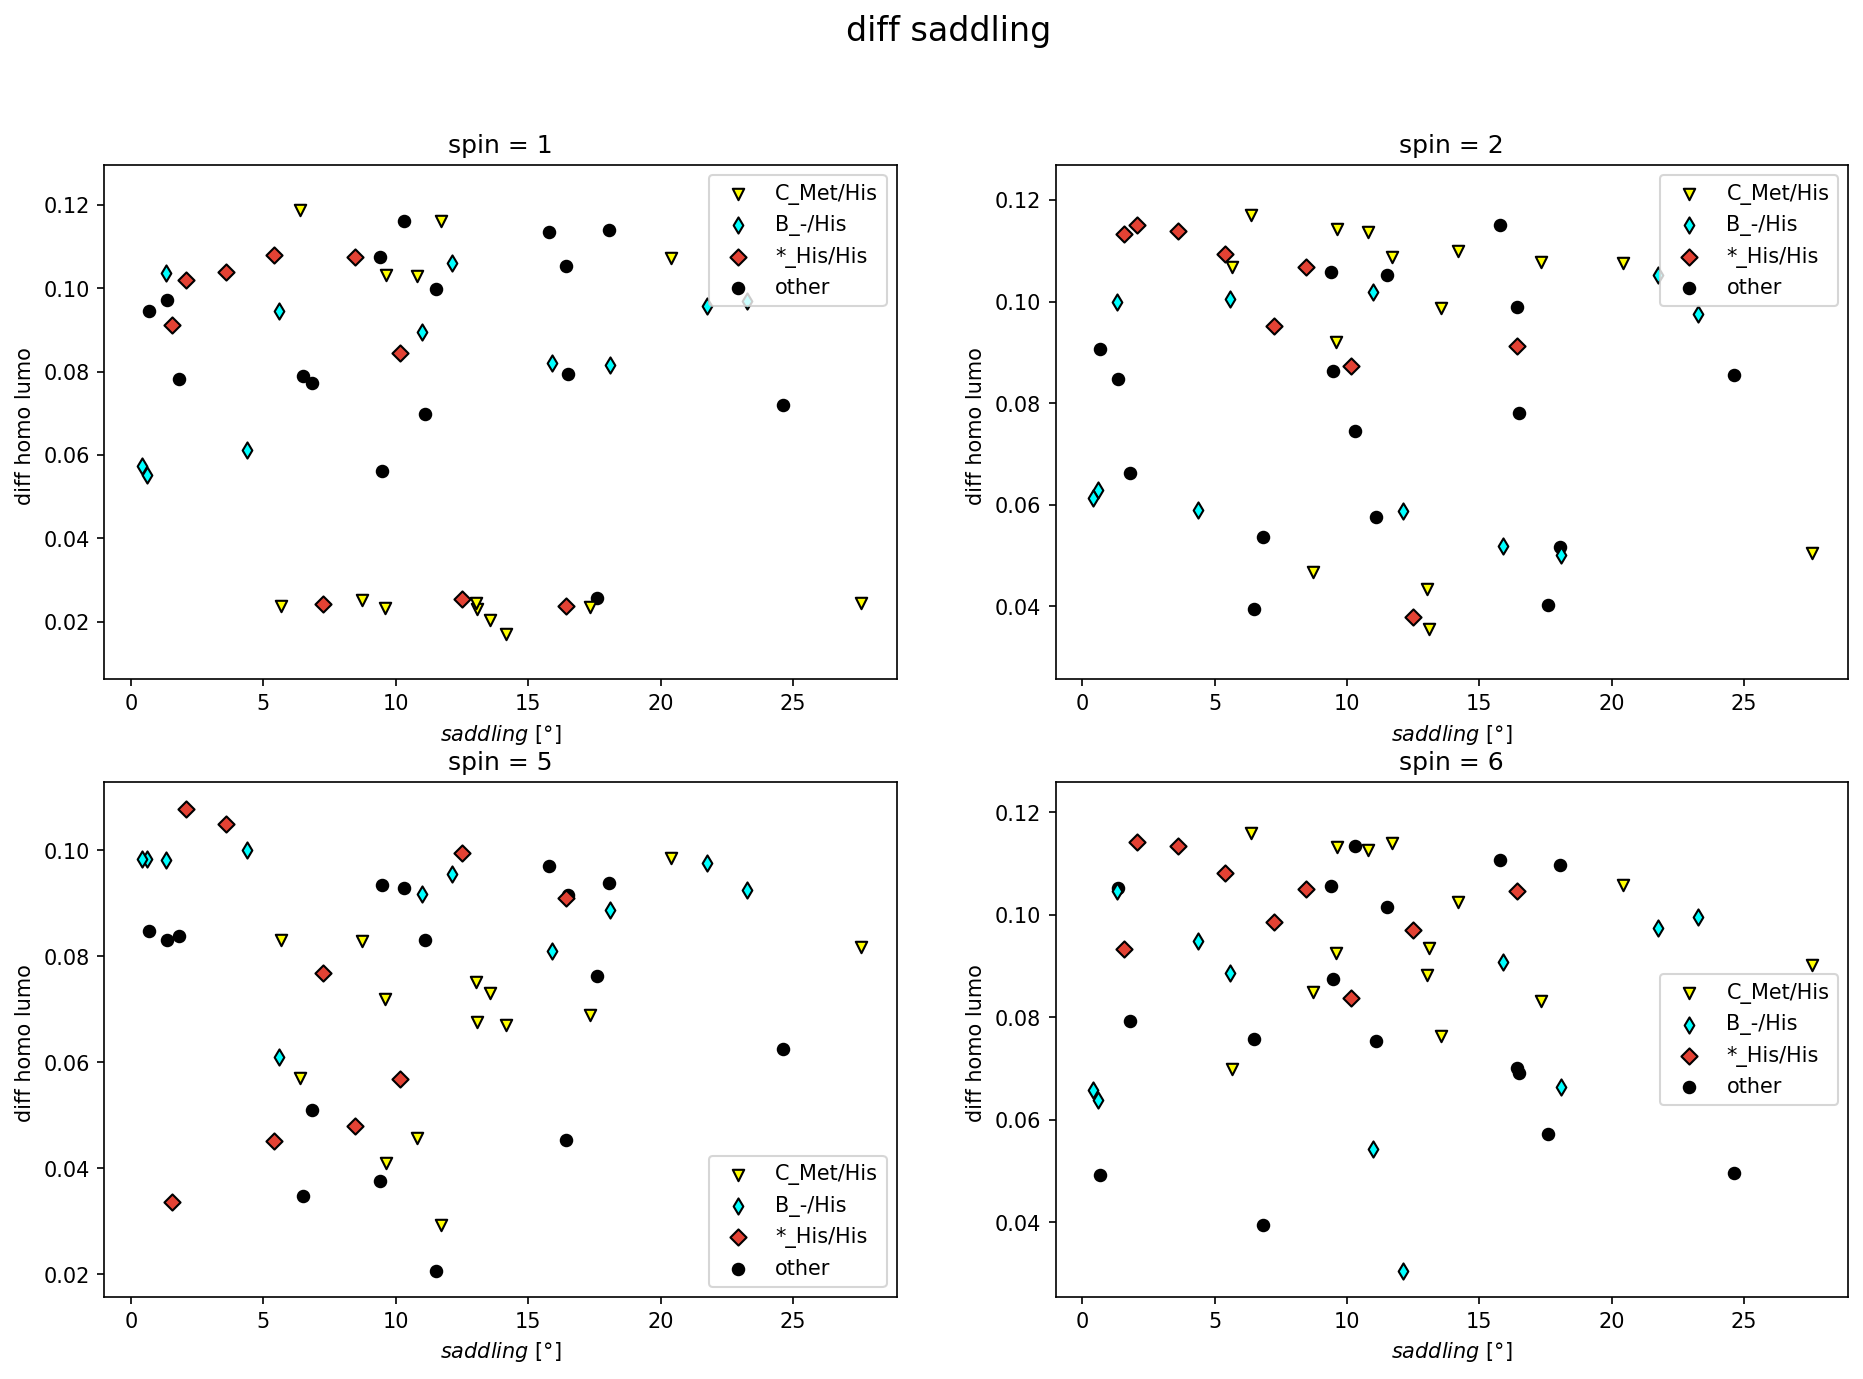

In [123]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    df= df_work2[df_work2[f"diff_{str(s)}_nbo"]>0.00]
    fig.suptitle('diff saddling', fontsize=16)

    plt.subplot(2,2,i)
    scatterkat(df, "saddling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"spin = {s}")
    plt.legend()
    plt.ylabel("diff homo lumo ")    
    plt.xlabel(dihedsad)
fig.savefig(f"{plots}diff_saddling.png")    

In [124]:
plots

'/home/hagen/Masterarbeit/Verteidigung/plots/'

In [125]:
df_work2["Kategorie2"].value_counts()

other        16
C_Met/His    14
B_-/His      11
*_His/His     9
Name: Kategorie2, dtype: int64

/home/hagen/anaconda3/envs/KLeich/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hagen/anaconda3/envs/KLeich/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hagen/anaconda3/envs/KLeich/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previ

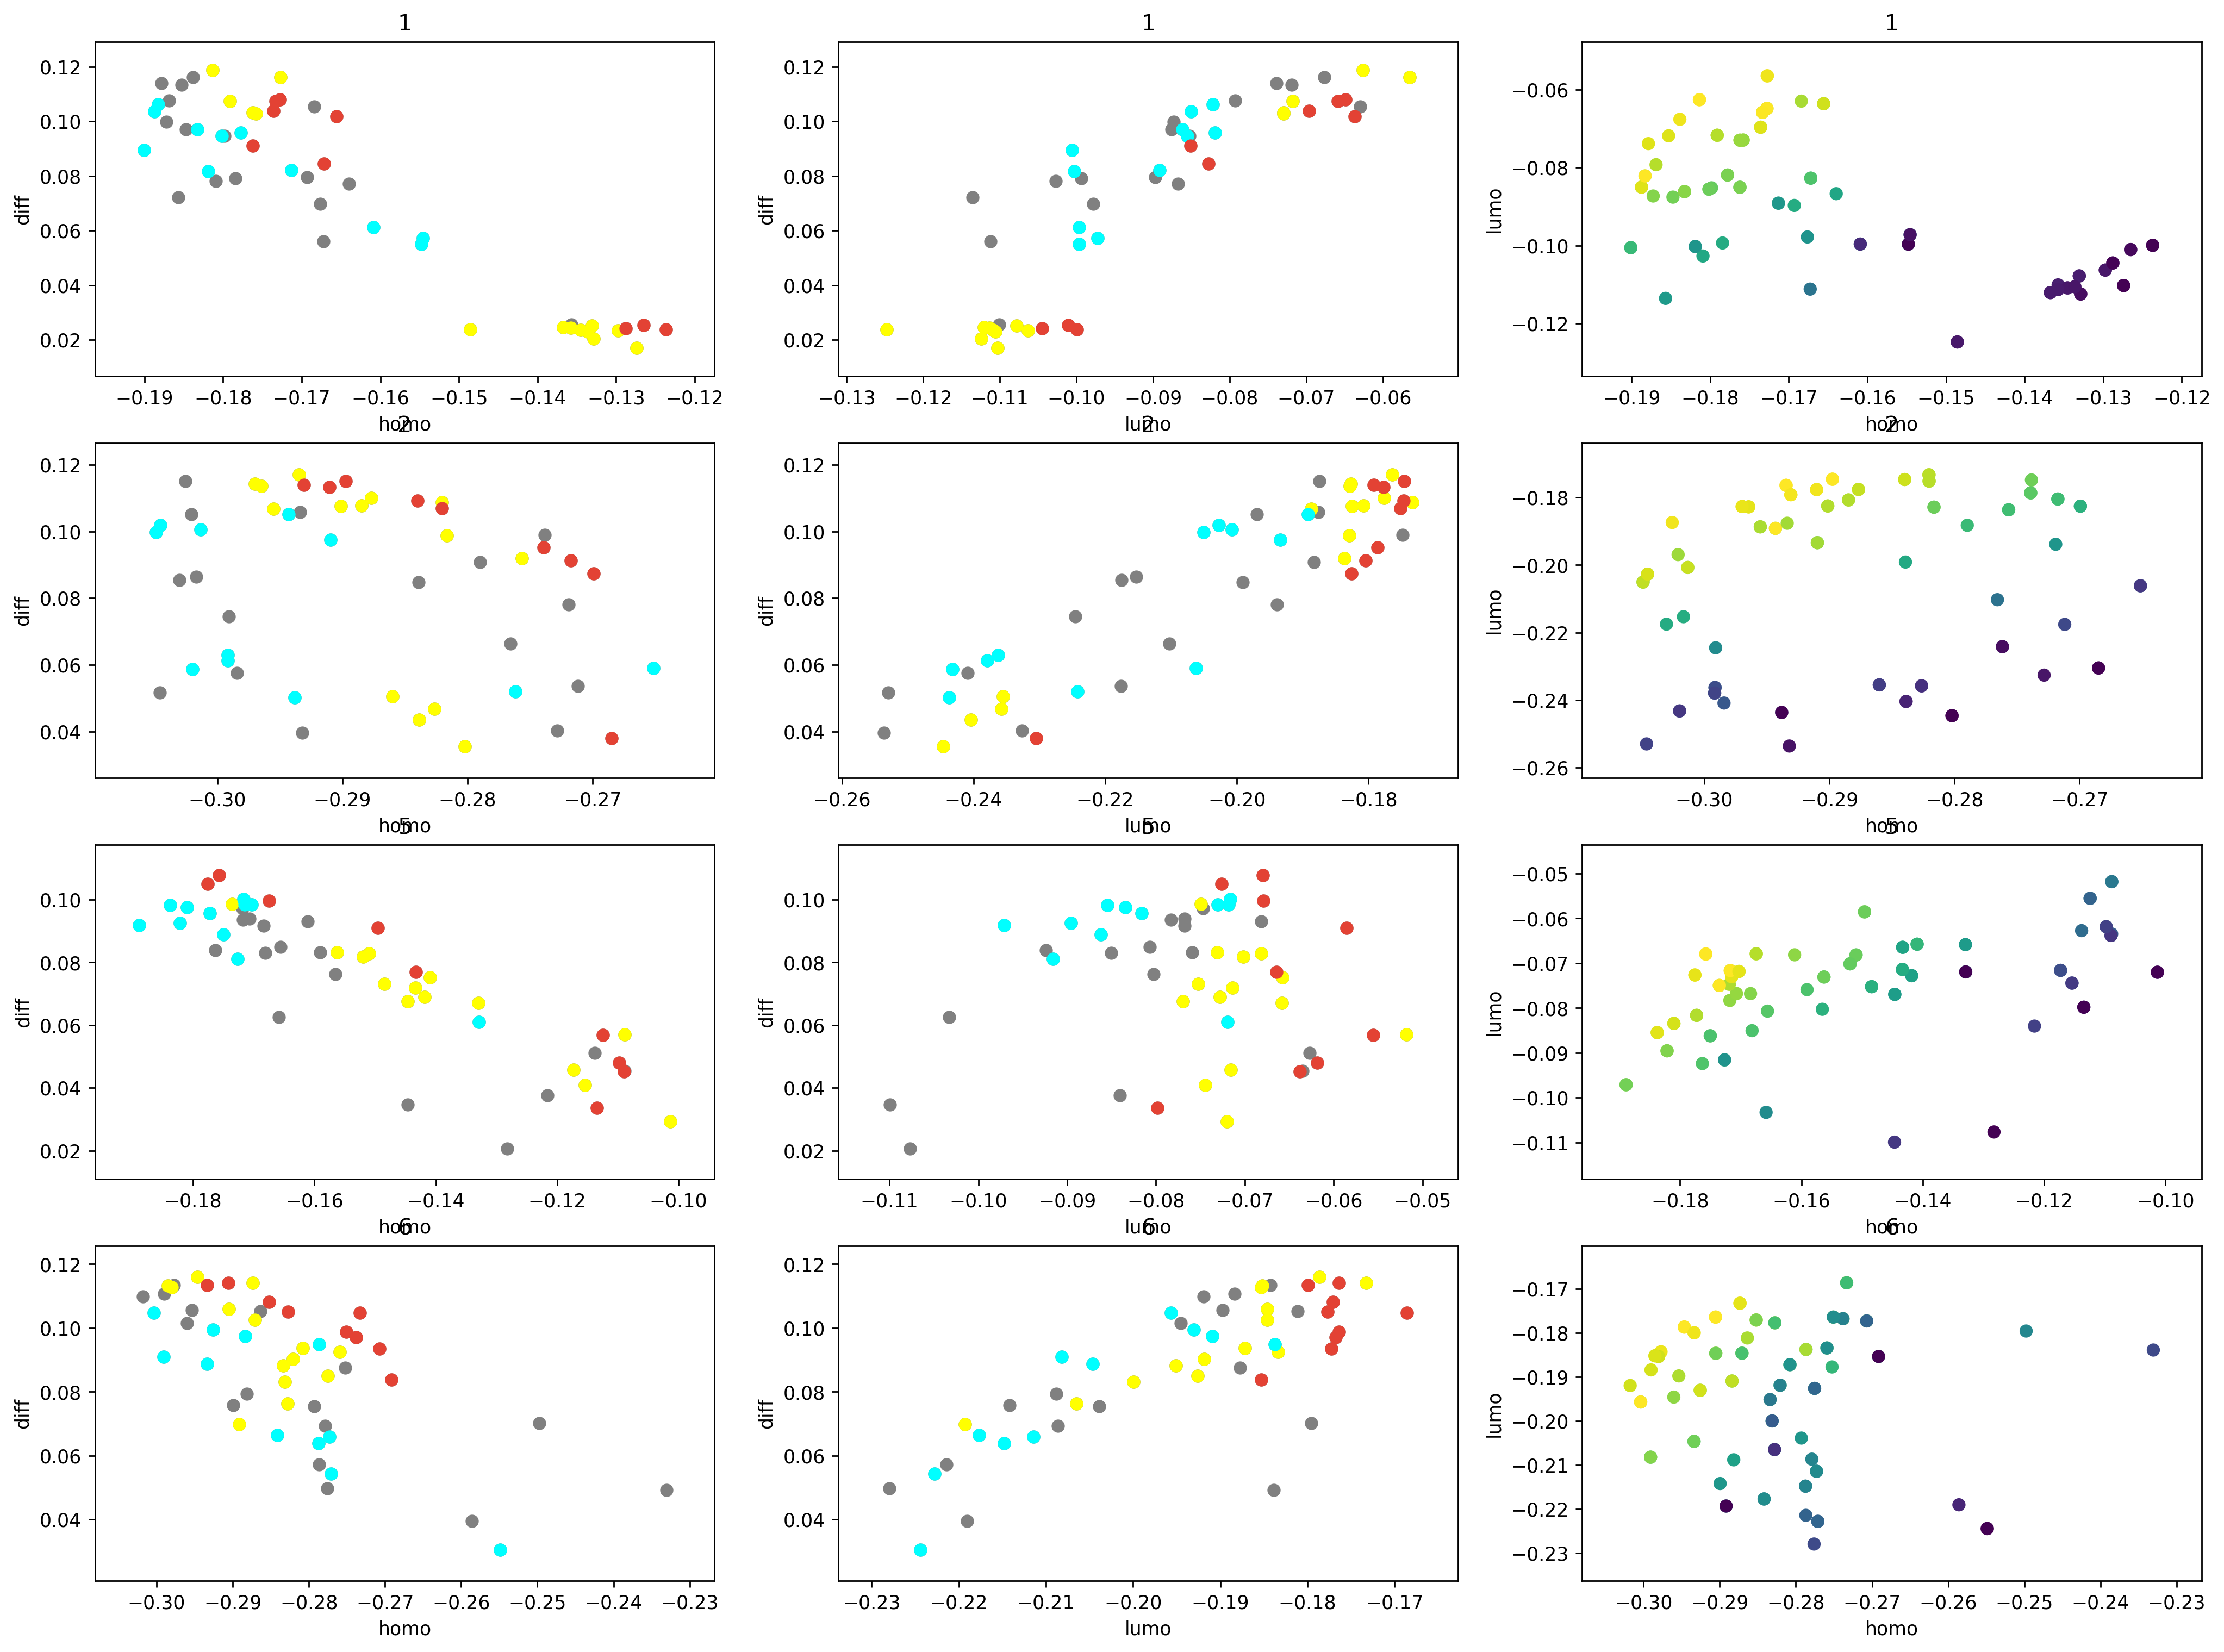

In [126]:
df = df_work2.copy()
plt.figure(dpi=250,figsize=[20,15])





for z,s in zip( [1,4,7,10]  ,[1,2,5,6]):
    plt.subplot(4,3,z+1)
    plt.xlabel("lumo")    
    plt.ylabel("diff")
    plt.title(f"{s}")

    plt.scatter(df[f"lumo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = "grey")

    plt.subplot(4,3,z)
    plt.xlabel("homo")    
    plt.ylabel("diff")
    plt.title(f"{s}")

    plt.scatter(df[f"homo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = "grey")# df["diff_5_nbo"])


    plt.subplot(4,3,z+2)
    plt.xlabel("homo")    
    plt.ylabel("lumo")
    plt.title(f"{s}")

    plt.scatter(df[f"homo_{str(s)}_nbo"],df[f"lumo_{str(s)}_nbo"], c = df[f"diff_{str(s)}_nbo"])# df["diff_5_nbo"])    










for kat in Kategorie:
    df = df_work2.copy()
    
    df = df[df["Kategorie2"] == kat]


    for z,s in zip( [1,4,7,10]  ,[1,2,5,6]):
        plt.subplot(4,3,z+1)
        plt.xlabel("lumo")    
        plt.ylabel("diff")
        plt.title(f"{s}")

        plt.scatter(df[f"lumo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = Colorbar[kat])

        plt.subplot(4,3,z)
        plt.xlabel("homo")    
        plt.ylabel("diff")
        plt.title(f"{s}")

        plt.scatter(df[f"homo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = Colorbar[kat])# df["diff_5_nbo"])


        plt.subplot(4,3,z+2)
        plt.xlabel("homo")    
        plt.ylabel("lumo")
        plt.title(f"{s}")

        plt.scatter(df[f"homo_{str(s)}_nbo"],df[f"lumo_{str(s)}_nbo"], c = df[f"diff_{str(s)}_nbo"])# df["diff_5_nbo"])    

#  Modelle

In [127]:
df = df_work2.copy()
X = df[['e_1_nbo', 'edisp_1_nbo', 'homo_1_nbo', 'lumo_1_nbo', 'chem_pot_1_nbo', 'diff_1_nbo', 'elekphil_1_nbo', 'dipole_1_nbo', "ruffling", "saddling"]]
Y = df[["Em_lit"]]
for i in range(6):
    X_train,X_test,y_train,y_test = train_test_split(X,Y)
    model = LinearRegression()
    model.fit(X,Y)
    y_pred = model.predict(X_test)
    print(model.score(X_test,y_test))

0.3579330404980219
0.4226855509964082
0.4144536830204578
0.4542142530077462
0.27964730010958017
0.053925164882342225


In [128]:
[i for i in df_work2.columns if "_1_nbo" in i]

['e_1_nbo',
 'edisp_1_nbo',
 'homo_1_nbo',
 'lumo_1_nbo',
 'chem_pot_1_nbo',
 'diff_1_nbo',
 'elekphil_1_nbo',
 'dipole_1_nbo',
 'qpole1_1_nbo',
 'qpole2_1_nbo',
 'qpole3_1_nbo',
 'qpole4_1_nbo']

In [129]:
[[i for i in df_work2.columns if "_6_nbo" in i]]

[['e_6_nbo',
  'edisp_6_nbo',
  'homo_6_nbo',
  'lumo_6_nbo',
  'chem_pot_6_nbo',
  'diff_6_nbo',
  'elekphil_6_nbo',
  'dipole_6_nbo',
  'qpole1_6_nbo',
  'qpole2_6_nbo',
  'qpole3_6_nbo',
  'qpole4_6_nbo']]

In [130]:
df_work2

ud Hemetyp  Em_lit ligup ligdown Elektrode    ax_qn    ax_ql  ax_qn_r  \
PDB                                                                           
1AW3  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1F1C  du       C  -260.0   His     His       NHE  His/His  His/His  His/His   
1DJ1  uu       B  -172.6     -     His       SHE    -/His    -/His    -/His   
1A6G  ud       B    50.0   His      CO       NHE   His/CO   CO/His   andere   
4MU8  du       C   269.0     -     His       SHE    -/His    -/His    -/His   
1JBQ  dd       B  -291.0   His     Cys       NHE  His/Cys  Cys/His   andere   
1CRY  du       C   296.0   Met     His       SHE  Met/His  His/Met  Met/His   
1A6M  ud       B    50.0   His      O2       NHE   His/O2   His/O2   andere   
3CCX  uu       B  -181.1     -     His       SHE    -/His    -/His    -/His   
1CXC  du       C   355.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CMQ  uu       B  -164.5     -     His       SHE    -/His    -/His    -/His   
1QPU  uu       B   168.0   Met     His       SHE  Met/His  His/Met  Met/His   
1JP9  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1V9Z  dd       B    65.5   His     Met       SHE  His/Met  His/Met   andere   
1A6K  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1EUE  dd       B   -63.0   His     His       SHE  His/His  His/His  His/His   
1NSI  uu       B  -347.0   Arg     Cys       NHE  Arg/Cys  Arg/Cys   andere   
1JDL  du       B   293.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CCK  uu       B  -178.7     -     His       SHE    -/His    -/His    -/His   
1DRM  ud       B    68.0   His       -       NHE    His/-    -/His    His/-   
1YCC  du       C   290.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CYO  dd       B   -10.0   His     His       SHE  His/His  His/His  His/His   
1GU2  ud       C   -60.0   His     His       NHE  His/His  His/His  His/His   
1CYI  du       C   370.0   Met     His       SHE  Met/His  His/Met  Met/His   
1FHF  uu       B  -443.0     -     His       SHE    -/His    -/His    -/His   
1CMT  uu       B  -164.5     -     His       SHE    -/His    -/His    -/His   
1GIW  du       C   260.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CCC  uu       B   -78.0     -     His       SHE    -/His    -/His    -/His   
1MZ4  du       C  -240.0   His     His       NHE  His/His  His/His  His/His   
1C75  du       C    47.0   Met     His       SHE  Met/His  His/Met  Met/His   
451C  uu       C   270.0   Met     His       SCE  Met/His  His/Met  Met/His   
2CE0  du       C    86.0   Met     His       SHE  Met/His  His/Met  Met/His   
1B5A  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1FJ0  du       C   350.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CPO  du       B  -138.0   Cys       -       NHE    Cys/-    -/Cys   andere   
1CCG  uu       B  -127.0     -     IMD       SHE    -/IMD    -/IMD   andere   
1MOH  ud       B   103.0   His     HSH       NHE  His/HSH  HSH/His   andere   
2PCB  du       B   260.0   Met     His       SHE  Met/His  His/Met  Met/His   
351C  uu       C   276.0   Met     His       SCE  Met/His  His/Met  Met/His   
1JP6  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1EHB  dd       B   -10.0   His     His       SHE  His/His  His/His  His/His   
1VB6  dd       B    63.9   His     Met       SHE  His/Met  His/Met   andere   
2V07  du       C    83.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CCE  uu       B  -127.0     -       -       SHE      -/-      -/-   andere   
1EBT  ud       B   103.0   His      CN       NHE   His/CN   CN/His   andere   
1ES1  dd       B    12.0   His     His       SHE  His/His  His/His  His/His   
1F1F  du       C   314.0   Met     His       SHE  Met/His  His/Met  Met/His   
6U97  uu       C   179.3   Met     His       NHE  Met/His  His/Met  Met/His   
1HRC  du       C   260.0   Met     His       SHE  Met/Hi

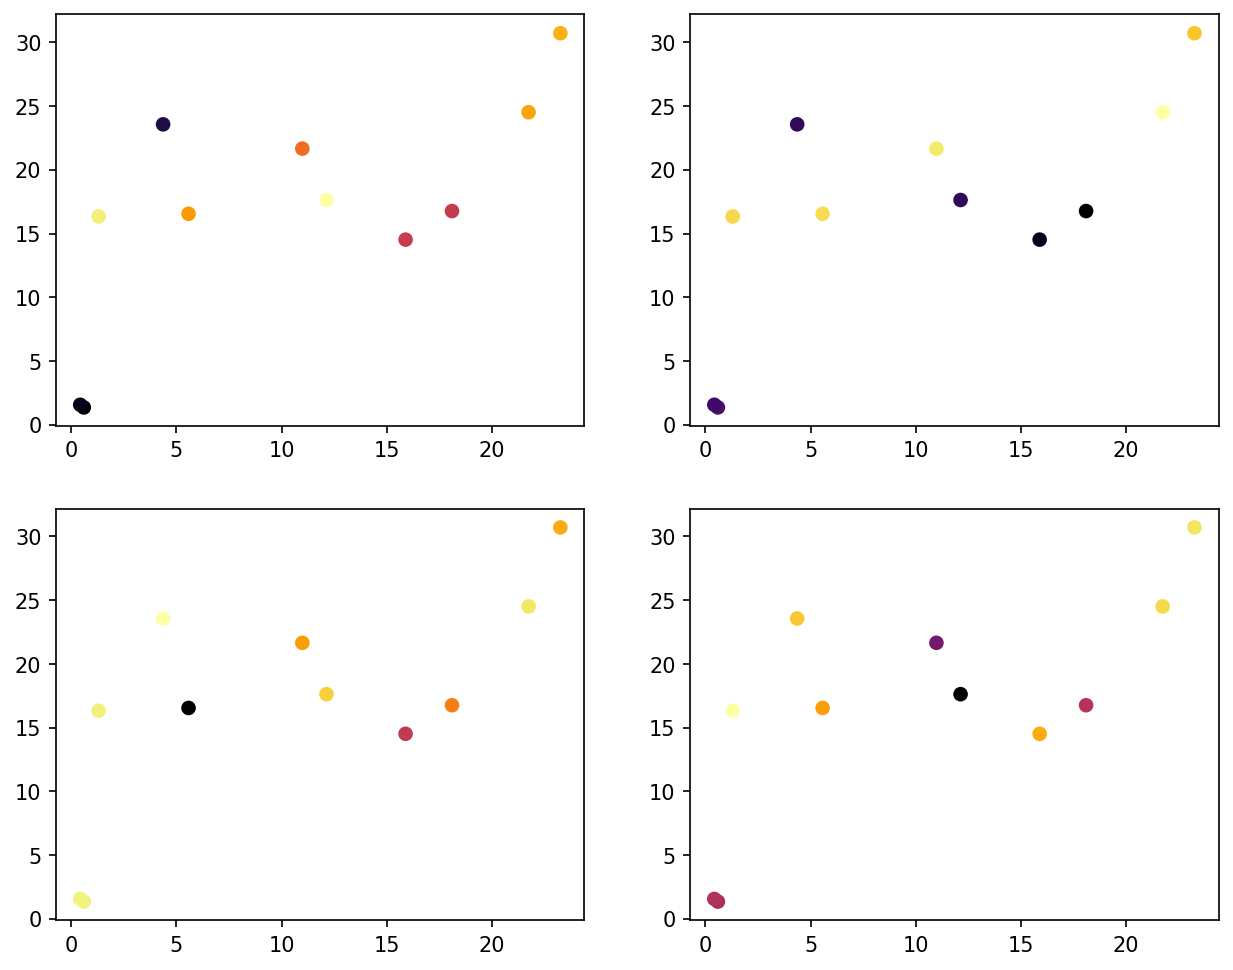

In [131]:
df  = df_work2.copy()
df = df[df[BHIS]==1]
fig = plt.figure(dpi = 150,figsize= [10,8])
for i,s in zip([1,2,3,4],[1,2,5,6]):
    plt.subplot(2,2,i)
    plt.scatter(df["saddling"],df["ruffling"],c = df[f"diff_{str(s)}_nbo"],cmap = cmap1)
    #plt.colorbar()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


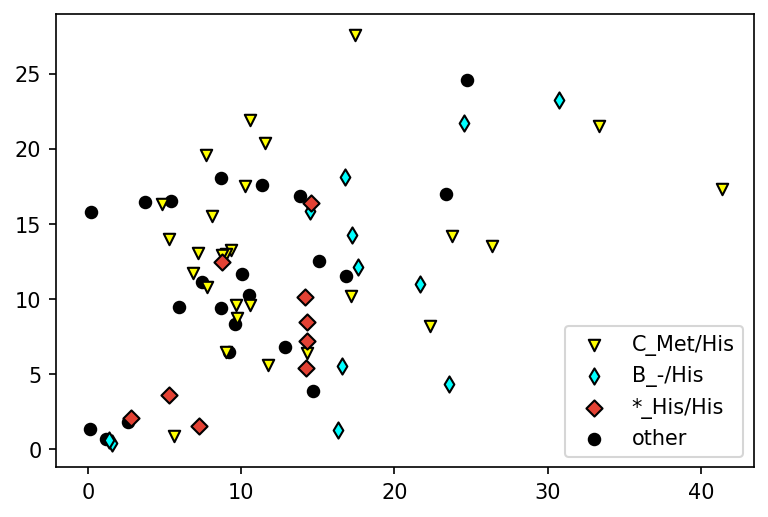

In [132]:
df  = df_work2.copy()
#df = df[df["HH"]==1]
fig = plt.figure(dpi = 150) #,figsize= [10,8])
#for i,s in zip([1,2,3,4],[1,2,5,6]):
 #   plt.subplot(2,2,i)
scatterkat(dflg,"ruffling","saddling",Kategorie)
plt.legend()

## Hauptkomponentenanalyse

### über den gesamten DataFrame

In [133]:

#string1("edisp_5_nbo")


df = pca_show(df_work2)
if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)

nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"HK{1+i} "] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}123.csv")
df2

noise variance:  0.4328581623827285
number of componentes:  6
[0.24962686 0.13853978 0.11645913 0.07935208 0.06151883 0.05345744]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1    HK1               HK2    HK2                 HK3    HK3   \
0  $edisp_{5}$  0.2375     $qpole3_{1}$  0.3208         $diff_{1}$  0.3037   
1  $edisp_{1}$  0.2375     $qpole3_{5}$  0.3172         $lumo_{1}$  0.2983   
2  $edisp_{2}$  0.2375     $qpole4_{1}$  0.3036     $elekphil_{1}$  0.2934   
3  $edisp_{6}$  0.2375     $qpole4_{5}$  0.2953         $diff_{2}$  0.2555   
4      $e_{2}$  0.2170     $qpole3_{6}$  0.2489         $homo_{1}$  0.2515   

                HK4    HK4                   HK5    HK5                  HK6  \
0      $qpole2_{5}$  0.2809           $homo_{6}$  0.3168        $qpole4_{2}$   
1      $qpole2_{1}$  0.2730       $chem pot_{6}$  0.2797        $qpole1_{2}$   
2      $qpole1_{1}$  0.2715                $ud $  0.2462          $diff_{5}$   
3      $qpole2_{6}$  0.2697         $dipole_{6}$  0.2371          $homo_{5}$   
4      $qpole1_{5}$  0.2693           $lumo_{5}$  0.2356          $ruffling$   

     HK6   
0  0.3161  
1  0.3119  
2  0.2590  
3  0.2363  
4  0.2200

### edisp  raus

In [134]:
df = pca_show(df_work2)
df.shape

noise variance:  0.4328581623827285
number of componentes:  6
[0.24962686 0.13853978 0.11645913 0.07935208 0.06151883 0.05345744]


(6, 64)

In [135]:
len(df)

6

In [136]:
df = df_work2[[c for c in df_work2.columns if True not in df_work2[c].isna().value_counts().index]]
df = df[[c for c in df.columns if df[c].dtypes in [float, int] ]]
dfpca1 = df

In [137]:
dfpca2 = dfpca1[[i for i in dfpca1.columns if "edisp" not in i  and not( "e_"  in i and "dipole" not in i)     ]].copy()
dfpca2["edisp"] = df_work2[[i for i in df_work2.columns if "edisp" in i]].mean(axis=1)
dfpca2["e"]  = df_work2[[i for i in df_work2.columns if "e_" in i and "dipole" not in i]].mean(axis= 1)

df_work4 = df_work2.copy()
df_work4["edisp"] = df_work2[[i for i in df_work2.columns if "edisp" in i]].mean(axis=1)
df_work4["e"]  = df_work2[[i for i in df_work2.columns if "e_" in i and "dipole" not in i]].mean(axis= 1)



In [138]:
df = pca_show(dfpca2, num_comp= 5)
if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)
nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"{np.round(variance_ratio.loc[i],4)}"] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}PCA_generell.csv",index=False)
df2

noise variance:  0.47121495720807166
number of componentes:  5
[0.20159008 0.15016224 0.12354966 0.08684593 0.06677031]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1  0.2016              HK2  0.1502                HK3  0.1235  \
0         $edisp$  0.2366     $qpole3_{1}$  0.3044         $diff_{1}$  0.3343   
1  $chem pot_{1}$  0.2250     $qpole3_{5}$  0.3019     $elekphil_{1}$  0.3248   
2  $chem pot_{2}$  0.2153     $qpole4_{1}$  0.2942         $homo_{1}$  0.3073   
3      $edif-2-5$  0.2150     $qpole4_{5}$  0.2904         $lumo_{1}$  0.2911   
4             $e$  0.2022     $qpole3_{6}$  0.2197         $edif-6-1$  0.2312   

                HK4  0.0868                  HK5  0.0668  
0      $qpole2_{5}$  0.2922           $homo_{6}$  0.3230  
1      $qpole2_{6}$  0.2884         $dipole_{6}$  0.2561  
2      $qpole2_{2}$  0.2864                $ud $  0.2549  
3      $qpole2_{1}$  0.2859       $chem pot_{6}$  0.2528  
4      $qpole1_{6}$  0.2857           $ruffling$  0.2147

In [139]:
dfpca3 = dfpca2[[c for c in dfpca2.columns if not any(i in c for i in ["qpol","dipol","chem_pot","diff","elekphil"])]]


dfpca3.head()

Em_lit  *_His/His  B_-/His  C_Met/His  du   uu   ud   dd    ruffling  \
PDB                                                                          
1AW3  -102.0          1        0          0    1    0    0    0   5.321410   
1F1C  -260.0          1        0          0    1    0    0    0   8.746073   
1DJ1  -172.6          0        1          0    0    1    0    0  16.334332   
1A6G    50.0          0        0          0    0    0    1    0   7.471468   
4MU8   269.0          0        0          0    1    0    0    0  11.356138   

       saddling  ...  homo_5_nbo  lumo_5_nbo  homo_6_nbo  lumo_6_nbo  \
PDB              ...                                                   
1AW3   3.600227  ...    -0.17755    -0.07264    -0.29336    -0.17995   
1F1C  12.490538  ...    -0.16744    -0.06790    -0.27381    -0.17675   
1DJ1   1.300042  ...    -0.18376    -0.08549    -0.30038    -0.19567   
1A6G  11.105041  ...    -0.15907    -0.07591    -0.27928    -0.20387   
4MU8  17.598387  ...    -0.15655    -0.08029    -0.27869    -0.22142   

      edif-2-1  edif-2-5  edif-6-1  edif-6-5      edisp            e  
PDB                                                                   
1AW3  0.174495  0.158217  0.180812  0.164535 -89.614957 -3627.586852  
1F1C  0.156362  0.200516  0.117515  0.161669 -90.087653 -3628.713526  
1DJ1  0.220645  0.225211  0.196823  0.201388 -78.632527 -3438.500593  
1A6G  0.185926  0.164437  0.232666  0.211177 -81.291268 -3475.361706  
4MU8  0.167708  0.188829  0.153440  0.174561 -81.381414 -3439.587872  

[5 rows x 24 columns]

In [140]:
df = pca_show(dfpca3, num_comp= 5)
if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)
nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"{np.round(variance_ratio.loc[i],4)}"] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}PCA2.csv",index=False)
df2

noise variance:  0.38894867751737616
number of componentes:  5
[0.2919596  0.15564838 0.10643385 0.07837073 0.06582809]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1   0.292            HK2  0.1556            HK3  0.1064      \
0     $edisp$  0.3413     $lumo_{1}$  0.4238       $C\_{MH$  0.3301       
1         $e$  0.3054     $homo_{1}$  0.3228          $uu $  0.3252       
2  $edif-2-5$  0.2813          $dd $  0.2941     $homo_{6}$  0.3157       
3   $B\_{His$  0.2585          $du $  0.2765       $HisHis$  0.3019       
4  $edif-6-5$  0.2543     $edif-6-1$  0.2650     $homo_{2}$  0.2662       

          HK4  0.0784              HK5  0.0658  
0  $ruffling$  0.4278       $homo_{6}$  0.5188  
1        $Em$  0.3669            $ud $  0.3808  
2  $edif-6-1$  0.3214       $homo_{2}$  0.3220  
3    $HisHis$  0.3014       $ruffling$  0.3015  
4  $edif-6-5$  0.2880       $edif-6-1$  0.2670

In [141]:
df2.iloc[-2,0]

'$B\\_{His$'

In [142]:
a =df2.iloc[-1,-2]
def ab(ff):
    return f"edif {str(ff[-4])}-{str(ff[-2])}"
ab(a)

'edif 6-1'

In [143]:
pd.DataFrame({1:["edif(6-1)",df2.iloc[-1,-2]]})

1
0   edif(6-1)
1  $edif-6-1$

In [144]:
f"{plotab}PCA2.csv"

'/home/hagen/Masterarbeit/Verteidigung/plots/tables/PCA2.csv'

In [145]:
dfpca4 = dfpca3[[c for c in dfpca3.columns if  not any(i in c for i in [HH,BHIS,CHM,"ud ","dd ","du ", "uu"]) ]]
df = pca_show(dfpca4, num_comp= 5)

if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)

nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"{np.round(variance_ratio.loc[i],4)}"] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]

    
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}PCA3.csv",index=False)
df2

noise variance:  0.3301365796988617
number of componentes:  5
[0.32862786 0.18176291 0.09918944 0.08838336 0.07365961]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1  0.3286            HK2  0.1818            HK3  0.0992      \
0     $edisp$  0.3767     $lumo_{1}$  0.5188     $homo_{6}$  0.6013       
1  $edif-2-5$  0.3342     $homo_{1}$  0.4277     $ruffling$  0.4245       
2         $e$  0.3316     $edif-6-1$  0.3637     $edif-6-5$  0.3157       
3  $edif-6-5$  0.3086     $edif-2-1$  0.3371     $homo_{2}$  0.3112       
4  $lumo_{5}$  0.2909     $lumo_{2}$  0.2717     $saddling$  0.3004       

          HK4  0.0884              HK5  0.0737  
0  $saddling$  0.4887             $Em$  0.5009  
1        $Em$  0.4412       $ruffling$  0.4467  
2  $edif-6-1$  0.3947       $homo_{2}$  0.3933  
3  $ruffling$  0.3425       $homo_{6}$  0.3048  
4  $lumo_{6}$  0.2480       $lumo_{2}$  0.2591

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


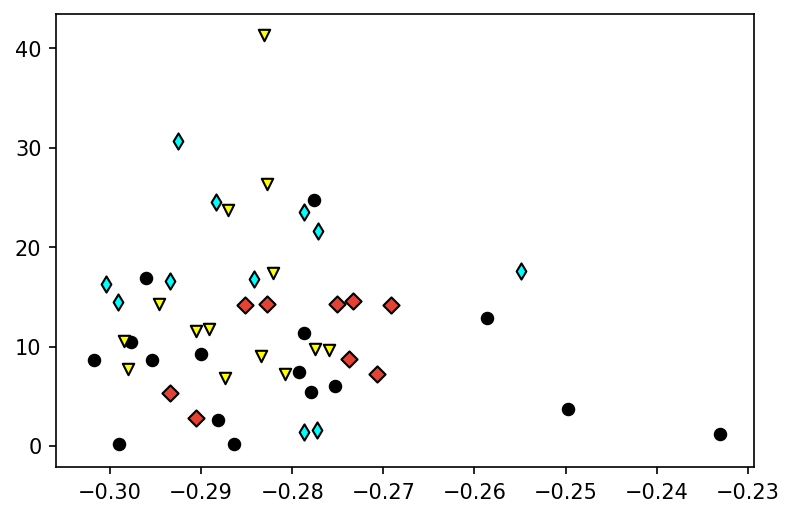

In [146]:
plt.figure(dpi=150)
scatterkat(df_work2,"homo_6_nbo","ruffling",Kategorie)

In [147]:
[ i for i in dfpca2.columns if i not in list(dfpca3.columns) ]

['chem_pot_1_nbo',
 'diff_1_nbo',
 'elekphil_1_nbo',
 'dipole_1_nbo',
 'qpole1_1_nbo',
 'qpole2_1_nbo',
 'qpole3_1_nbo',
 'qpole4_1_nbo',
 'chem_pot_2_nbo',
 'diff_2_nbo',
 'elekphil_2_nbo',
 'dipole_2_nbo',
 'qpole1_2_nbo',
 'qpole2_2_nbo',
 'qpole3_2_nbo',
 'qpole4_2_nbo',
 'chem_pot_5_nbo',
 'diff_5_nbo',
 'elekphil_5_nbo',
 'dipole_5_nbo',
 'qpole1_5_nbo',
 'qpole2_5_nbo',
 'qpole3_5_nbo',
 'qpole4_5_nbo',
 'chem_pot_6_nbo',
 'diff_6_nbo',
 'elekphil_6_nbo',
 'dipole_6_nbo',
 'qpole1_6_nbo',
 'qpole2_6_nbo',
 'qpole3_6_nbo',
 'qpole4_6_nbo']

In [148]:
[ i for i in dfpca3.columns if i not in list(dfpca4.columns) ]

['*_His/His', 'B_-/His', 'C_Met/His', 'du ', 'uu ', 'ud ', 'dd ']

In [149]:
[ i for i in dflg.columns if "nbo" not in i]

['PDB',
 'ud',
 'Hemetyp',
 'Em_lit',
 'ligup',
 'ligdown',
 'Elektrode',
 'ax_qn',
 'ax_ql',
 'ax_qn_r',
 'ax_ql_r',
 'ligup_r',
 'ligdown_r',
 'Kategorie',
 'HM',
 '*_His/His',
 'B_-/His',
 'C_Met/His',
 'Kategorie2',
 'du ',
 'uu ',
 'ud ',
 'dd ',
 'ruffling',
 'saddling',
 'axiale Liganden',
 '$E_{red}^{exp}$ [mV]',
 'Hämtyp',
 'Kategorie3']

## suche nach ruffling saddlnig Em_lit

In [150]:
dflg

PDB  ud Hemetyp  Em_lit ligup ligdown Elektrode    ax_qn  \
pdb                                                                       
1A6G          1A6G  ud       B    50.0   His      CO       NHE   His/CO   
1A6K          1A6K  ud       B    50.0   His       -       NHE    His/-   
1A6M          1A6M  ud       B    50.0   His      O2       NHE   His/O2   
1AW3          1AW3  du       B  -102.0   His     His       SHE  His/His   
1B5A          1B5A  du       B  -102.0   His     His       SHE  His/His   
...            ...  ..     ...     ...   ...     ...       ...      ...   
4MU8          4MU8  du       C   269.0     -     His       SHE    -/His   
6U97          6U97  uu       C   179.3   Met     His       NHE  Met/His   
2C1D_CSS  2C1D_CSS  dd       C  -432.0   CSS     His       NHE  CSS/His   
2GSM          2GSM  du       A   300.0     -     His       NHE    -/His   
1V9Z          1V9Z  dd       B    65.5   His     Met       SHE  His/Met   

            ax_ql  ax_qn_r  ... du  uu  ud  dd    ruffling   saddling  \
pdb                         ...                                         
1A6G       CO/His    other  ...   0   0   1   0   7.471468  11.105041   
1A6K        -/His    His/-  ...   0   0   1   0  14.519887  15.892665   
1A6M       His/O2    other  ...   0   0   1   0   5.978555   9.467277   
1AW3      His/His  His/His  ...   1   0   0   0   5.321410   3.600227   
1B5A      His/His  His/His  ...   1   0   0   0   2.802855   2.074508   
...           ...      ...  ...  ..  ..  ..  ..        ...        ...   
4MU8        -/His    -/His  ...   1   0   0   0  11.356138  17.598387   
6U97      His/Met  Met/His  ...   0   1   0   0  14.284085   6.383501   
2C1D_CSS  CSS/His    other  ...   0   0   0   1   9.577443   8.328911   
2GSM        -/His    -/His  ...   1   0   0   0  10.496312  10.298891   
1V9Z      His/Met    other  ...   0   0   0   1   0.170548   1.339240   

          axiale Liganden  $E_{red}^{exp}$ [mV] Hämtyp  Kategorie3  
pdb                                                                 
1A6G                other                  50.0      B       other  
1A6K                -/His                  50.0      B     B_-/His  
1A6M                other                  50.0      B       other  
1AW3              His/His                -102.0      B   *_His/His  
1B5A              His/His                -102.0      B   *_His/His  
...                   ...                   ...    ...         ...  
4MU8                -/His                 269.0      C       other  
6U97              His/Met                 179.3      C   C_Met/His  
2C1D_CSS            other                -432.0      C       other  
2GSM                -/His                 300.0      A       other  
1V9Z              His/Met                  65.5      B       other  

[70 rows x 29 columns]

### ruffling

In [151]:
'''dfbsp  = df_work2.loc[["6U97"]][Kategorie+ud]
dfbsp["..."] =["..."]

dfbsp2 = pd.DataFrame()
for c in dfbsp.columns:
    if c!="...":
    #print(c)
        dfbsp2[string1(c)] = dfbsp[c]
    else:
        dfbsp2[c] = dfbsp[c]
dfbsp2.to_csv(f"{plotab}bsp.csv")
dfbsp2'''

'dfbsp  = df_work2.loc[["6U97"]][Kategorie+ud]\ndfbsp["..."] =["..."]\n\ndfbsp2 = pd.DataFrame()\nfor c in dfbsp.columns:\n    if c!="...":\n    #print(c)\n        dfbsp2[string1(c)] = dfbsp[c]\n    else:\n        dfbsp2[c] = dfbsp[c]\ndfbsp2.to_csv(f"{plotab}bsp.csv")\ndfbsp2'

In [152]:
df_work2

ud Hemetyp  Em_lit ligup ligdown Elektrode    ax_qn    ax_ql  ax_qn_r  \
PDB                                                                           
1AW3  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1F1C  du       C  -260.0   His     His       NHE  His/His  His/His  His/His   
1DJ1  uu       B  -172.6     -     His       SHE    -/His    -/His    -/His   
1A6G  ud       B    50.0   His      CO       NHE   His/CO   CO/His   andere   
4MU8  du       C   269.0     -     His       SHE    -/His    -/His    -/His   
1JBQ  dd       B  -291.0   His     Cys       NHE  His/Cys  Cys/His   andere   
1CRY  du       C   296.0   Met     His       SHE  Met/His  His/Met  Met/His   
1A6M  ud       B    50.0   His      O2       NHE   His/O2   His/O2   andere   
3CCX  uu       B  -181.1     -     His       SHE    -/His    -/His    -/His   
1CXC  du       C   355.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CMQ  uu       B  -164.5     -     His       SHE    -/His    -/His    -/His   
1QPU  uu       B   168.0   Met     His       SHE  Met/His  His/Met  Met/His   
1JP9  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1V9Z  dd       B    65.5   His     Met       SHE  His/Met  His/Met   andere   
1A6K  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1EUE  dd       B   -63.0   His     His       SHE  His/His  His/His  His/His   
1NSI  uu       B  -347.0   Arg     Cys       NHE  Arg/Cys  Arg/Cys   andere   
1JDL  du       B   293.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CCK  uu       B  -178.7     -     His       SHE    -/His    -/His    -/His   
1DRM  ud       B    68.0   His       -       NHE    His/-    -/His    His/-   
1YCC  du       C   290.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CYO  dd       B   -10.0   His     His       SHE  His/His  His/His  His/His   
1GU2  ud       C   -60.0   His     His       NHE  His/His  His/His  His/His   
1CYI  du       C   370.0   Met     His       SHE  Met/His  His/Met  Met/His   
1FHF  uu       B  -443.0     -     His       SHE    -/His    -/His    -/His   
1CMT  uu       B  -164.5     -     His       SHE    -/His    -/His    -/His   
1GIW  du       C   260.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CCC  uu       B   -78.0     -     His       SHE    -/His    -/His    -/His   
1MZ4  du       C  -240.0   His     His       NHE  His/His  His/His  His/His   
1C75  du       C    47.0   Met     His       SHE  Met/His  His/Met  Met/His   
451C  uu       C   270.0   Met     His       SCE  Met/His  His/Met  Met/His   
2CE0  du       C    86.0   Met     His       SHE  Met/His  His/Met  Met/His   
1B5A  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1FJ0  du       C   350.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CPO  du       B  -138.0   Cys       -       NHE    Cys/-    -/Cys   andere   
1CCG  uu       B  -127.0     -     IMD       SHE    -/IMD    -/IMD   andere   
1MOH  ud       B   103.0   His     HSH       NHE  His/HSH  HSH/His   andere   
2PCB  du       B   260.0   Met     His       SHE  Met/His  His/Met  Met/His   
351C  uu       C   276.0   Met     His       SCE  Met/His  His/Met  Met/His   
1JP6  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1EHB  dd       B   -10.0   His     His       SHE  His/His  His/His  His/His   
1VB6  dd       B    63.9   His     Met       SHE  His/Met  His/Met   andere   
2V07  du       C    83.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CCE  uu       B  -127.0     -       -       SHE      -/-      -/-   andere   
1EBT  ud       B   103.0   His      CN       NHE   His/CN   CN/His   andere   
1ES1  dd       B    12.0   His     His       SHE  His/His  His/His  His/His   
1F1F  du       C   314.0   Met     His       SHE  Met/His  His/Met  Met/His   
6U97  uu       C   179.3   Met     His       NHE  Met/His  His/Met  Met/His   
1HRC  du       C   260.0   Met     His       SHE  Met/Hi

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'saddling vs ruffling')

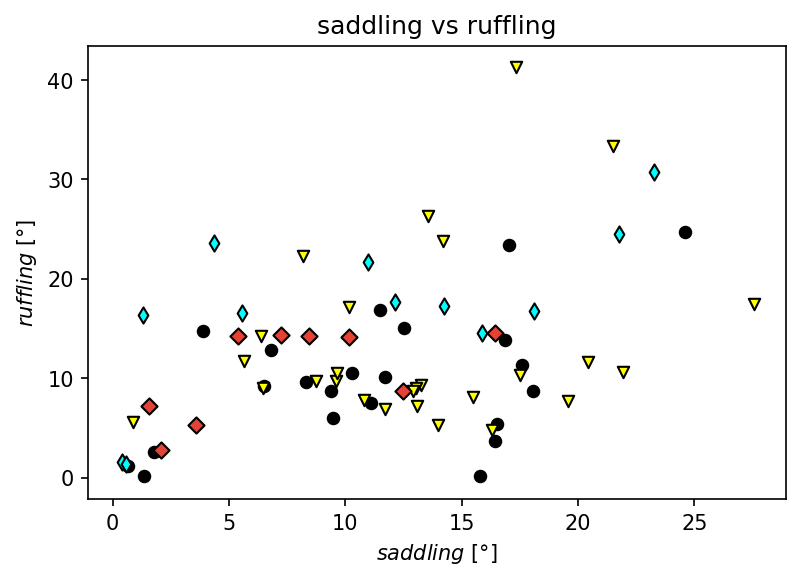

In [153]:
fig = plt.figure(dpi = 150)
scatterkat(dflg,"saddling","ruffling",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)
plt.title("saddling vs ruffling")
#fig.savefig(f"{plots}ruffling_vs_saddling.png")

### saddling

### Em_lit

In [154]:
6.7*10**6/11

609090.9090909091

In [155]:
BHIS

'B_-/His'

noise variance:  0.27560666091933067
number of componentes:  6
[0.32862786 0.18176291 0.09918944 0.08838336 0.07365961 0.05360979]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

/home/hagen/Masterarbeit/Verteidigung/plots/pca_Em_lit_3D.png
/home/hagen/Masterarbeit/Verteidigung/plots/pca_Em_lit_2D.png


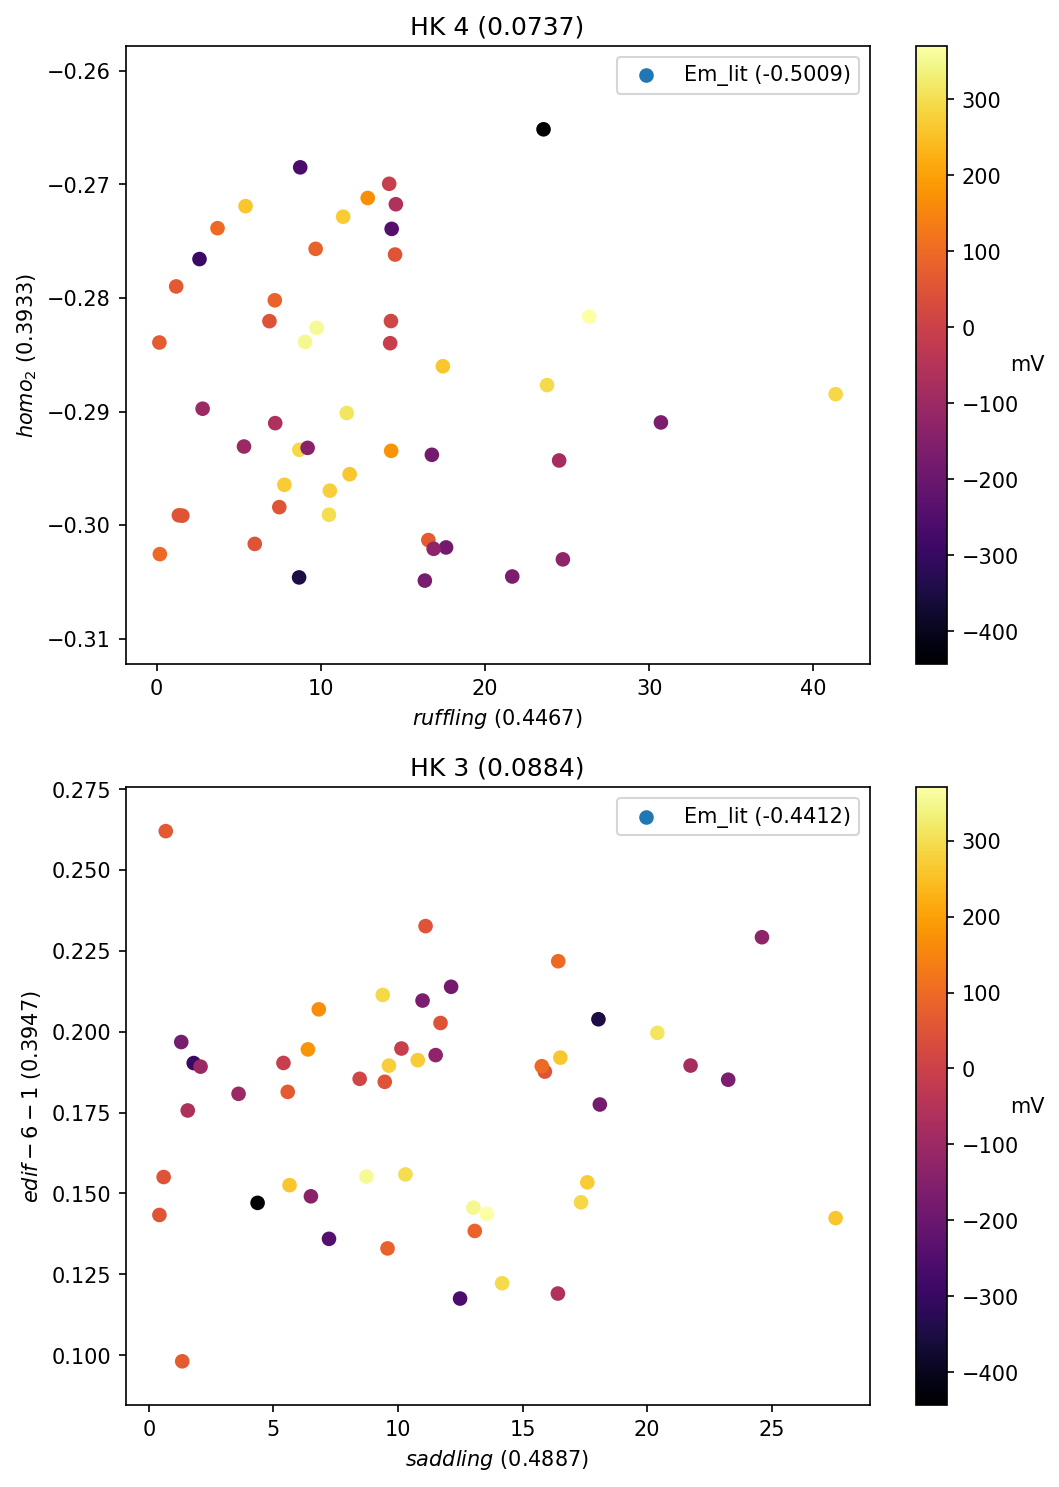

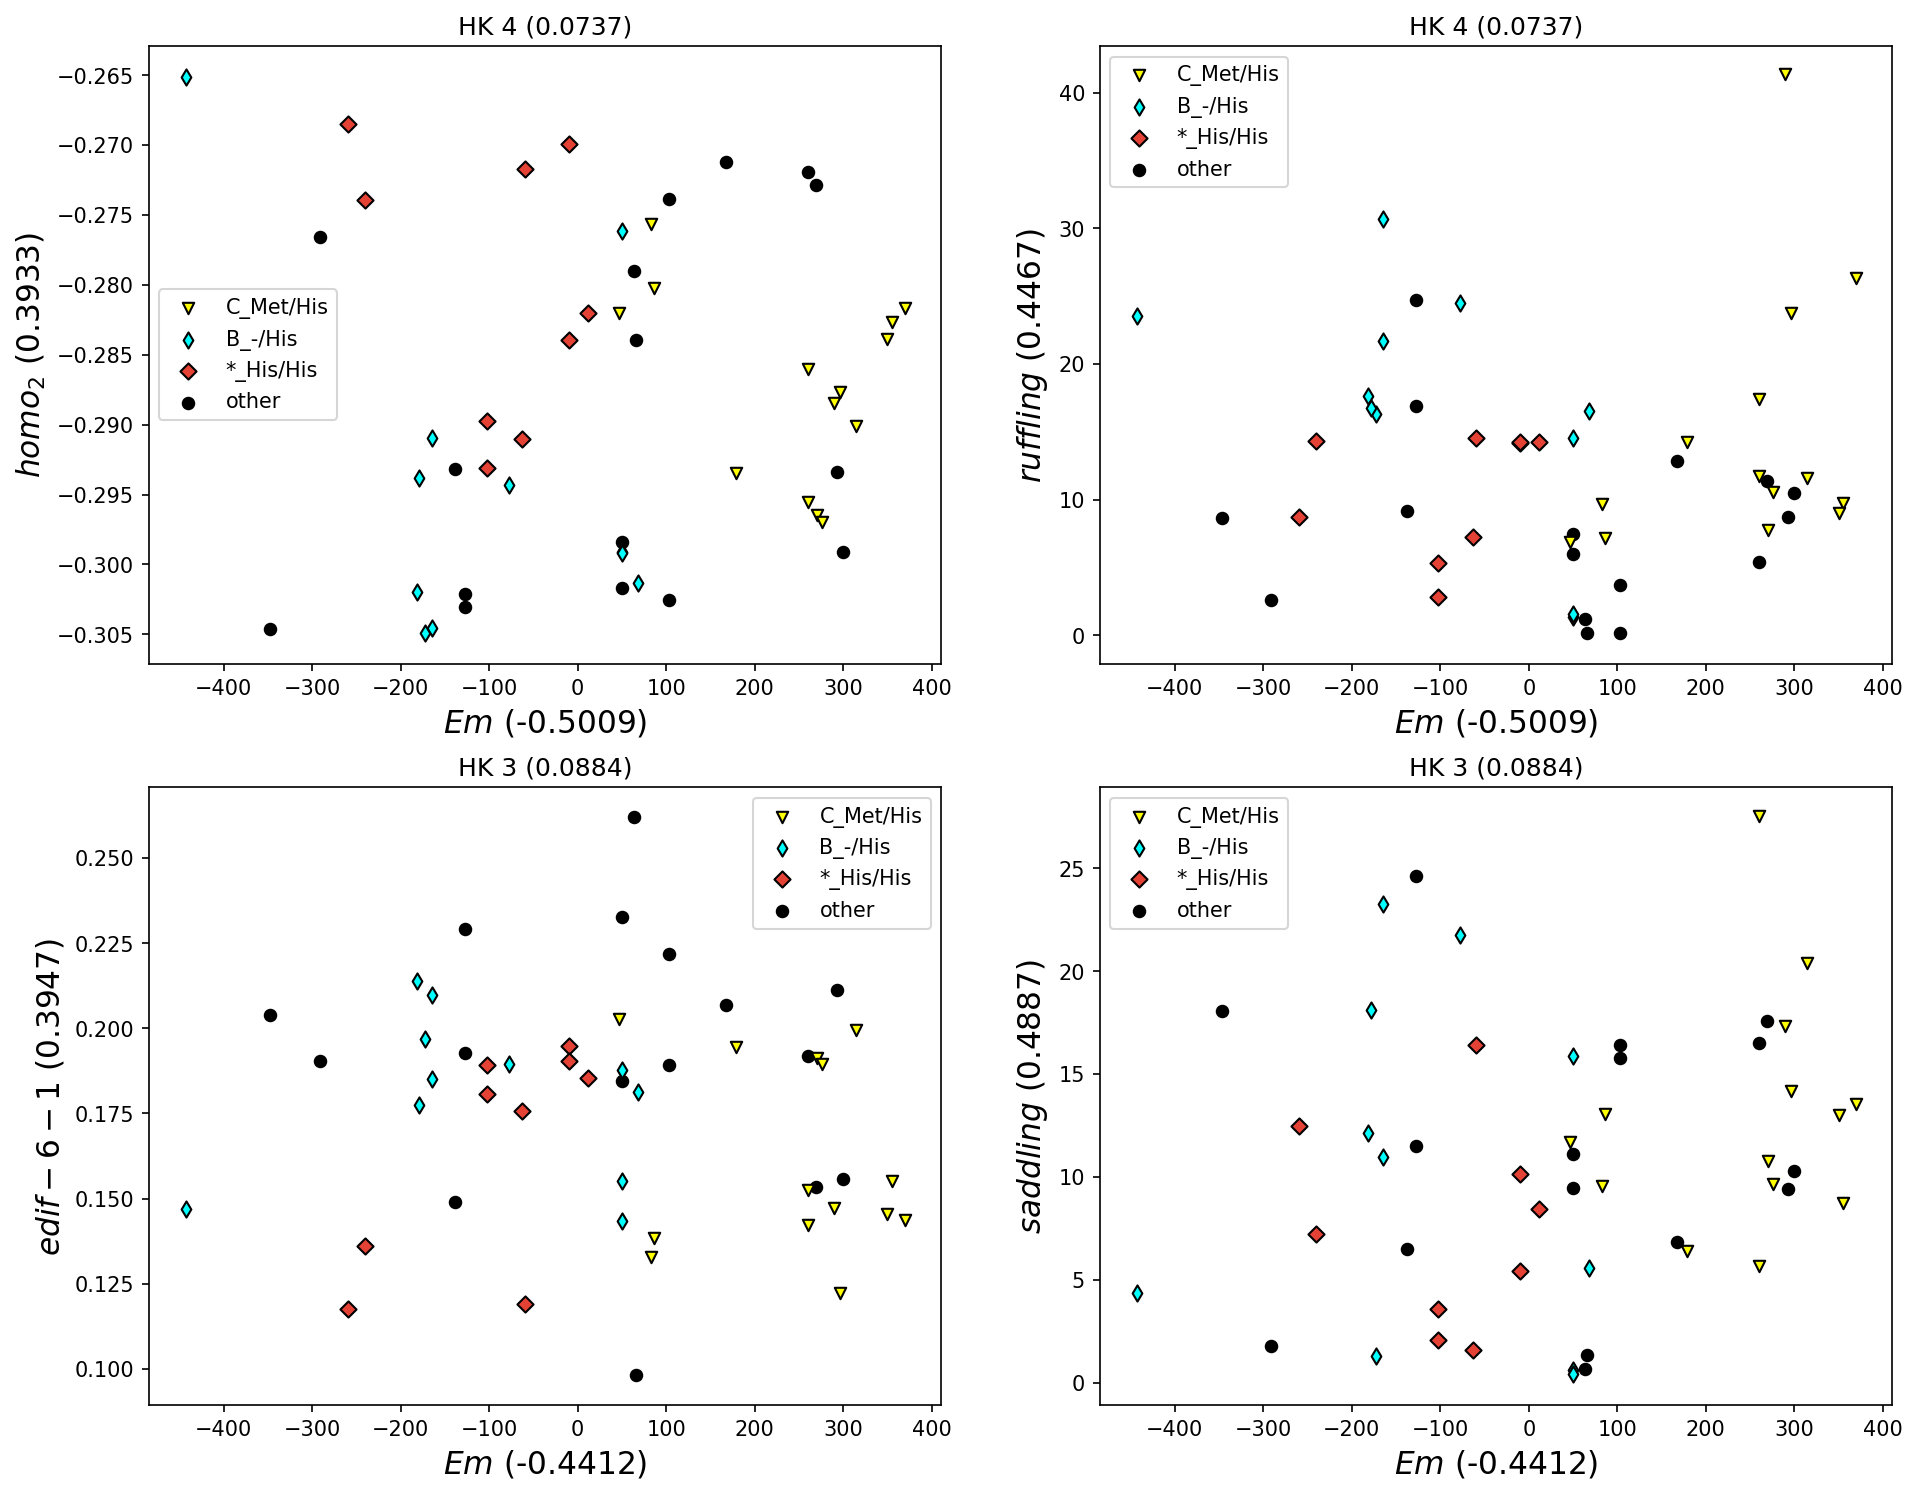

In [156]:
df = dfpca4
column ="Em_lit"






dff = pca_col(df,column)

names = []
fig = plt.figure(dpi= 150,figsize=[8,12])

for hk in [0,1]:
    
    HK = (str(dff[hk]["HK"])    )
    
  #  fig = plt.figure(dpi= 150)

    plt.subplot(2,1,hk+1)
    df_p = dff[hk]["df"]
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    plt.title(f"HK {HK} ({variance_ratio})")
    ind1, ind2 = df_p.index
#    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=variance_ratio)
    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=f"{column} ({dff[hk][column]})")
    plt.legend()
    plt.xlabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")
    #plt.colorbar()
    cbar =plt.colorbar()#
    cbar.set_label('mV', rotation=0)
    fig.savefig(f"{plots}pca_{column}_{hk}_3D.png")
  #  names.append(f"pca_{column}_{hk}_3D.png")
fig.savefig(f"{plots}pca_{column}_3D.png")
names.append(f"{plots}pca_{column}_3D.png") 
    
fig = plt.figure(dpi=150, figsize=(15,12))    
for hk in [0,1]:
    HK = (str(dff[hk]["HK"])    )
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    
    df_p = dff[hk]["df"]
    ind1, ind2 = df_p.index
    
    plt.subplot(2,2,((hk+1)*1+hk))

    
    plt.title(f"HK {HK} ({variance_ratio})")
   
    
    scatterkat(df_work4,column,ind2,Kategorie,dictionary=scatterdict)
    plt.legend()
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)
    
    plt.ylabel(string1(ind2),fontsize=15)
    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")
                
    #names.append(f"pca_{column}_{hk}_1.png")
    
    
    

    plt.subplot(2,2,((hk+1)*2))
    plt.title(f"HK {HK} ({variance_ratio})")
    

    scatterkat(df_work4,column,ind1,Kategorie,dictionary=scatterdict)
    plt.legend()
    
    plt.xlabel(string1(column),fontsize=15)
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)    
    plt.ylabel(string1(ind1),fontsize=15)
    plt.ylabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

   # names.append(f"pca_{column}_{hk}_2.png")

fig.savefig(f"{plots}pca_{column}_2D.png") 
names.append(f"{plots}pca_{column}_2D.png")
for i in names:
    print(i)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


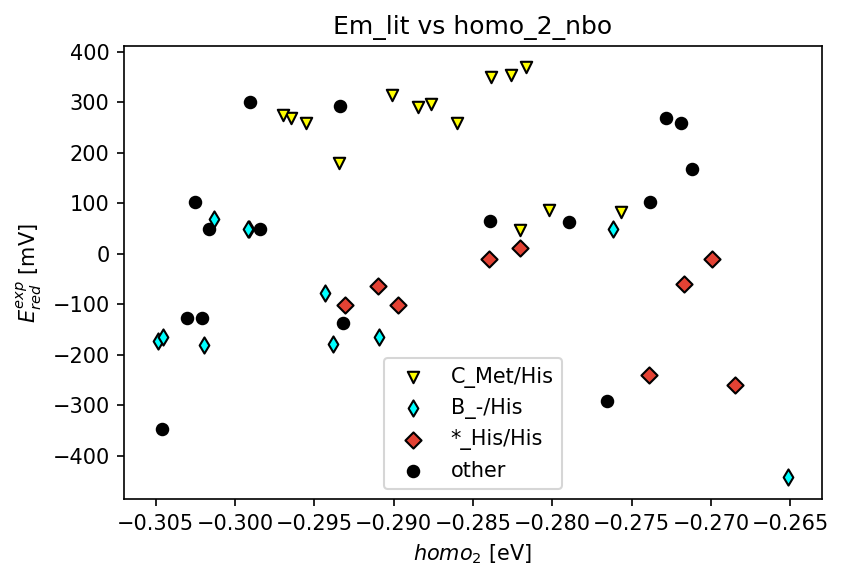

In [157]:
plt.figure(dpi = 150)
y = "Em_lit"
x = "homo_2_nbo"
scatterkat(df_work2,x,y,Kategorie)
plt.xlabel("$homo_2$ [eV]")
plt.ylabel(redox)
plt.title(f"{y} vs {x }")
plt.legend()
plt.savefig(f"{plots}homo2_Em_lit.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


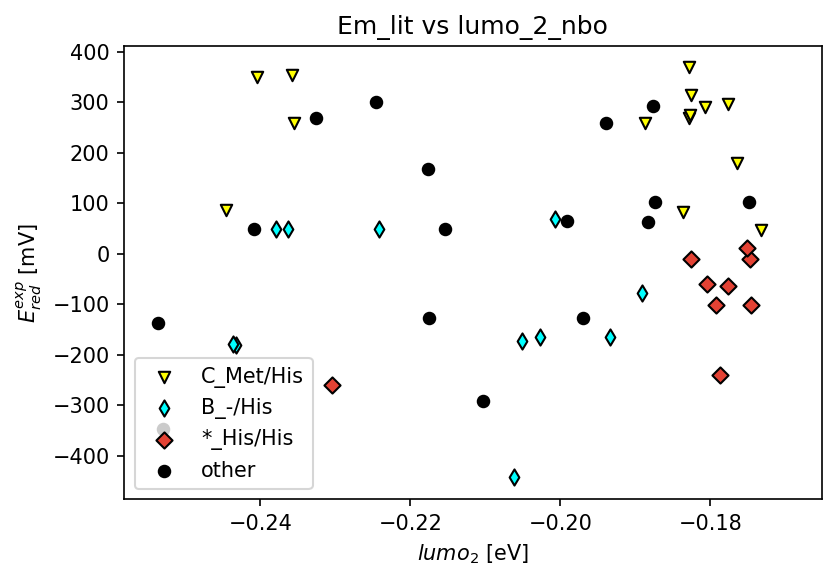

In [158]:
plt.figure(dpi = 150)
y = "Em_lit"
x = "lumo_2_nbo"
scatterkat(df_work2,x,y,Kategorie)
plt.xlabel("$lumo_2$ [eV]")
plt.ylabel(redox)
plt.title(f"{y} vs {x }")
plt.legend()
plt.savefig(f"{plots}lumo2_Em_lit.png")

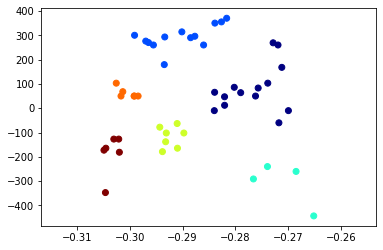

In [159]:
X = df[["homo_2_nbo", "Em_lit"]]
x_transformed = scaler.fit_transform(X)


model  =KMeans(n_clusters = 6)
model.fit(x_transformed)


cluster1 = model.cluster_centers_
cluster2 = scaler.inverse_transform(model.cluster_centers_) 



plt.scatter(df["homo_2_nbo"],df["Em_lit"],c=model.labels_,cmap = "jet")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


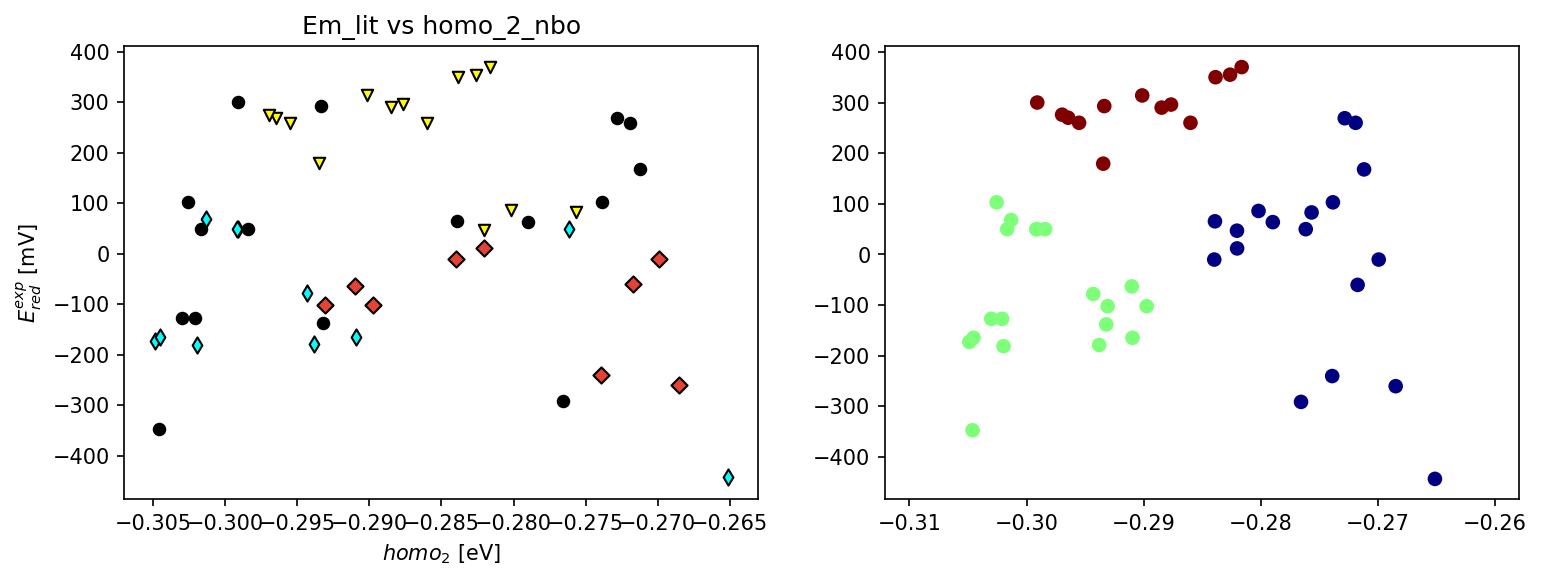

In [160]:
df = df_work2.copy()
plt.figure(dpi=150,figsize=[12,4])
plt.subplot(121)
y = "Em_lit"
x = "homo_2_nbo"
scatterkat(df_work2,x,y,Kategorie)
plt.xlabel("$homo_2$ [eV]")
plt.ylabel(redox)
plt.title(f"{y} vs {x }")


plt.subplot(122)
X = df[["homo_2_nbo", "Em_lit"]]
x_transformed = scaler.fit_transform(X)


model  =KMeans(n_clusters = 3)
model.fit(x_transformed)


cluster1 = model.cluster_centers_
cluster2 = scaler.inverse_transform(model.cluster_centers_) 



plt.scatter(df["homo_2_nbo"],df["Em_lit"],c=model.labels_,cmap = "jet")

noise variance:  0.27560666091933067
number of componentes:  6
[0.32862786 0.18176291 0.09918944 0.08838336 0.07365961 0.05360979]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

/home/hagen/Masterarbeit/Verteidigung/plots/pca_ruffling_3D.png
/home/hagen/Masterarbeit/Verteidigung/plots/pca_ruffling_2D.png


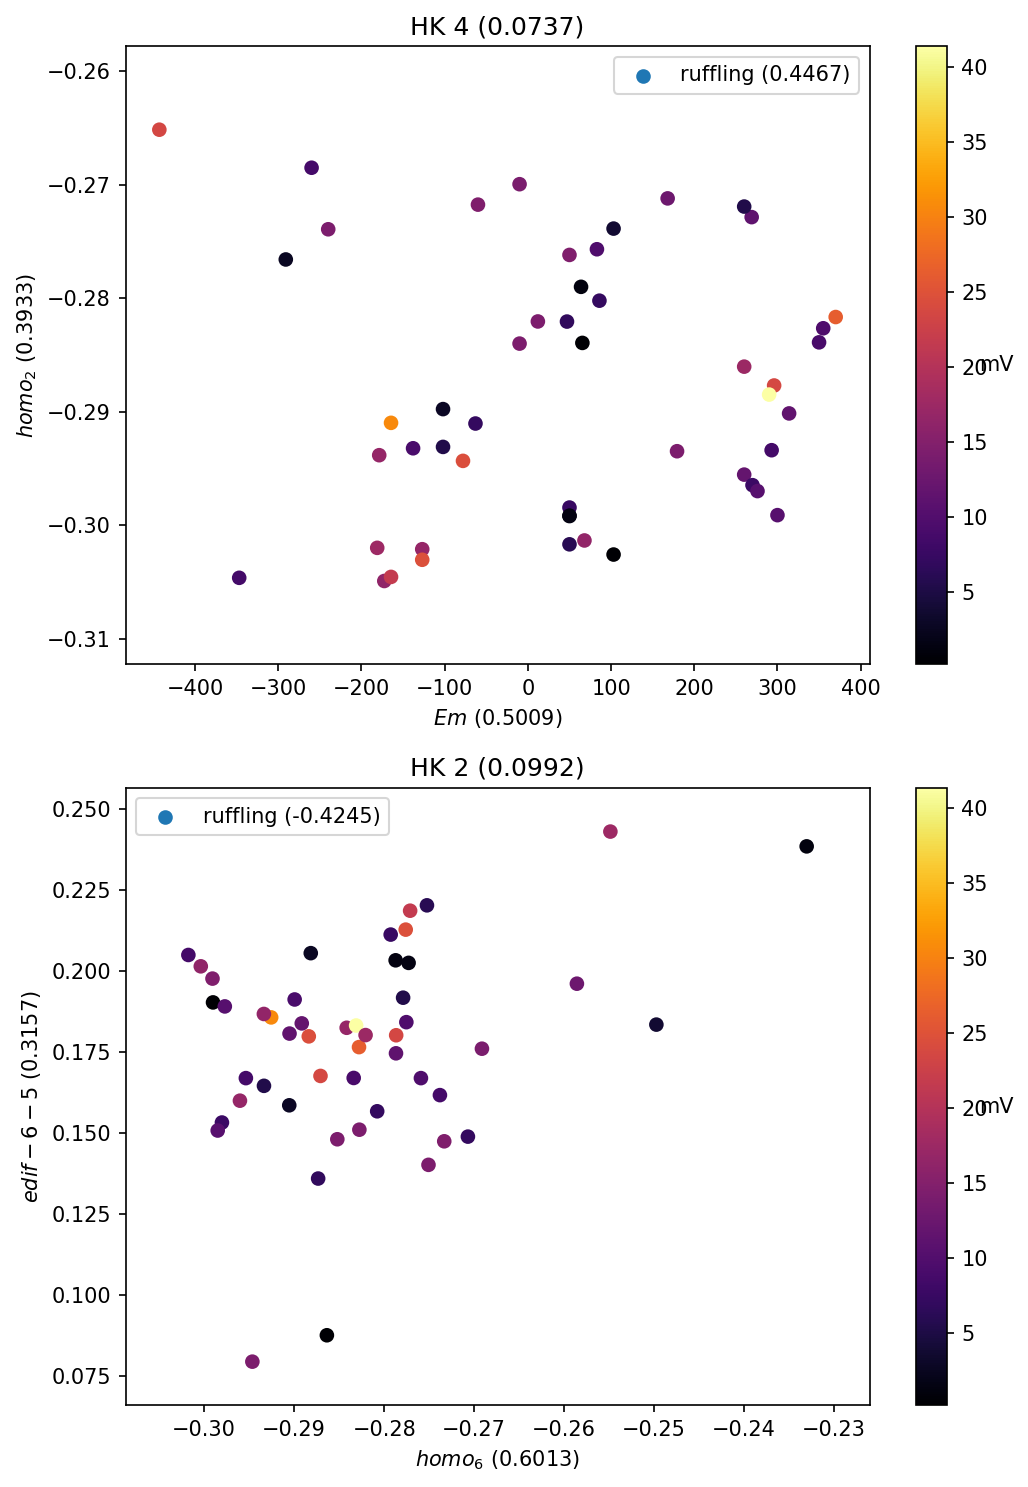

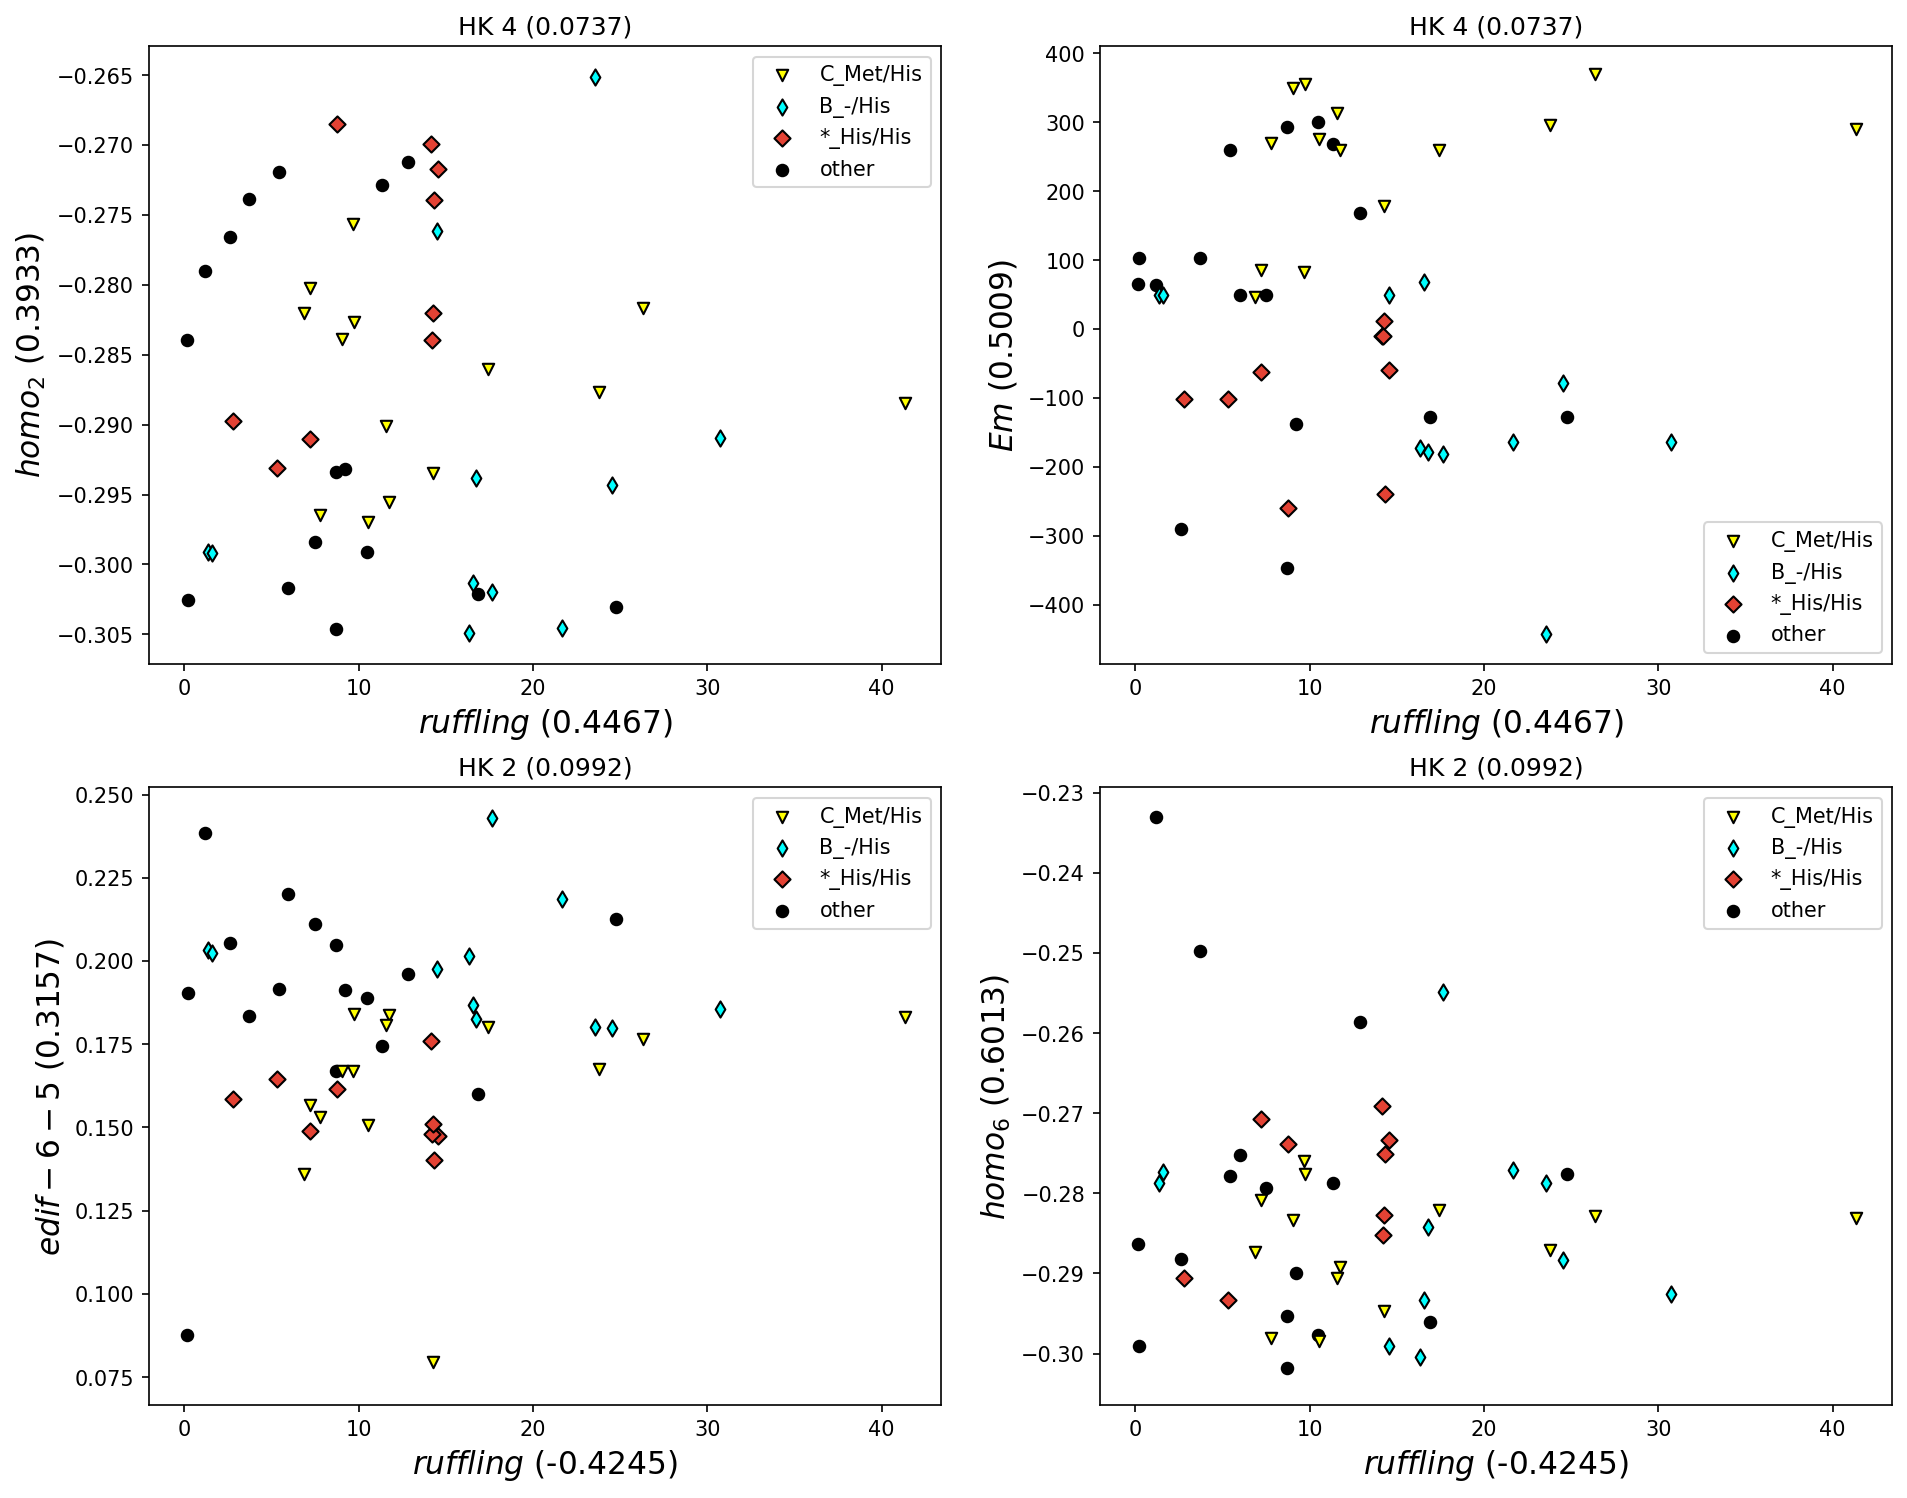

In [161]:
df = dfpca4
column ="ruffling"






dff = pca_col(df,column)

names = []
fig = plt.figure(dpi= 150,figsize=[8,12])

for hk in [0,1]:
    
    HK = (str(dff[hk]["HK"])    )
    
  #  fig = plt.figure(dpi= 150)

    plt.subplot(2,1,hk+1)
    df_p = dff[hk]["df"]
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    plt.title(f"HK {HK} ({variance_ratio})")
    ind1, ind2 = df_p.index
#    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=variance_ratio)
    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=f"{column} ({dff[hk][column]})")
    plt.legend()
    plt.xlabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")

    cbar =plt.colorbar()#
    cbar.set_label('mV', rotation=0)
    
    fig.savefig(f"{plots}pca_{column}_{hk}_3D.png")
  #  names.append(f"pca_{column}_{hk}_3D.png")
fig.savefig(f"{plots}pca_{column}_3D.png")
names.append(f"{plots}pca_{column}_3D.png") 
    
fig = plt.figure(dpi=150, figsize=(15,12))    
for hk in [0,1]:
    HK = (str(dff[hk]["HK"])    )
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    
    df_p = dff[hk]["df"]
    ind1, ind2 = df_p.index
    
    plt.subplot(2,2,((hk+1)*1+hk))

    
    plt.title(f"HK {HK} ({variance_ratio})")
   
    
    scatterkat(df_work4,column,ind2,Kategorie,dictionary=scatterdict)
    plt.legend()
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)
    
    plt.ylabel(string1(ind2),fontsize=15)
    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")
                
    #names.append(f"pca_{column}_{hk}_1.png")
    
    
    

    plt.subplot(2,2,((hk+1)*2))
    plt.title(f"HK {HK} ({variance_ratio})")
    

    scatterkat(df_work4,column,ind1,Kategorie,dictionary=scatterdict)
    plt.legend()
    
    plt.xlabel(string1(column),fontsize=15)
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)    
    plt.ylabel(string1(ind1),fontsize=15)
    plt.ylabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

   # names.append(f"pca_{column}_{hk}_2.png")

fig.savefig(f"{plots}pca_{column}_2D.png") 
names.append(f"{plots}pca_{column}_2D.png")
for i in names:
    print(i)


In [162]:
df = df_work2.copy()
model =LinearRegression()
X= df[["ruffling","homo_1_nbo","edif-6-1","saddling"]].values
#X= df[["ruffling","saddling"]].values
y =df[["Em_lit"]].values
X_train,X_test,y_train,y_test = train_test_split(X,y)
model.fit(X,y)
model.score(X_test,y_test)

-0.03862897868967208

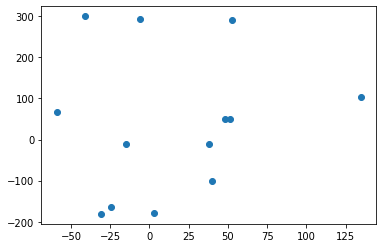

In [163]:
plt.scatter(model.predict(X_test),y_test)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


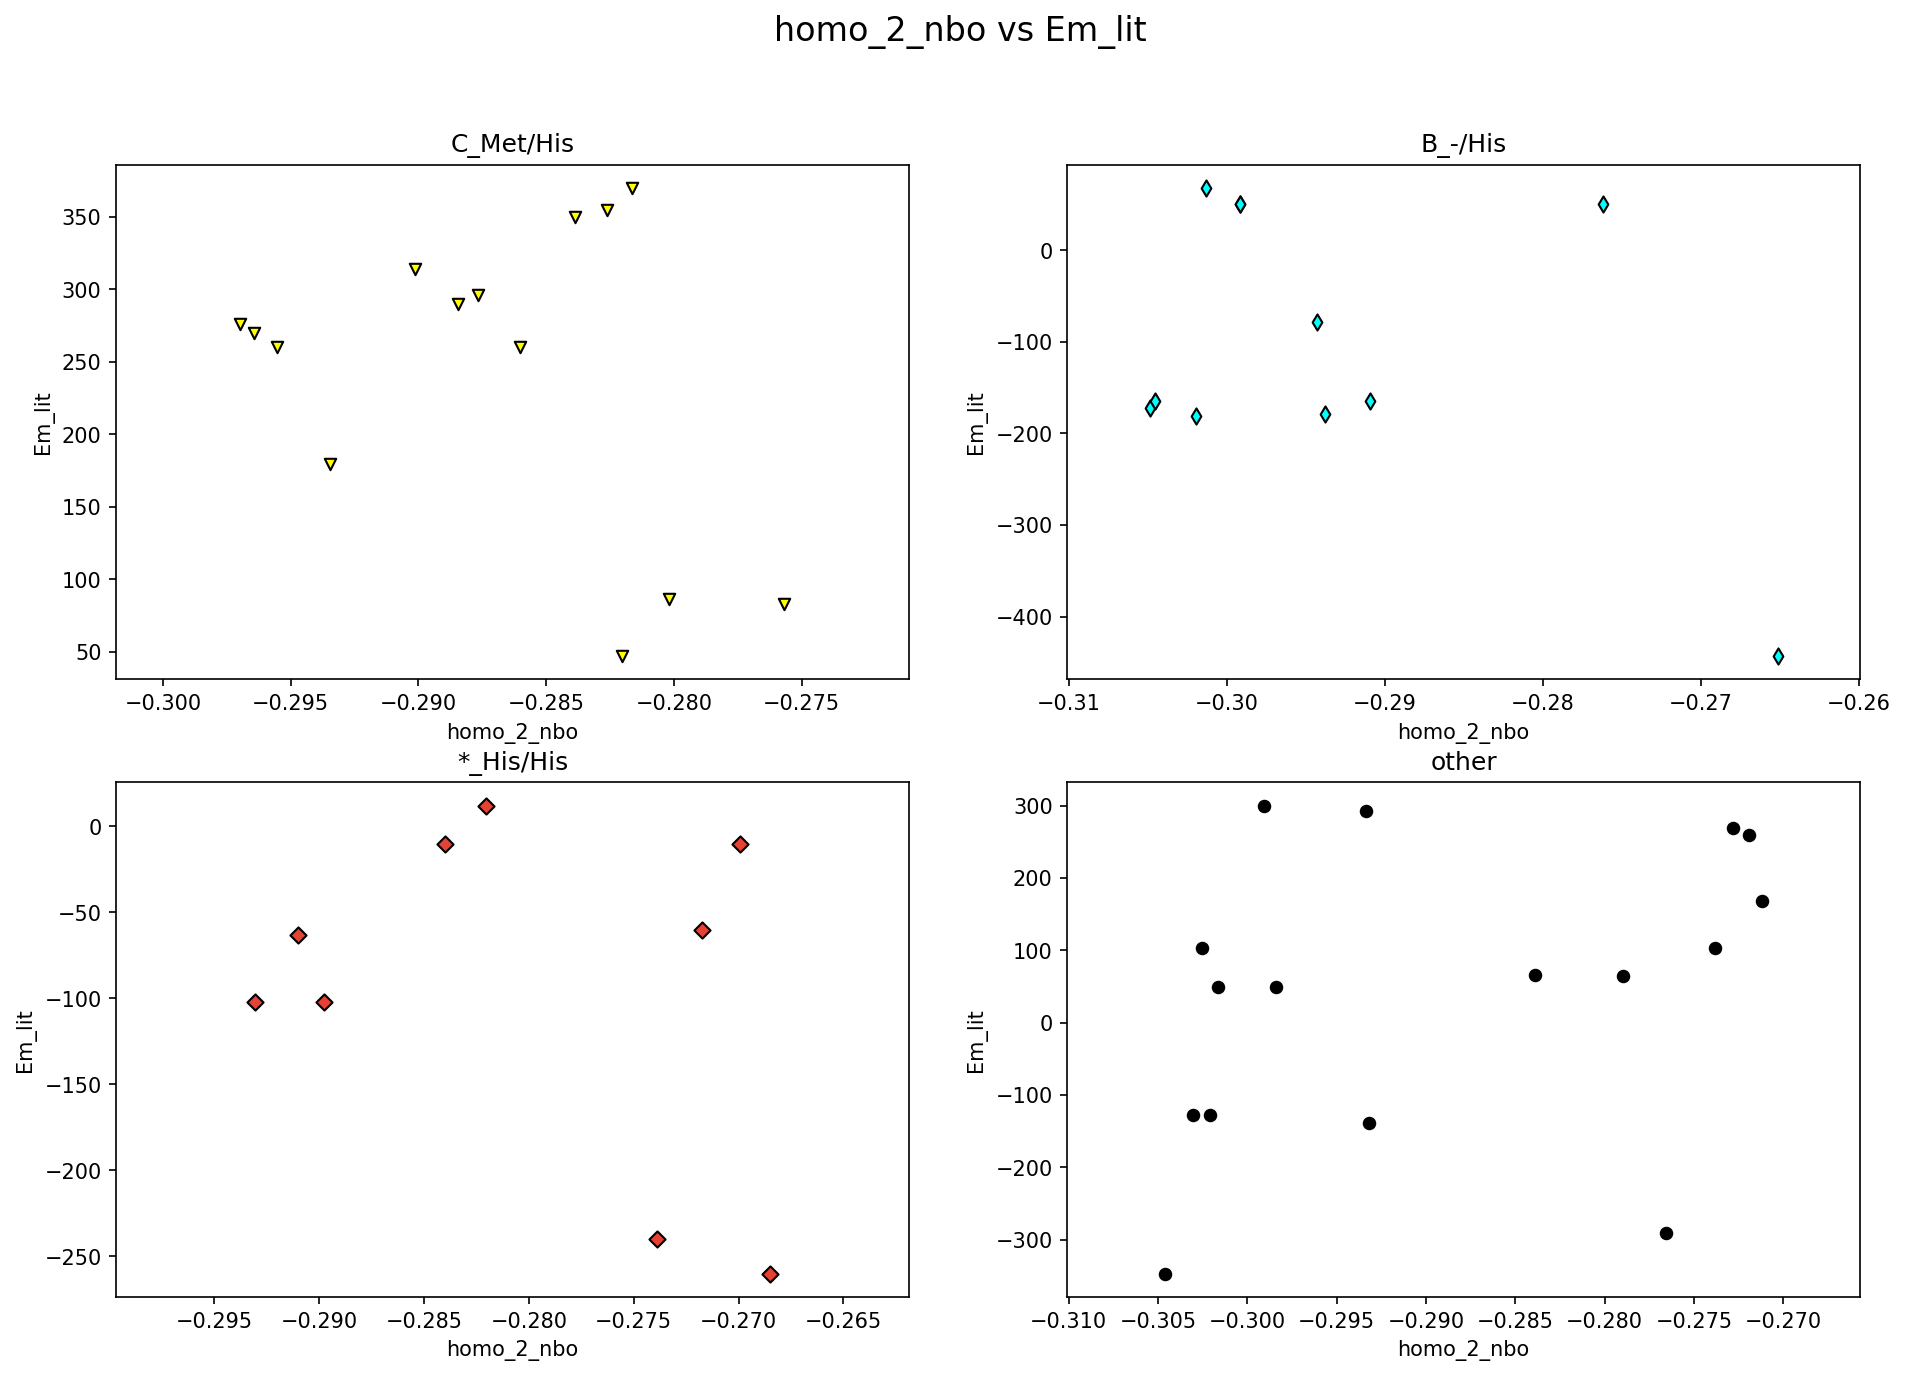

In [164]:
df = df_work2.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "homo_2_nbo"

for i,kat in enumerate (['C_Met/His', 'B_-/His', '*_His/His']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

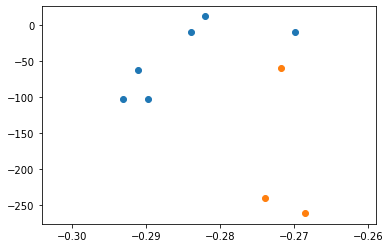

In [165]:
df = df_work2.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn_r"]=="His/His"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])
df = df_work2.copy()
df = df[df["Hemetyp"]=="C"]
df = df[df["ax_qn_r"]=="His/His"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])

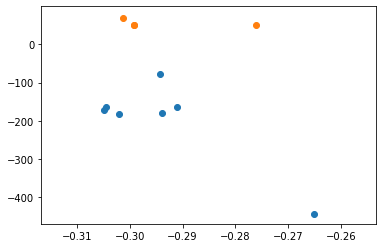

In [166]:
df = df_work2.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn_r"]=="-/His"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])
df = df_work2.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn_r"]=="His/-"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


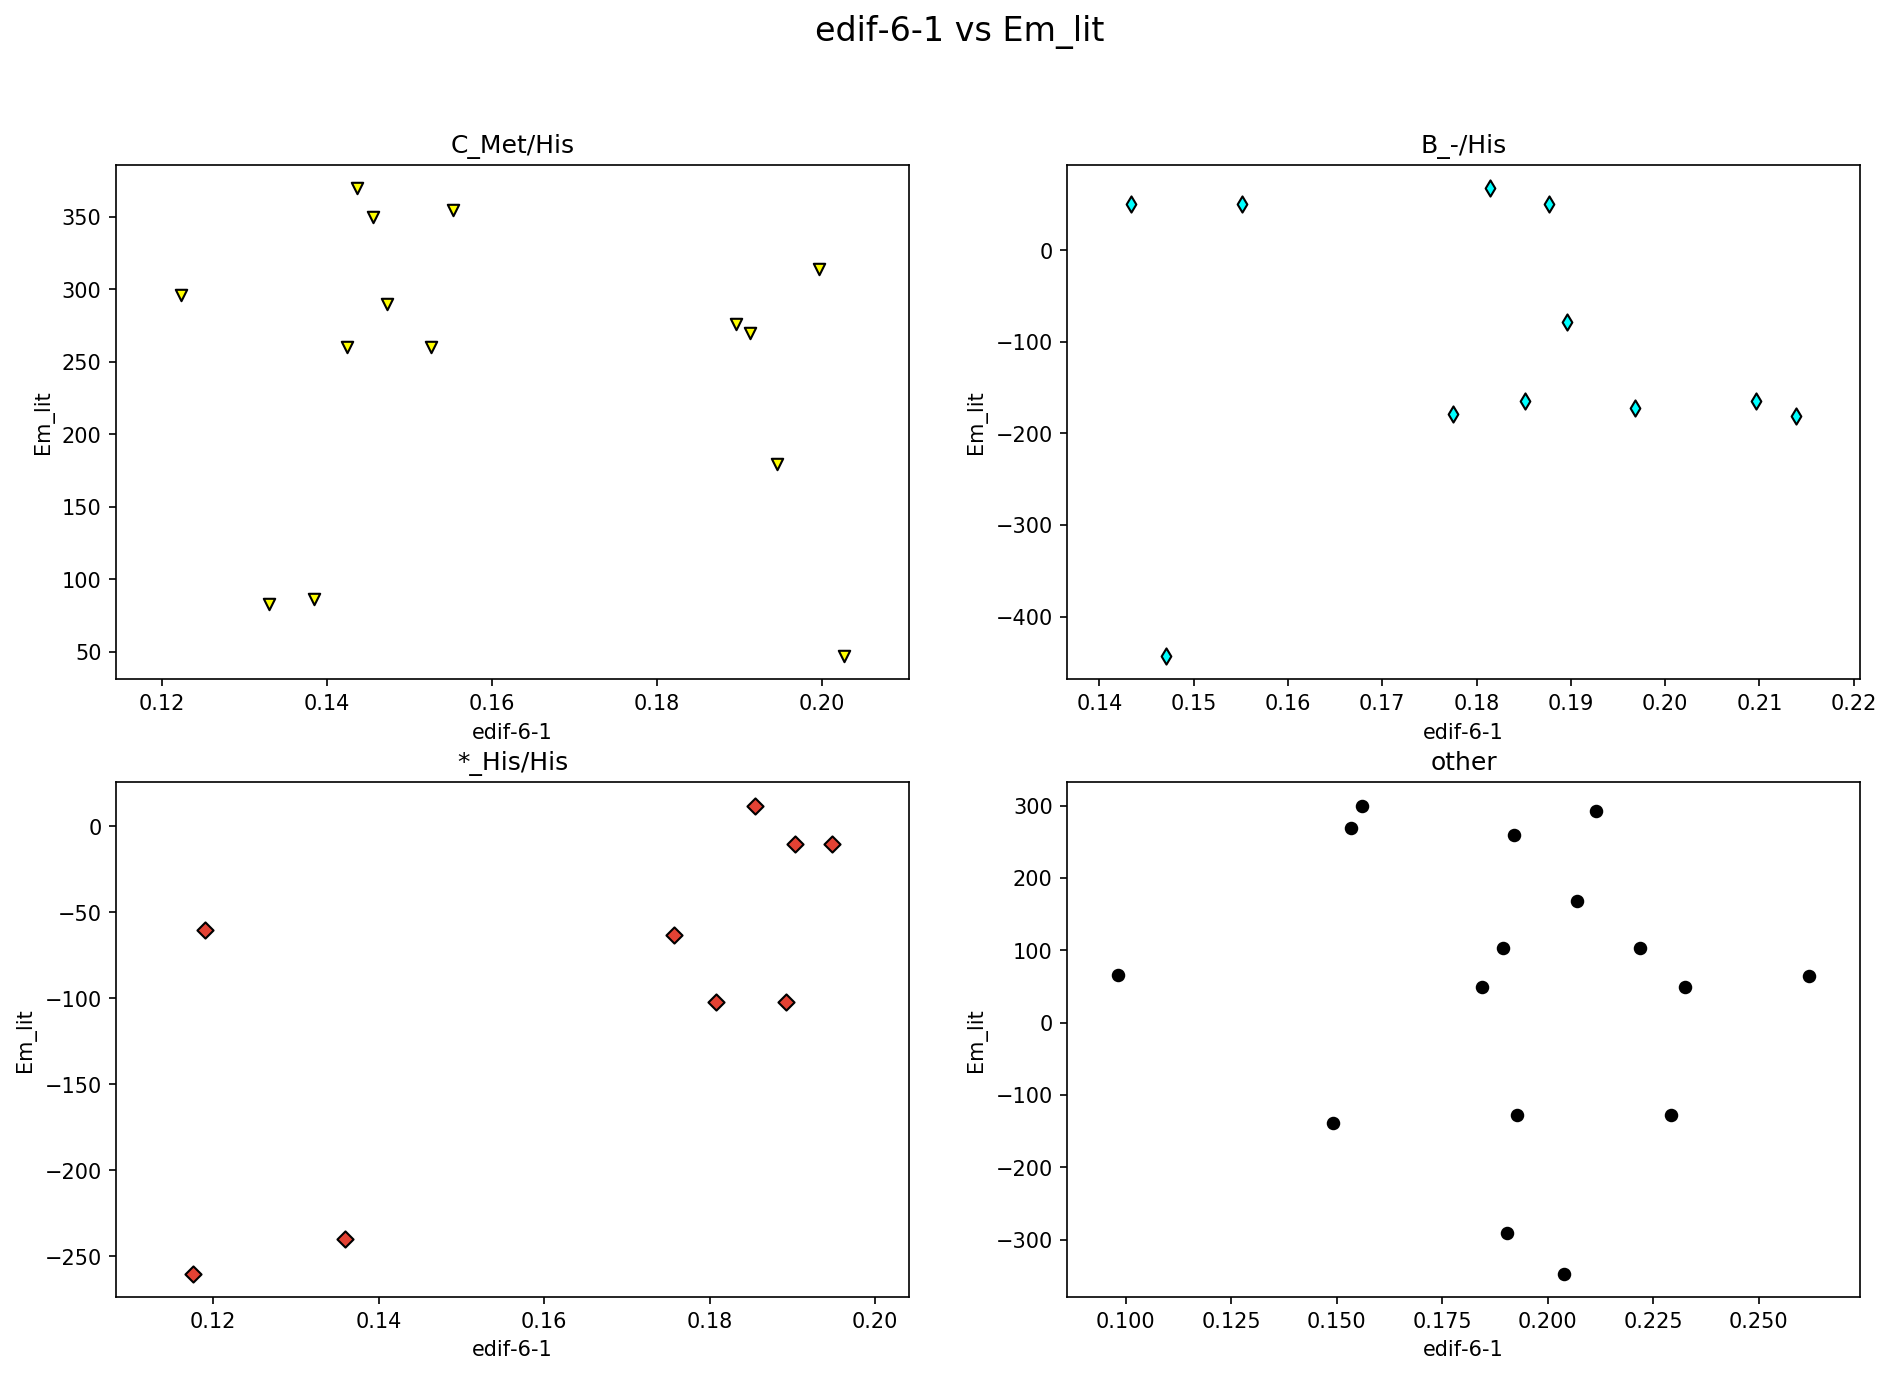

In [167]:
df = df_work2.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "edif-6-1"

for i,kat in enumerate (['C_Met/His', 'B_-/His', '*_His/His']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


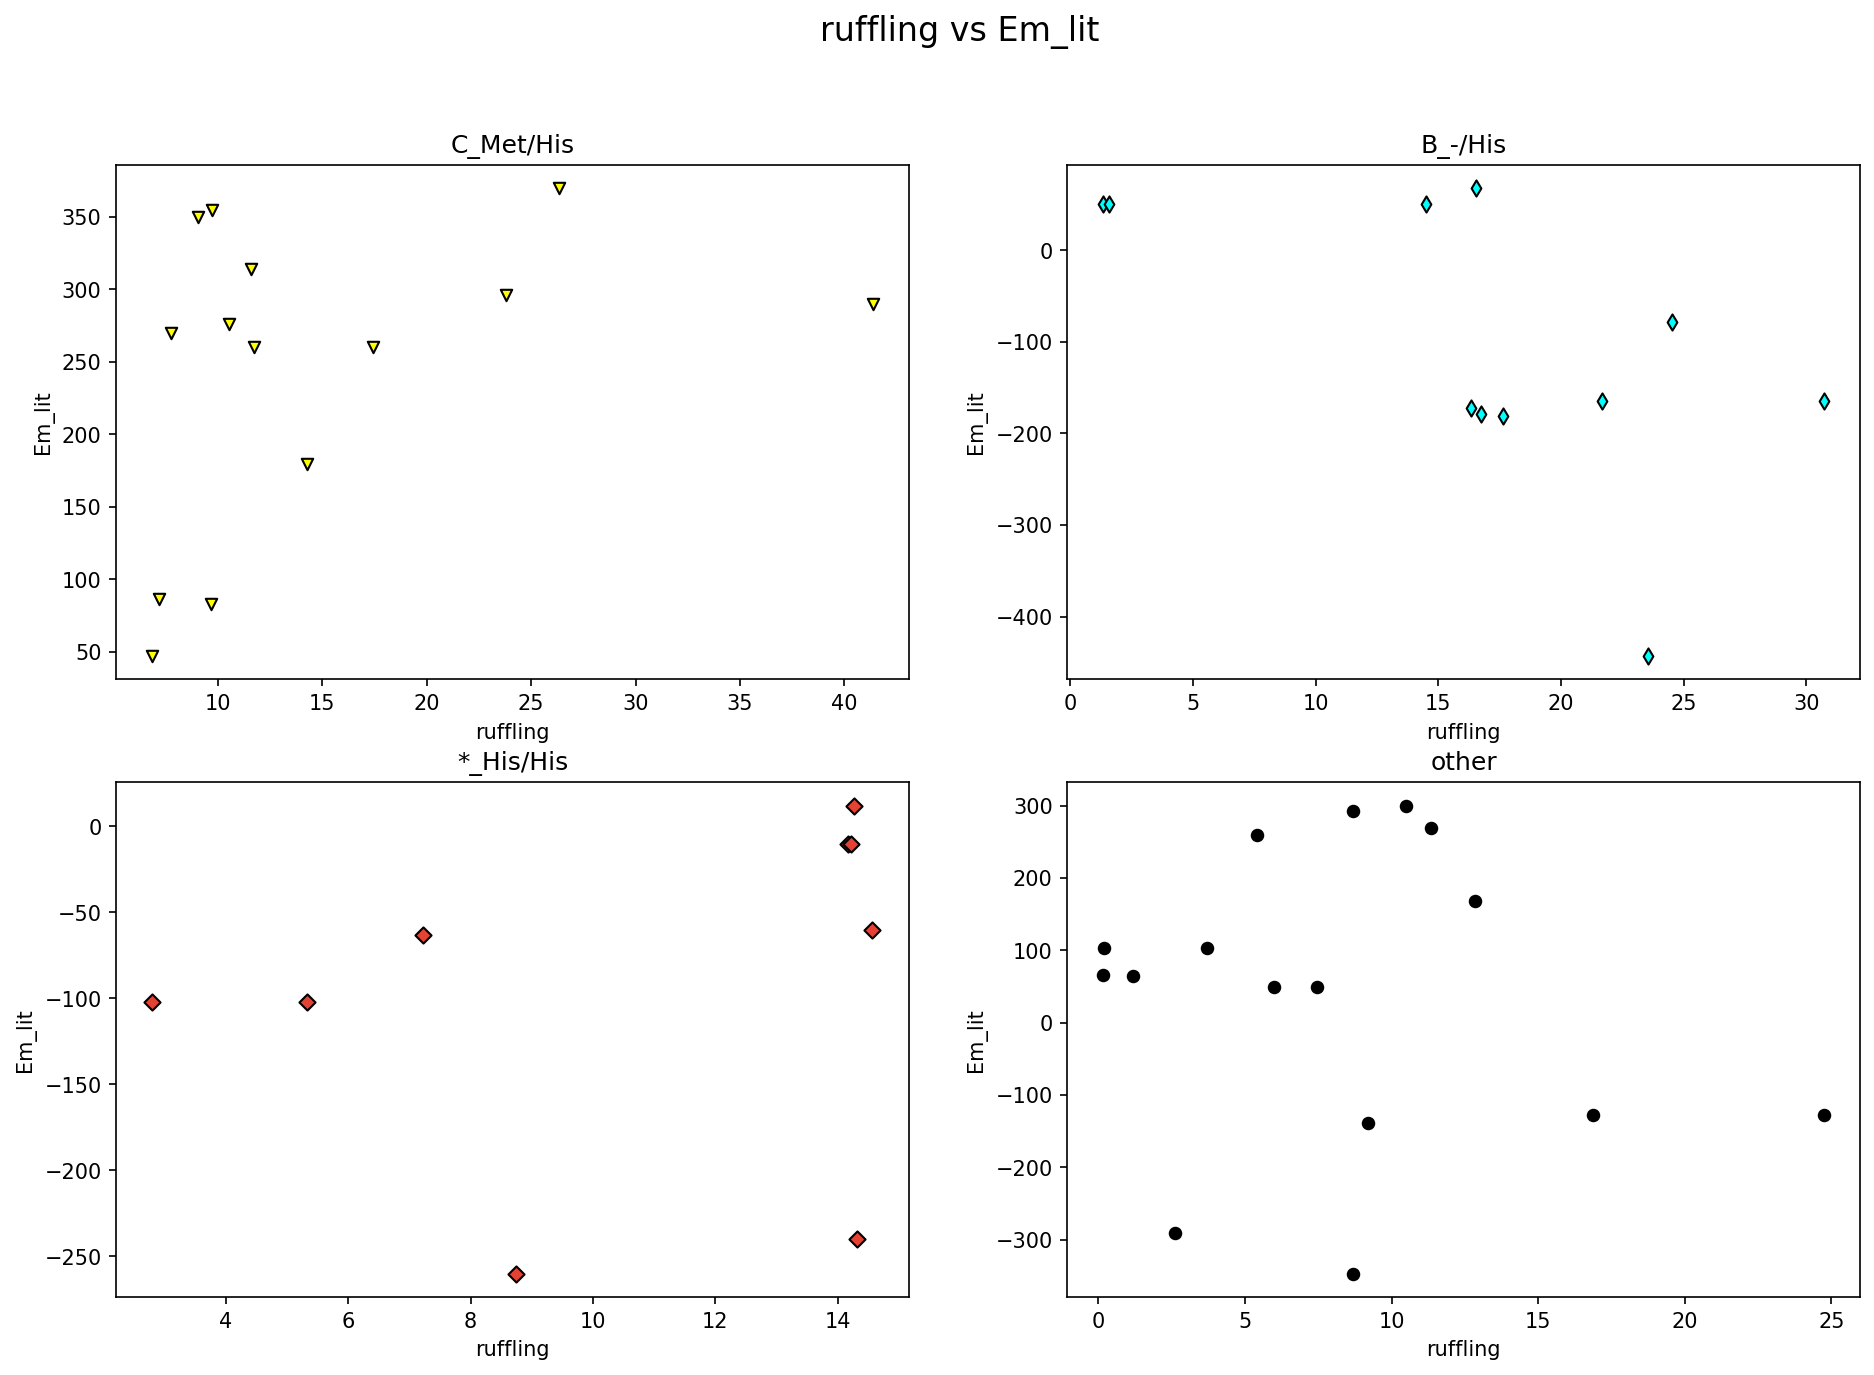

In [168]:
df = df_work2.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "ruffling"

for i,kat in enumerate (['C_Met/His', 'B_-/His', '*_His/His']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


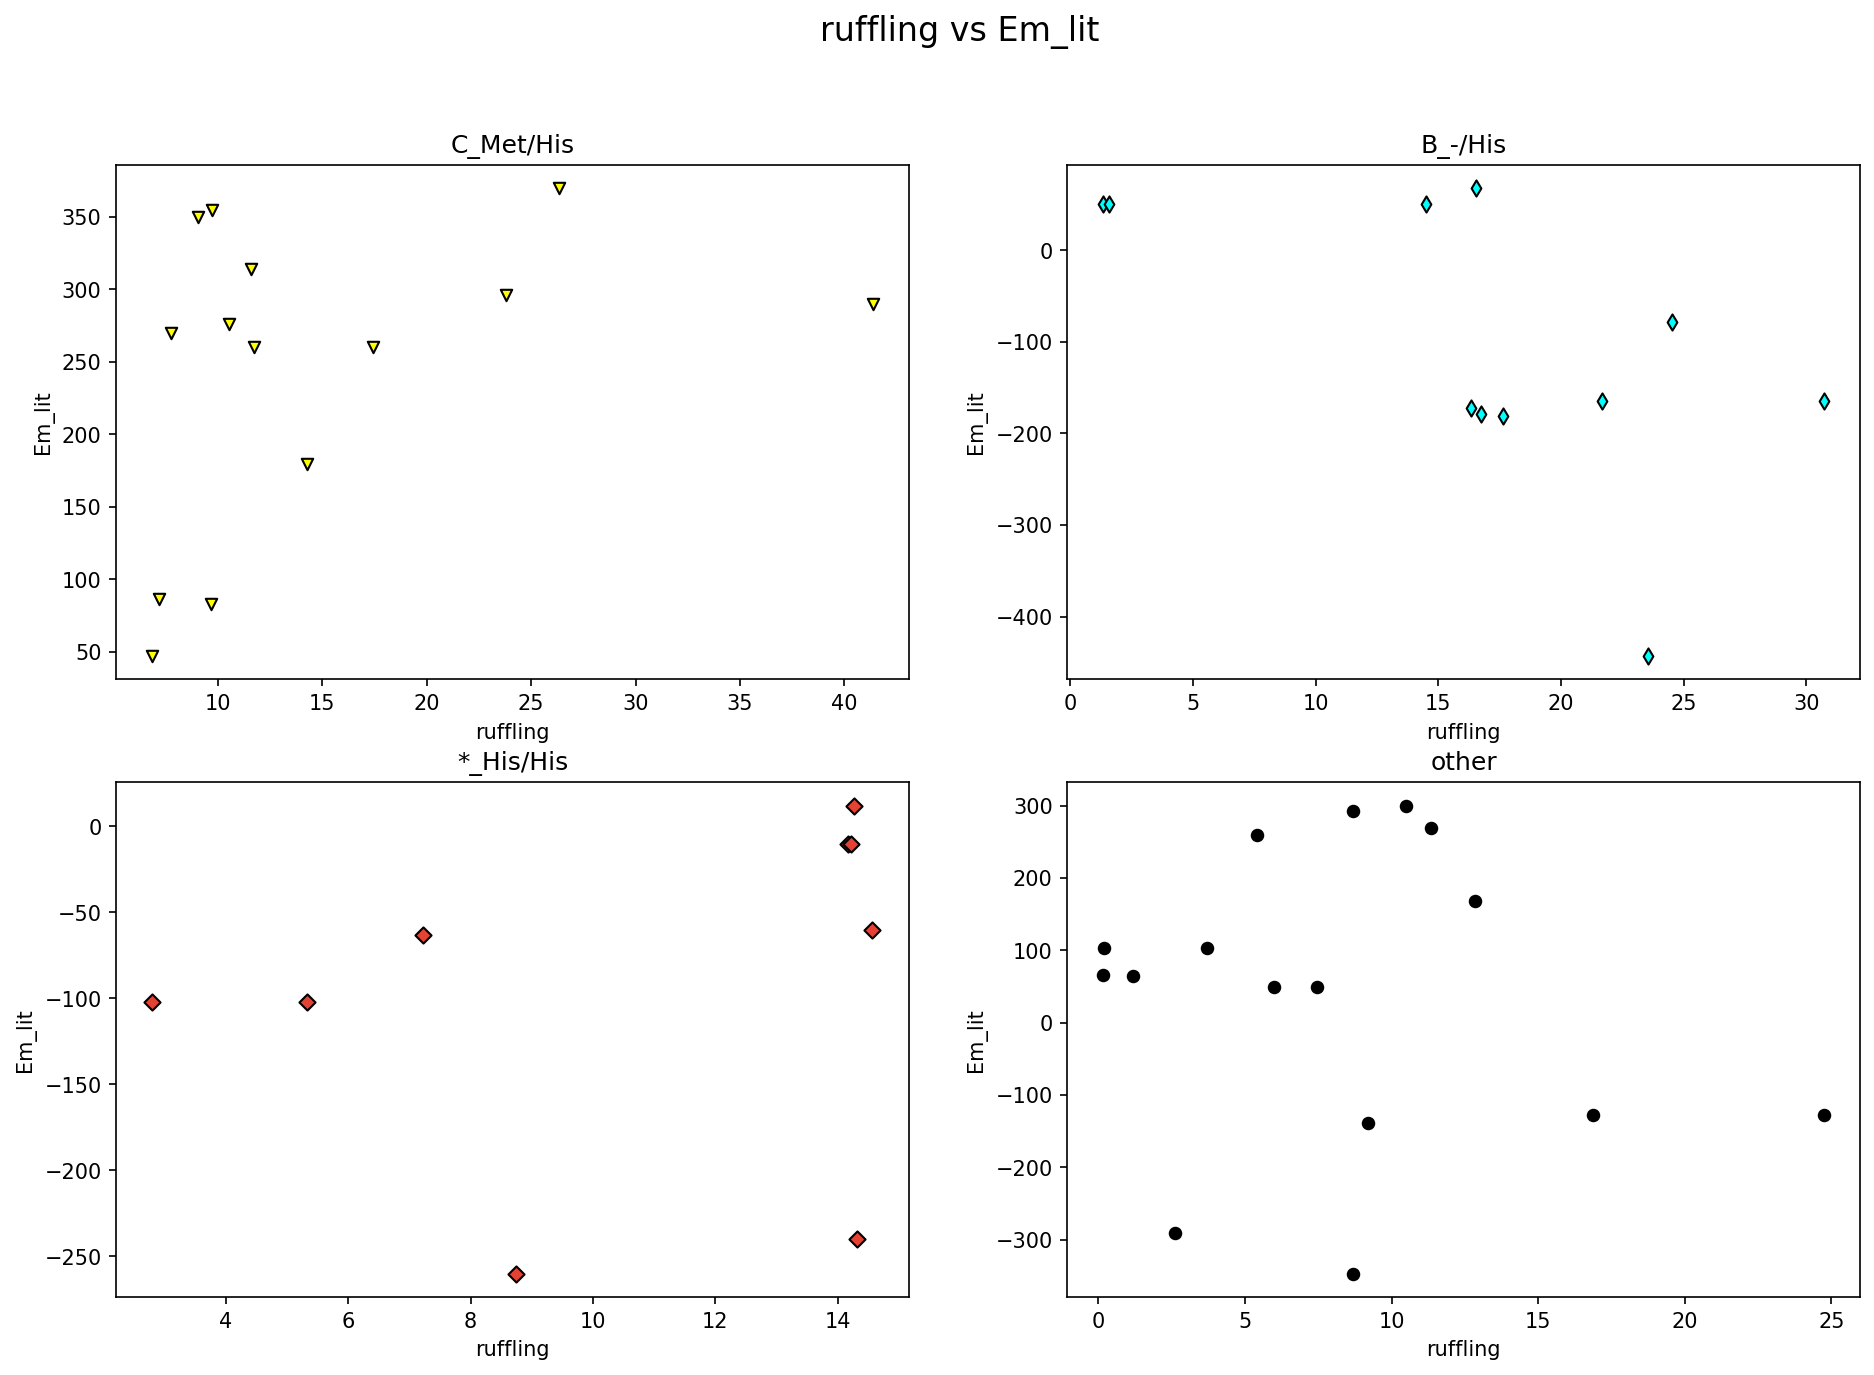

In [169]:
df = dflg.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "ruffling"

for i,kat in enumerate (['C_Met/His', 'B_-/His', '*_His/His']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

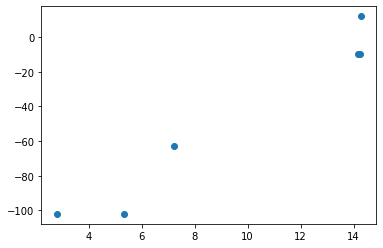

In [170]:
df = dflg.copy()
df = df[df["Kategorie2"]==HH]
df=  df[df["Hemetyp"]=="B"]
plt.scatter(df["ruffling"],df["Em_lit"])

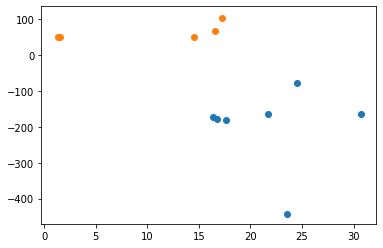

In [171]:
df = dflg.copy()
df = df[df["Kategorie2"]==BHIS]
df=  df[df["ligup"]=="-"]
plt.scatter(df["ruffling"],df["Em_lit"])
df = dflg.copy()
df = df[df["Kategorie2"]==BHIS]
df=  df[df["ligdown"]=="-"]
plt.scatter(df["ruffling"],df["Em_lit"])

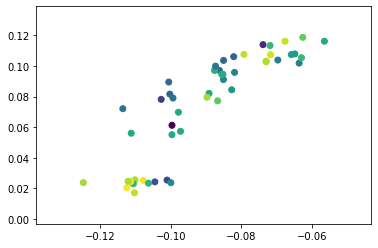

In [172]:

plt.scatter(dfpca2["lumo_1_nbo"], dfpca2["diff_1_nbo"], c = dfpca2["Em_lit"])

In [173]:
df = dfpca2[dfpca2["ruffling"]<20]
pca_col(df, "ruffling" )

noise variance:  0.49013783173158487
number of componentes:  6
[0.18845177 0.15876704 0.1278121  0.09595475 0.06781197 0.05361588]


{0: {'ruffling': -0.1817, 'df':                      0
  qpole4_2_nbo  0.292806
  qpole1_2_nbo  0.277857, 'variance_ratio': 0.05361587554767499, 'HK': 5},
 1: {'ruffling': 0.1185, 'df':                      1
  qpole3_1_nbo  0.313165
  qpole3_5_nbo  0.307627, 'variance_ratio': 0.1587670403846907, 'HK': 1}}

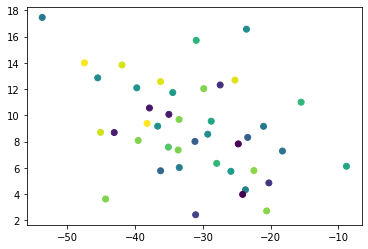

In [174]:
plt.scatter(df["qpole3_2_nbo"], df["dipole_2_nbo"], c = df["ruffling"])

In [175]:
#pca_col(dfpca2, "saddling", 0.01, num_comp = 6)

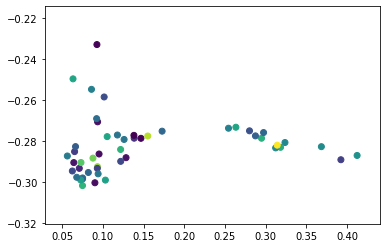

In [176]:
plt.scatter(dfpca2["elekphil_1_nbo"], dfpca2["homo_6_nbo"], c = dfpca2["saddling"])

In [177]:
df_workp1 = df_work4[[i for i in df_work4.columns if "edisp" not in i  and not( "e_"  in i and "dipole" not in i)     ]].copy()


df_workp1 = df_work4[[i for i in df_work4.columns if "pole" not in i]]
df_workp1 = df_workp1[[i for i in df_workp1.columns if not "e_" in i]]
df_workp1["edisp"] = df_work4[[i for i in df_work4.columns if "edisp" in i]].mean(axis=1)
df_workp1["e"]  = df_work4[[i for i in df_work4.columns if "e_" in i and "dipole" not in i]].mean(axis= 1)

In [178]:
df_workp1

ud Hemetyp  Em_lit ligup ligdown Elektrode    ax_qn    ax_ql  ax_qn_r  \
PDB                                                                           
1AW3  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1F1C  du       C  -260.0   His     His       NHE  His/His  His/His  His/His   
1DJ1  uu       B  -172.6     -     His       SHE    -/His    -/His    -/His   
1A6G  ud       B    50.0   His      CO       NHE   His/CO   CO/His   andere   
4MU8  du       C   269.0     -     His       SHE    -/His    -/His    -/His   
1JBQ  dd       B  -291.0   His     Cys       NHE  His/Cys  Cys/His   andere   
1CRY  du       C   296.0   Met     His       SHE  Met/His  His/Met  Met/His   
1A6M  ud       B    50.0   His      O2       NHE   His/O2   His/O2   andere   
3CCX  uu       B  -181.1     -     His       SHE    -/His    -/His    -/His   
1CXC  du       C   355.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CMQ  uu       B  -164.5     -     His       SHE    -/His    -/His    -/His   
1QPU  uu       B   168.0   Met     His       SHE  Met/His  His/Met  Met/His   
1JP9  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1V9Z  dd       B    65.5   His     Met       SHE  His/Met  His/Met   andere   
1A6K  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1EUE  dd       B   -63.0   His     His       SHE  His/His  His/His  His/His   
1NSI  uu       B  -347.0   Arg     Cys       NHE  Arg/Cys  Arg/Cys   andere   
1JDL  du       B   293.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CCK  uu       B  -178.7     -     His       SHE    -/His    -/His    -/His   
1DRM  ud       B    68.0   His       -       NHE    His/-    -/His    His/-   
1YCC  du       C   290.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CYO  dd       B   -10.0   His     His       SHE  His/His  His/His  His/His   
1GU2  ud       C   -60.0   His     His       NHE  His/His  His/His  His/His   
1CYI  du       C   370.0   Met     His       SHE  Met/His  His/Met  Met/His   
1FHF  uu       B  -443.0     -     His       SHE    -/His    -/His    -/His   
1CMT  uu       B  -164.5     -     His       SHE    -/His    -/His    -/His   
1GIW  du       C   260.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CCC  uu       B   -78.0     -     His       SHE    -/His    -/His    -/His   
1MZ4  du       C  -240.0   His     His       NHE  His/His  His/His  His/His   
1C75  du       C    47.0   Met     His       SHE  Met/His  His/Met  Met/His   
451C  uu       C   270.0   Met     His       SCE  Met/His  His/Met  Met/His   
2CE0  du       C    86.0   Met     His       SHE  Met/His  His/Met  Met/His   
1B5A  du       B  -102.0   His     His       SHE  His/His  His/His  His/His   
1FJ0  du       C   350.0   Met     His       NHE  Met/His  His/Met  Met/His   
1CPO  du       B  -138.0   Cys       -       NHE    Cys/-    -/Cys   andere   
1CCG  uu       B  -127.0     -     IMD       SHE    -/IMD    -/IMD   andere   
1MOH  ud       B   103.0   His     HSH       NHE  His/HSH  HSH/His   andere   
2PCB  du       B   260.0   Met     His       SHE  Met/His  His/Met  Met/His   
351C  uu       C   276.0   Met     His       SCE  Met/His  His/Met  Met/His   
1JP6  ud       B    50.0   His       -       NHE    His/-    -/His    His/-   
1EHB  dd       B   -10.0   His     His       SHE  His/His  His/His  His/His   
1VB6  dd       B    63.9   His     Met       SHE  His/Met  His/Met   andere   
2V07  du       C    83.0   Met     His       SHE  Met/His  His/Met  Met/His   
1CCE  uu       B  -127.0     -       -       SHE      -/-      -/-   andere   
1EBT  ud       B   103.0   His      CN       NHE   His/CN   CN/His   andere   
1ES1  dd       B    12.0   His     His       SHE  His/His  His/His  His/His   
1F1F  du       C   314.0   Met     His       SHE  Met/His  His/Met  Met/His   
6U97  uu       C   179.3   Met     His       NHE  Met/His  His/Met  Met/His   
1HRC  du       C   260.0   Met     His       SHE  Met/Hi

In [179]:
#df_work.loc["1V9Z"]

In [180]:
df_work2.shape

(50, 78)

In [181]:
df = dflg.loc[[i for i in dflg.index if i not in df_work2.index]]
df  = df[df["Kategorie2"] !="other"]
df = df.loc[[i for i in df.index if not "_"in i]]


In [182]:
df[[i == "B-HIS" or i =="HH" for i in df["Kategorie2"]]].index

Index([], dtype='object', name='pdb')

In [183]:
df[[i == "C-HM" for i in df["Kategorie2"]]].index

Index([], dtype='object', name='pdb')

In [184]:
df = dflg.loc[[i for i in dflg.index if i not in df_work2.index]]
df  = df[df["Kategorie2"] =="other"]
df.index

Index(['1EWH', '1HJT', '2OYY', '2HPD', '4K8F', '2C1D_CSS'], dtype='object', name='pdb')

# edif calc

In [185]:
df = df_work2.copy()
df_work3 =df.copy()
#for l3,h3,l2,h2 in zip(df["e_2_nbo"],df["e_6_nbo"],df["e_1_nbo"],df["e_5_nbo"]):
 #   print(np.array([l3,h3]).min()-np.array([l2,h2]).min())
df_work3["edif"] = [np.array([l3,h3]).min()-np.array([l2,h2]).min()  for l3,h3,l2,h2 in zip(df["e_2_nbo"],df["e_6_nbo"],df["e_1_nbo"],df["e_5_nbo"])]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


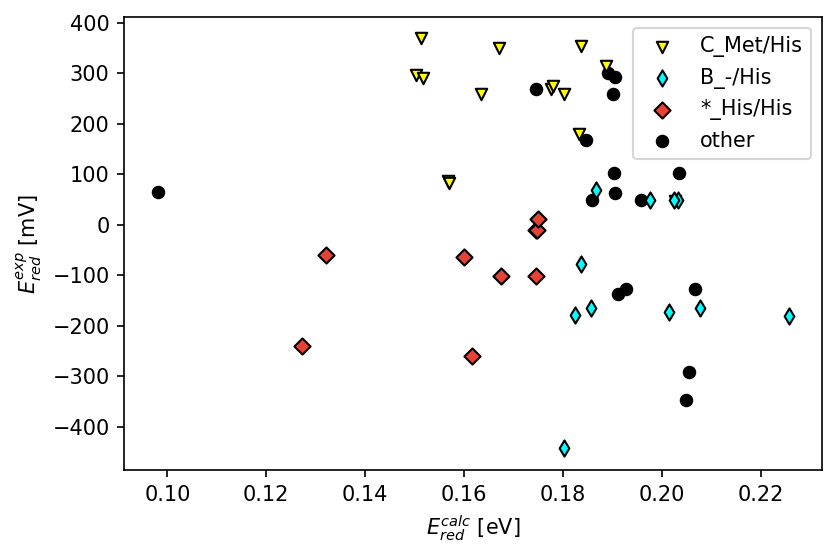

In [186]:
df  = df_work3.copy()
plt.figure(dpi=150)
plt.xlabel("edif_pred [eV]")
plt.xlabel(redox_calc)
plt.ylabel(redox)
scatterkat(df,"edif","Em_lit",Kategorie)
plt.legend()

plt.savefig(f"{plots}edif_pred_Em_lit.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


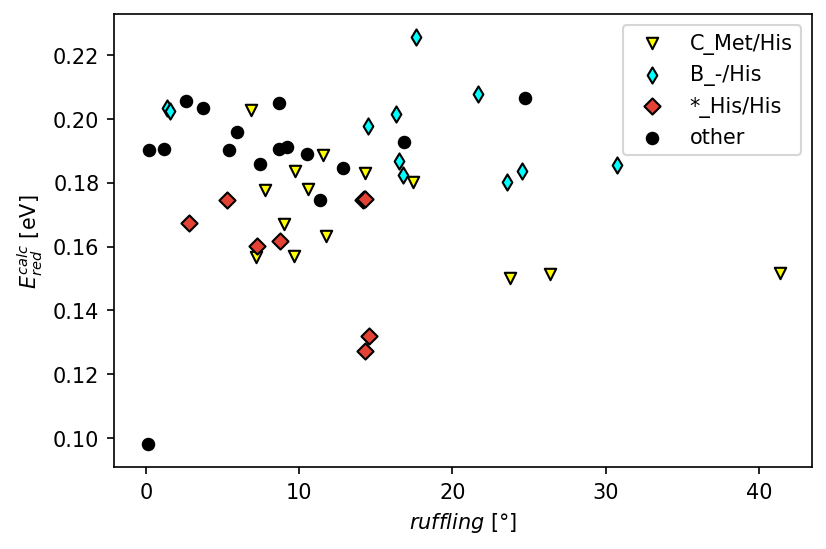

In [187]:
df  = df_work3.copy()

plt.figure(dpi=150)
plt.ylabel("edif_pred [eV]")
plt.xlabel(dihedruf)
plt.ylabel(redox_calc)
scatterkat(df,"ruffling","edif",Kategorie)

plt.legend()

plt.savefig(f"{plots}edif_pred_ruffling.png")

No handles with labels found to put in legend.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


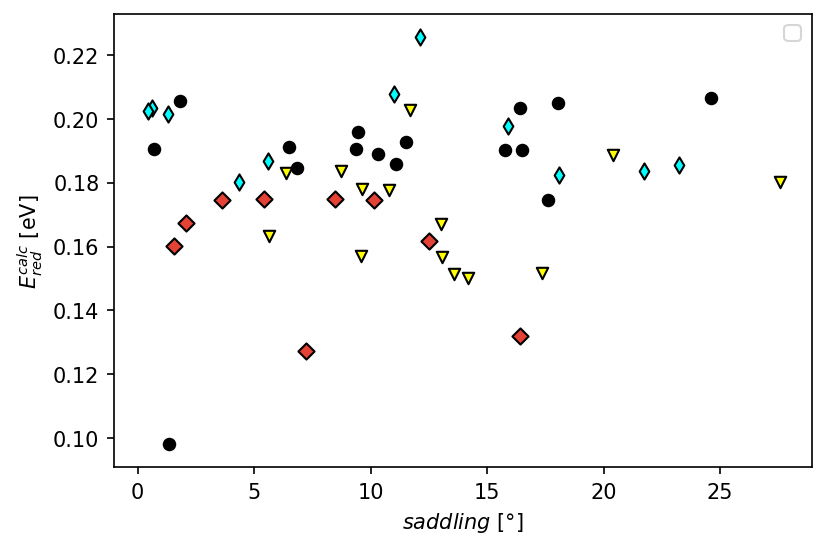

In [188]:
df  = df_work3.copy()

plt.figure(dpi=150)
plt.ylabel("edif_pred [eV]")
plt.ylabel(redox_calc)
plt.xlabel(dihedsad)
plt.legend()
scatterkat(df,"saddling","edif",Kategorie)
plt.savefig(f"{plots}edif_pred_saddling.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'edif_calc')

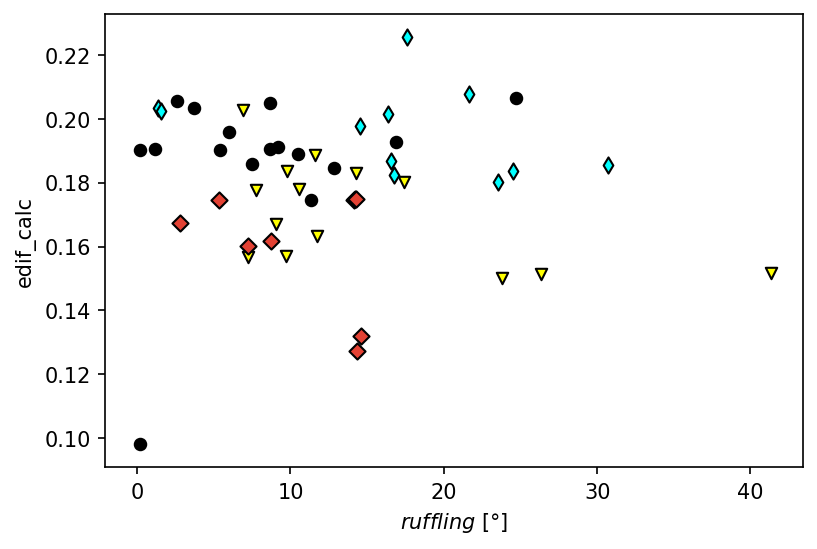

In [189]:
plt.figure(dpi=150)
scatterkat(df,"ruffling","edif",Kategorie)
plt.xlabel(dihedruf)
plt.ylabel("edif_calc")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'edif_calc')

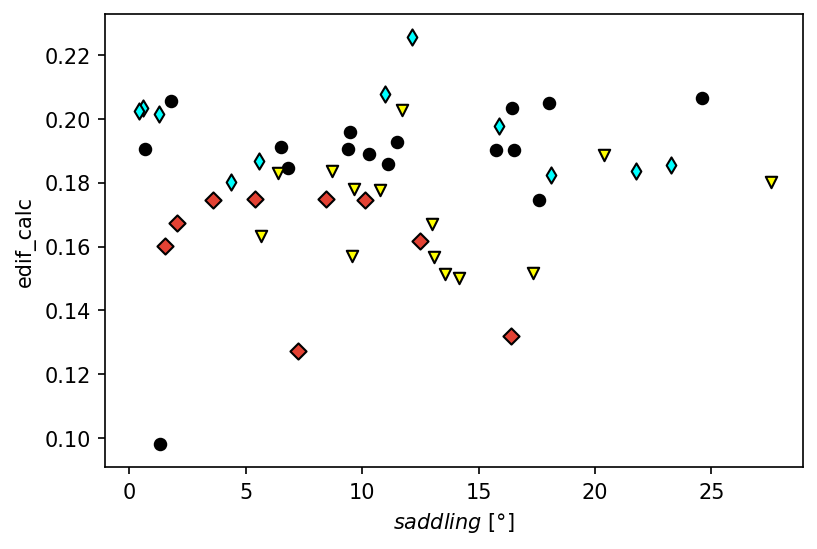

In [190]:
plt.figure(dpi=150)
scatterkat(df,"saddling","edif",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel("edif_calc")

In [191]:
redox_calc

'$E_{red}^{calc}$ [eV]'

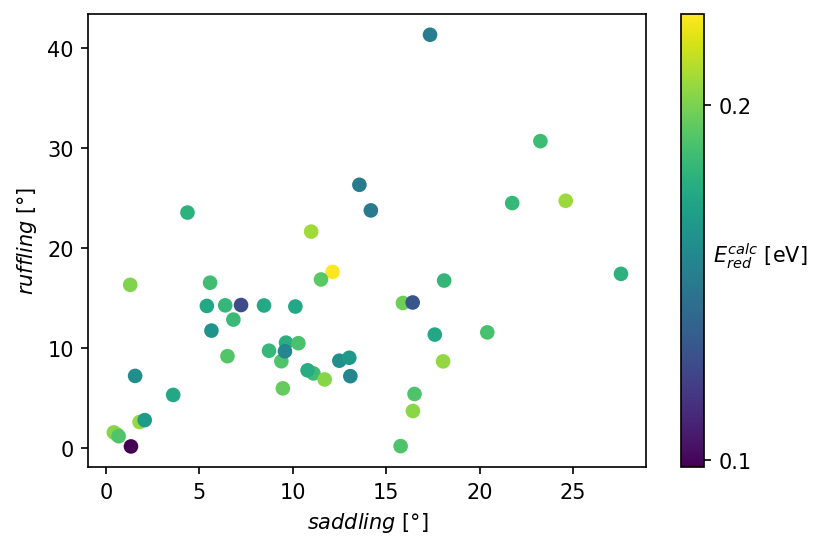

In [192]:
df = df_work3.copy()
fig = plt.figure(dpi=150)
plt.scatter(df["saddling"],df["ruffling"],c=df["edif"])
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)
cbar =plt.colorbar(ticks=[0.1,0.2])#
cbar.set_label(redox_calc, rotation=0)
fig.savefig(f"{plots}rufvsad_calc.png")

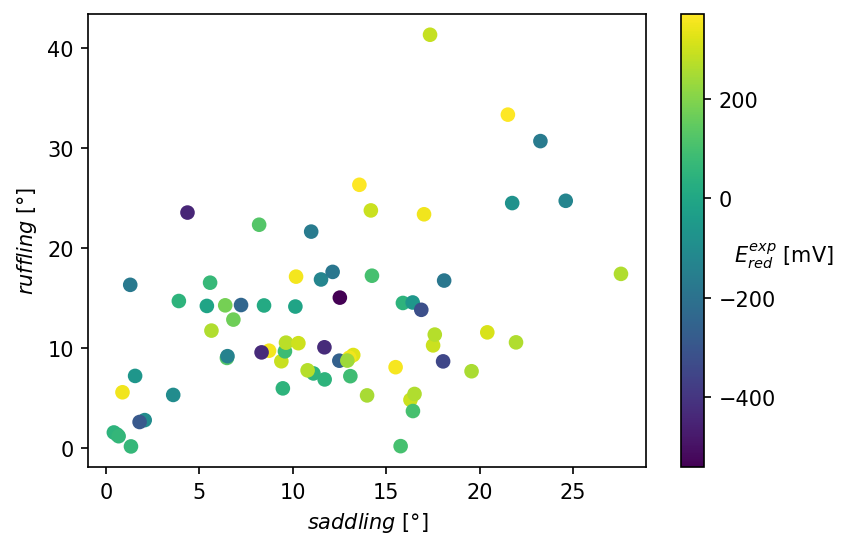

In [193]:
fig = plt.figure(dpi=150)
df=dflg
plt.scatter(df["saddling"],df["ruffling"],c=df["Em_lit"])
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)
cbar =plt.colorbar()#
cbar.set_label(redox, rotation=0)
fig.savefig(f"{plots}rufvsad_lit.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'edif-2-1')

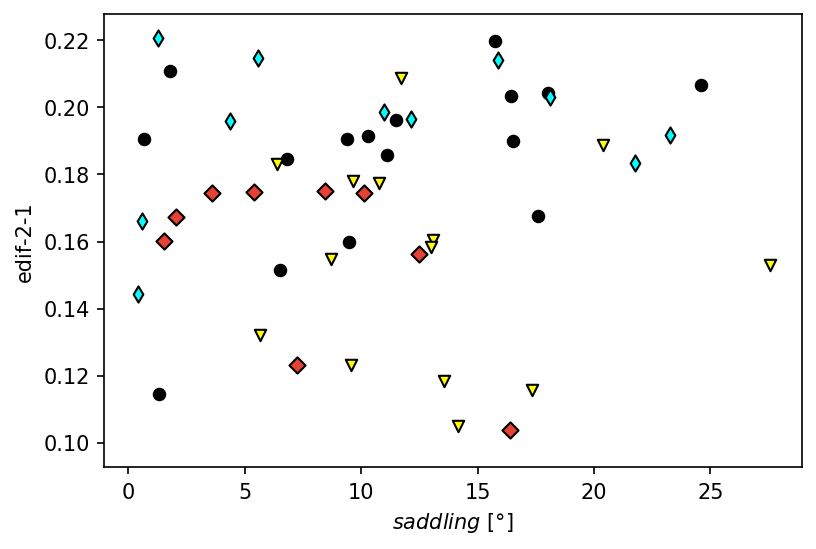

In [194]:
df=df_work2.copy()
plt.figure(dpi=150)
scatterkat(df,"saddling","edif-2-1",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel("edif-2-1")

# Diff

In [195]:
df_work3["homo_fe2"] = [np.array([h,l]).min() for h,l in zip(df["homo_1_nbo"],df["homo_5_nbo"])]
df_work3["homo_fe3"] = [np.array([h,l]).min() for h,l in zip(df["homo_2_nbo"],df["homo_6_nbo"])]
df_work3["lumo_fe2"] = [np.array([h,l]).min() for h,l in zip(df["lumo_1_nbo"],df["lumo_5_nbo"])]
df_work3["lumo_fe3"] = [np.array([h,l]).min() for h,l in zip(df["lumo_2_nbo"],df["lumo_6_nbo"])]
df_work3["diff_fe2"] = df_work3["lumo_fe2"]-df_work3["homo_fe2"]
df_work3["diff_fe3"] = df_work3["lumo_fe3"]-df_work3["homo_fe3"]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

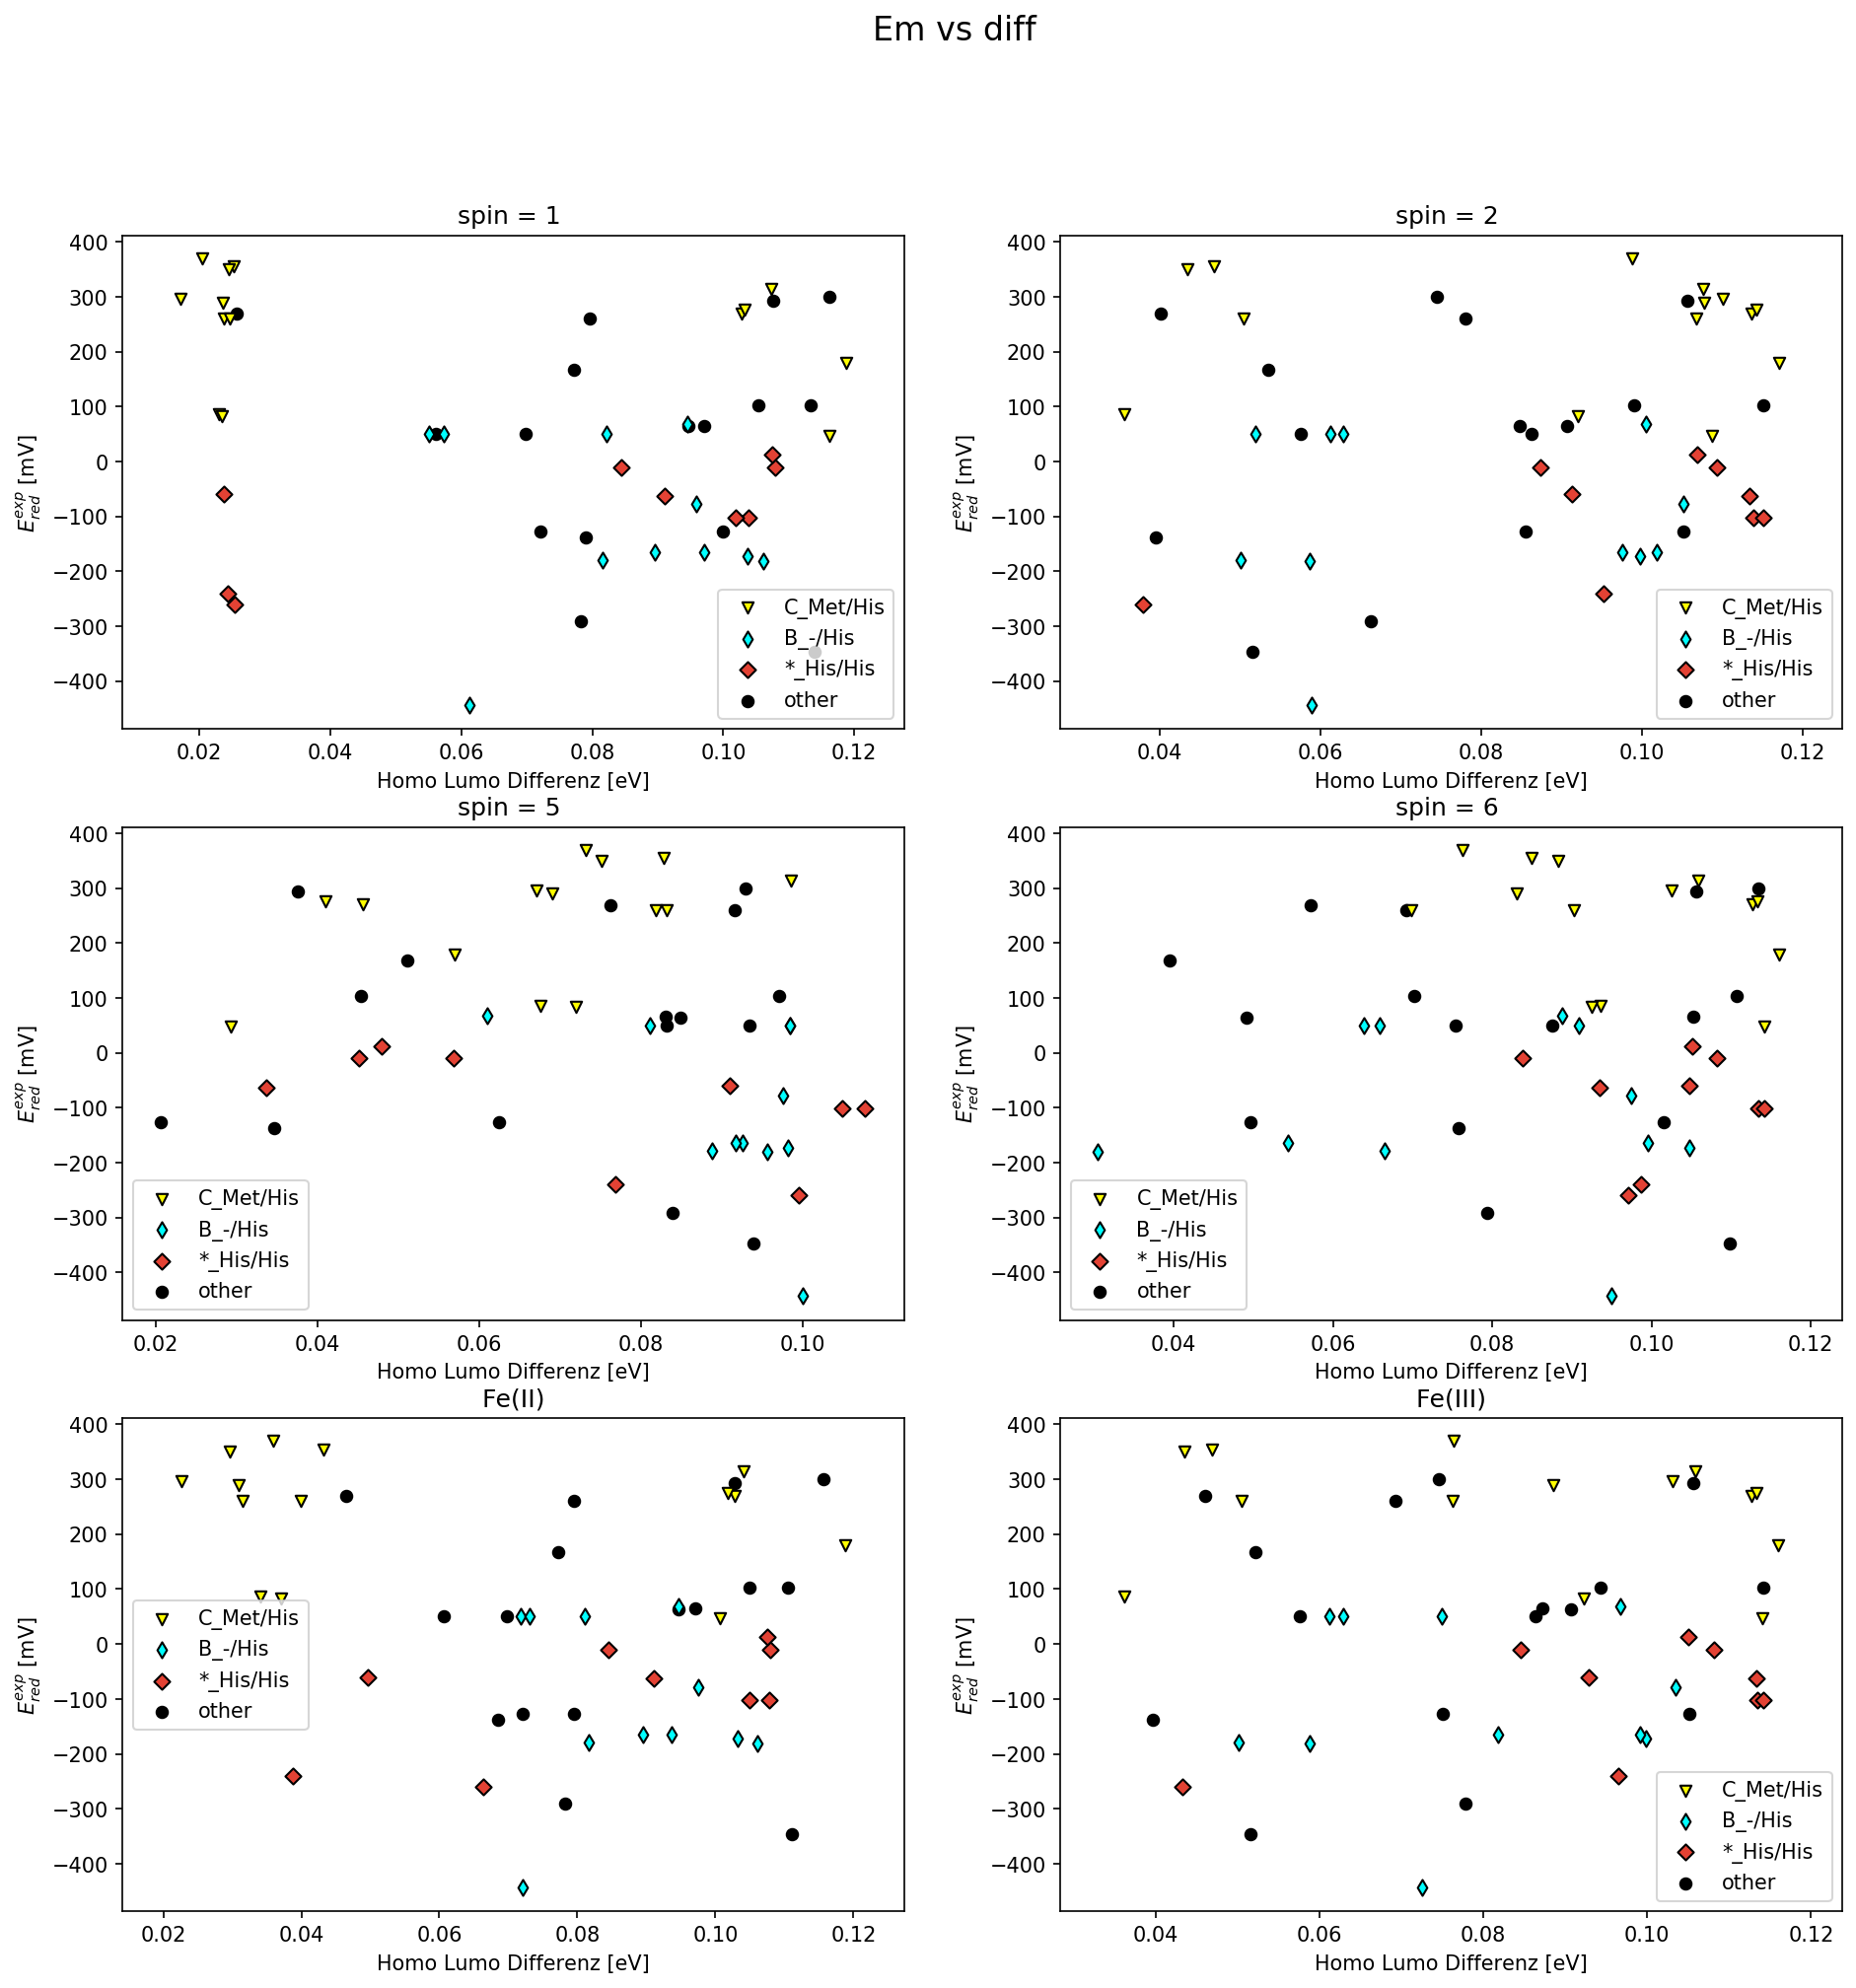

In [196]:
fig = plt.figure(dpi = 150,figsize=(15,15))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('Em vs diff', fontsize=16)
    plt.subplot(3,2,i)
    plt.title(f"spin = {s} ")
    plt.xlabel("Homo Lumo Differenz [eV]")
    plt.ylabel(redox)
    scatterkat(df_work2,f"diff_{str(s)}_nbo","Em_lit",Kategorie)
    plt.legend()
df = df_work3.copy()
#plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([5,6],["diff_fe2","diff_fe3"]):
    plt.subplot(3,2,a)
    scatterkat(df,b,"Em_lit",Kategorie)
    plt.title(f"Fe({'I'*(a-3)})")
    plt.xlabel("Homo Lumo Differenz [eV]")
    plt.ylabel(redox)   
    plt.legend()

fig.savefig(f"{plots}Em_diff.png")            

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

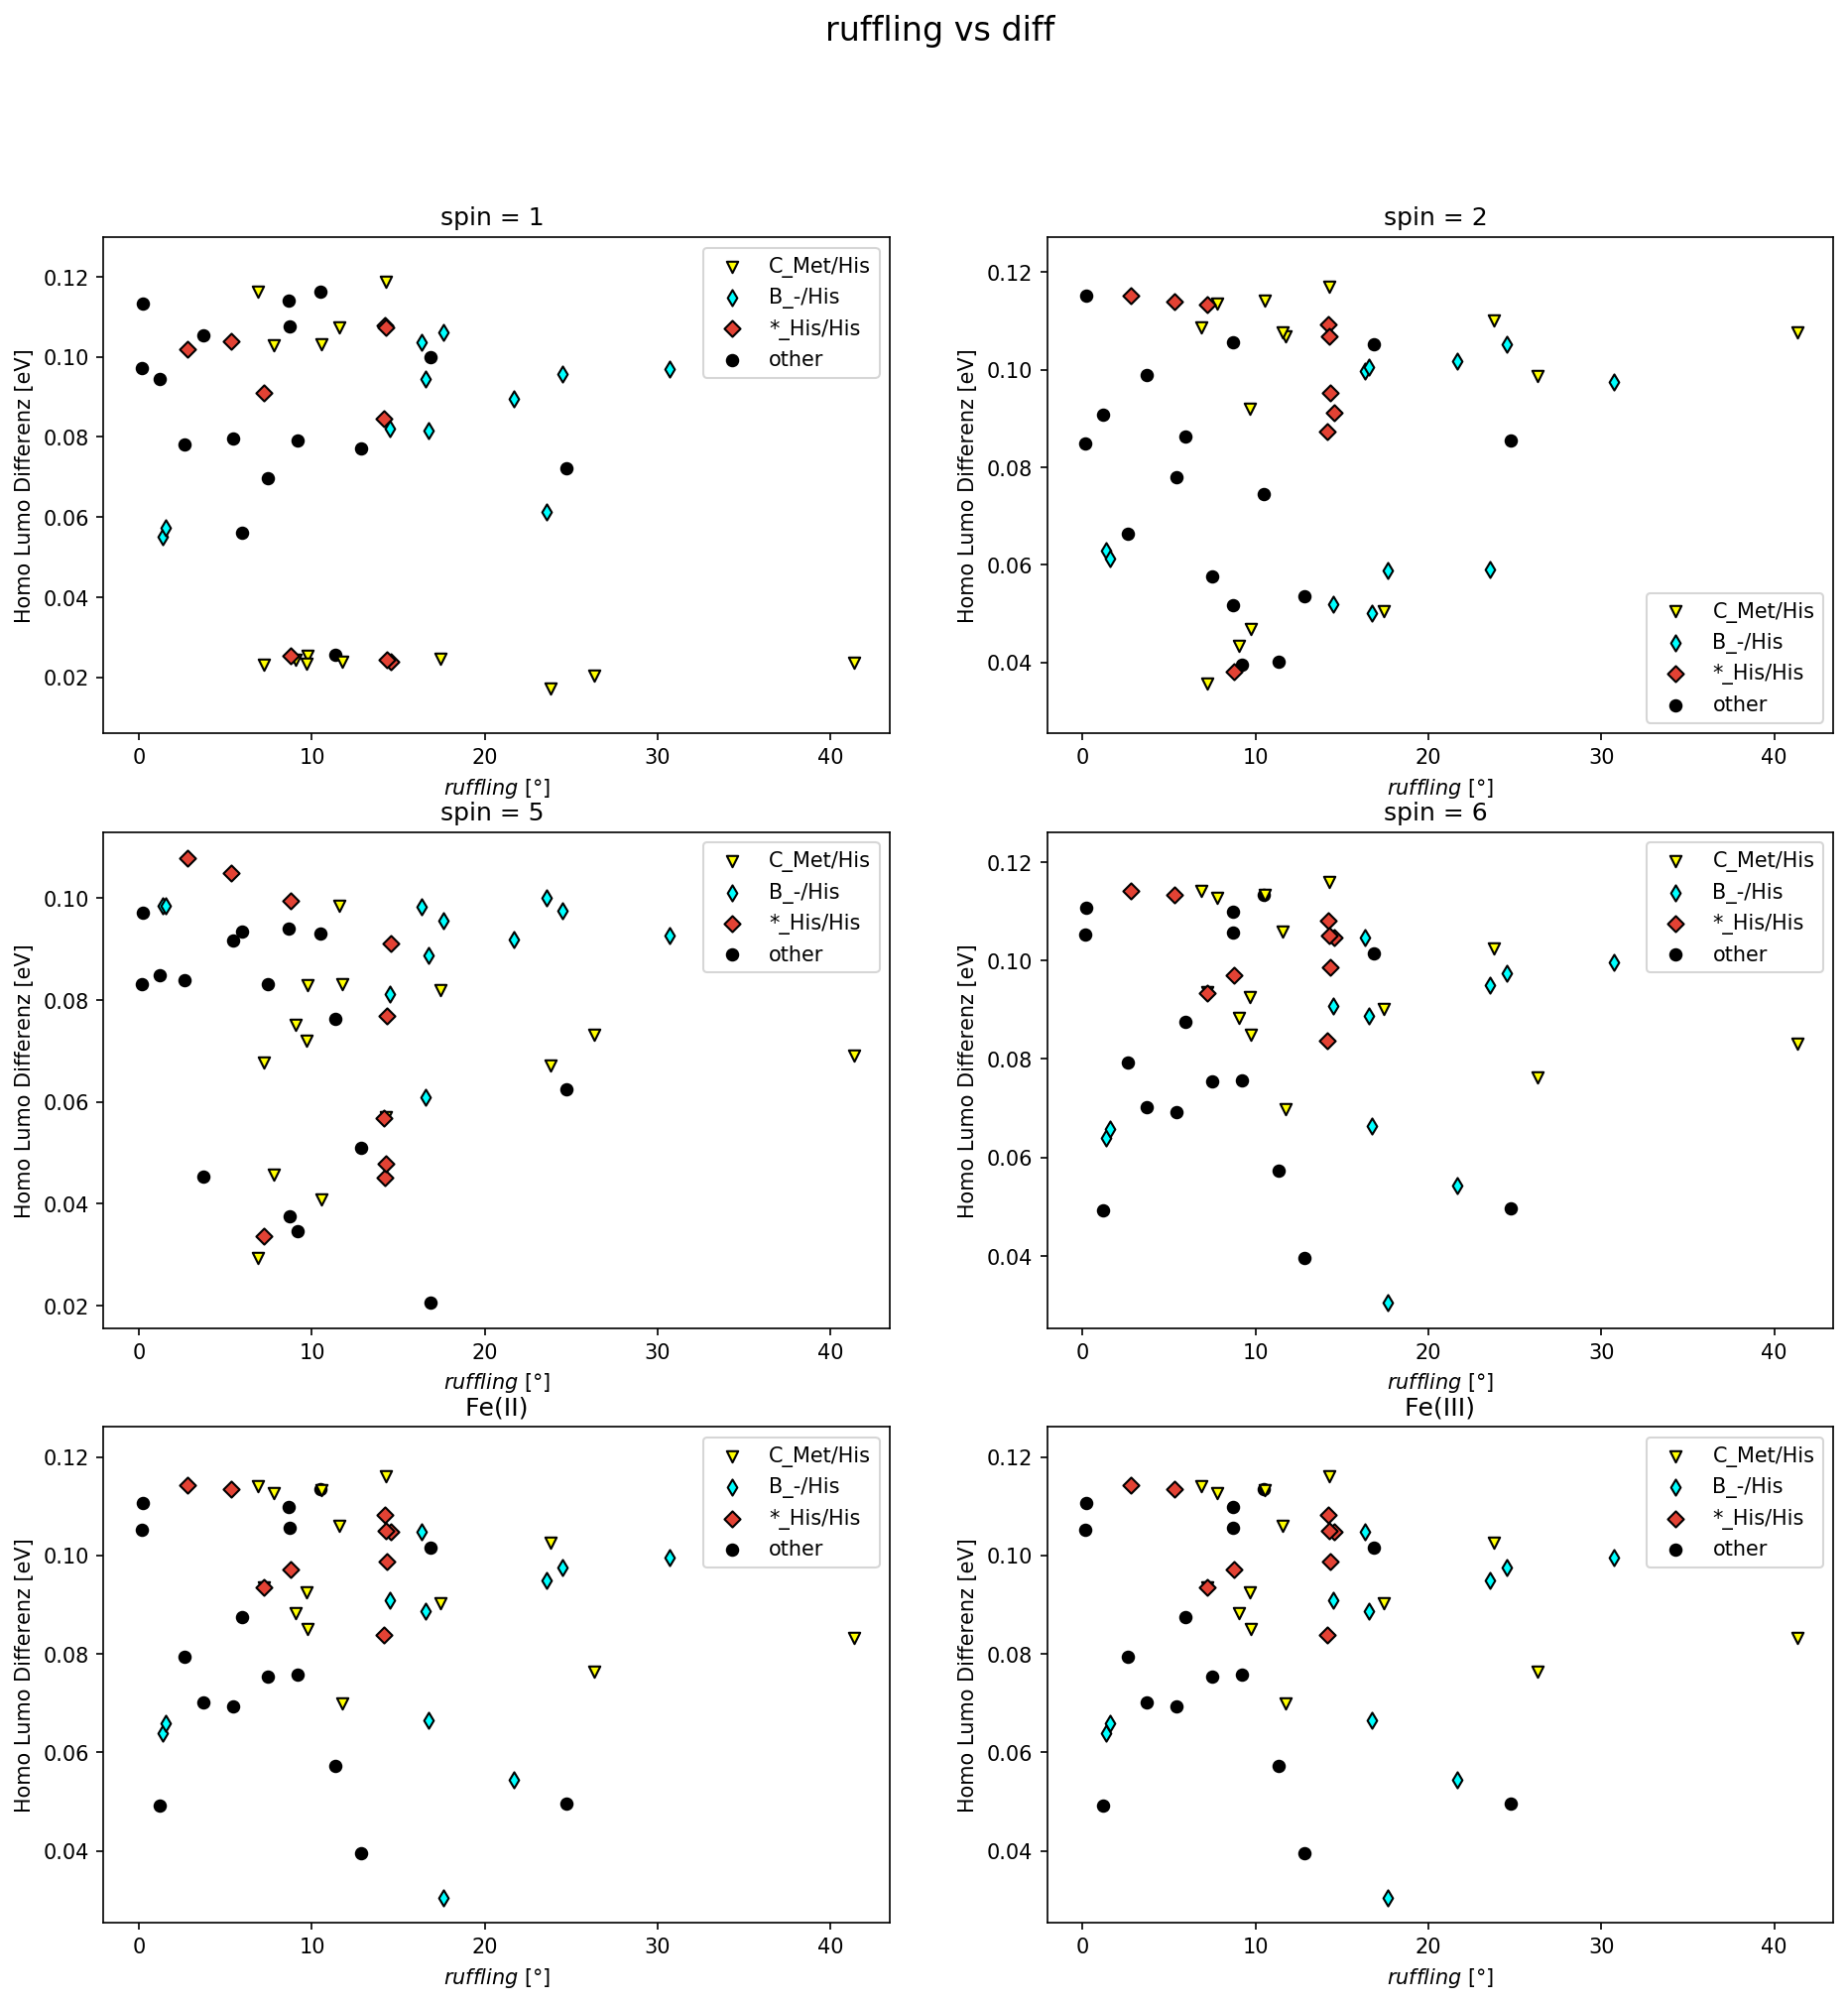

In [197]:
fig = plt.figure(dpi = 150,figsize=(15,15))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('ruffling vs diff', fontsize=16)
    plt.subplot(3,2,i)
    plt.title(f"spin = {s} ")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedruf)
    scatterkat(df_work2,"ruffling",f"diff_{str(s)}_nbo",Kategorie)
    plt.legend()
df = df_work3.copy()
#plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([5,6],["diff_fe2","diff_fe3"]):
    plt.subplot(3,2,a)
    scatterkat(df_work2,"ruffling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"Fe({'I'*(a-3)})")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedruf   )
    plt.legend()

fig.savefig(f"{plots}diff_saddling.png")            

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

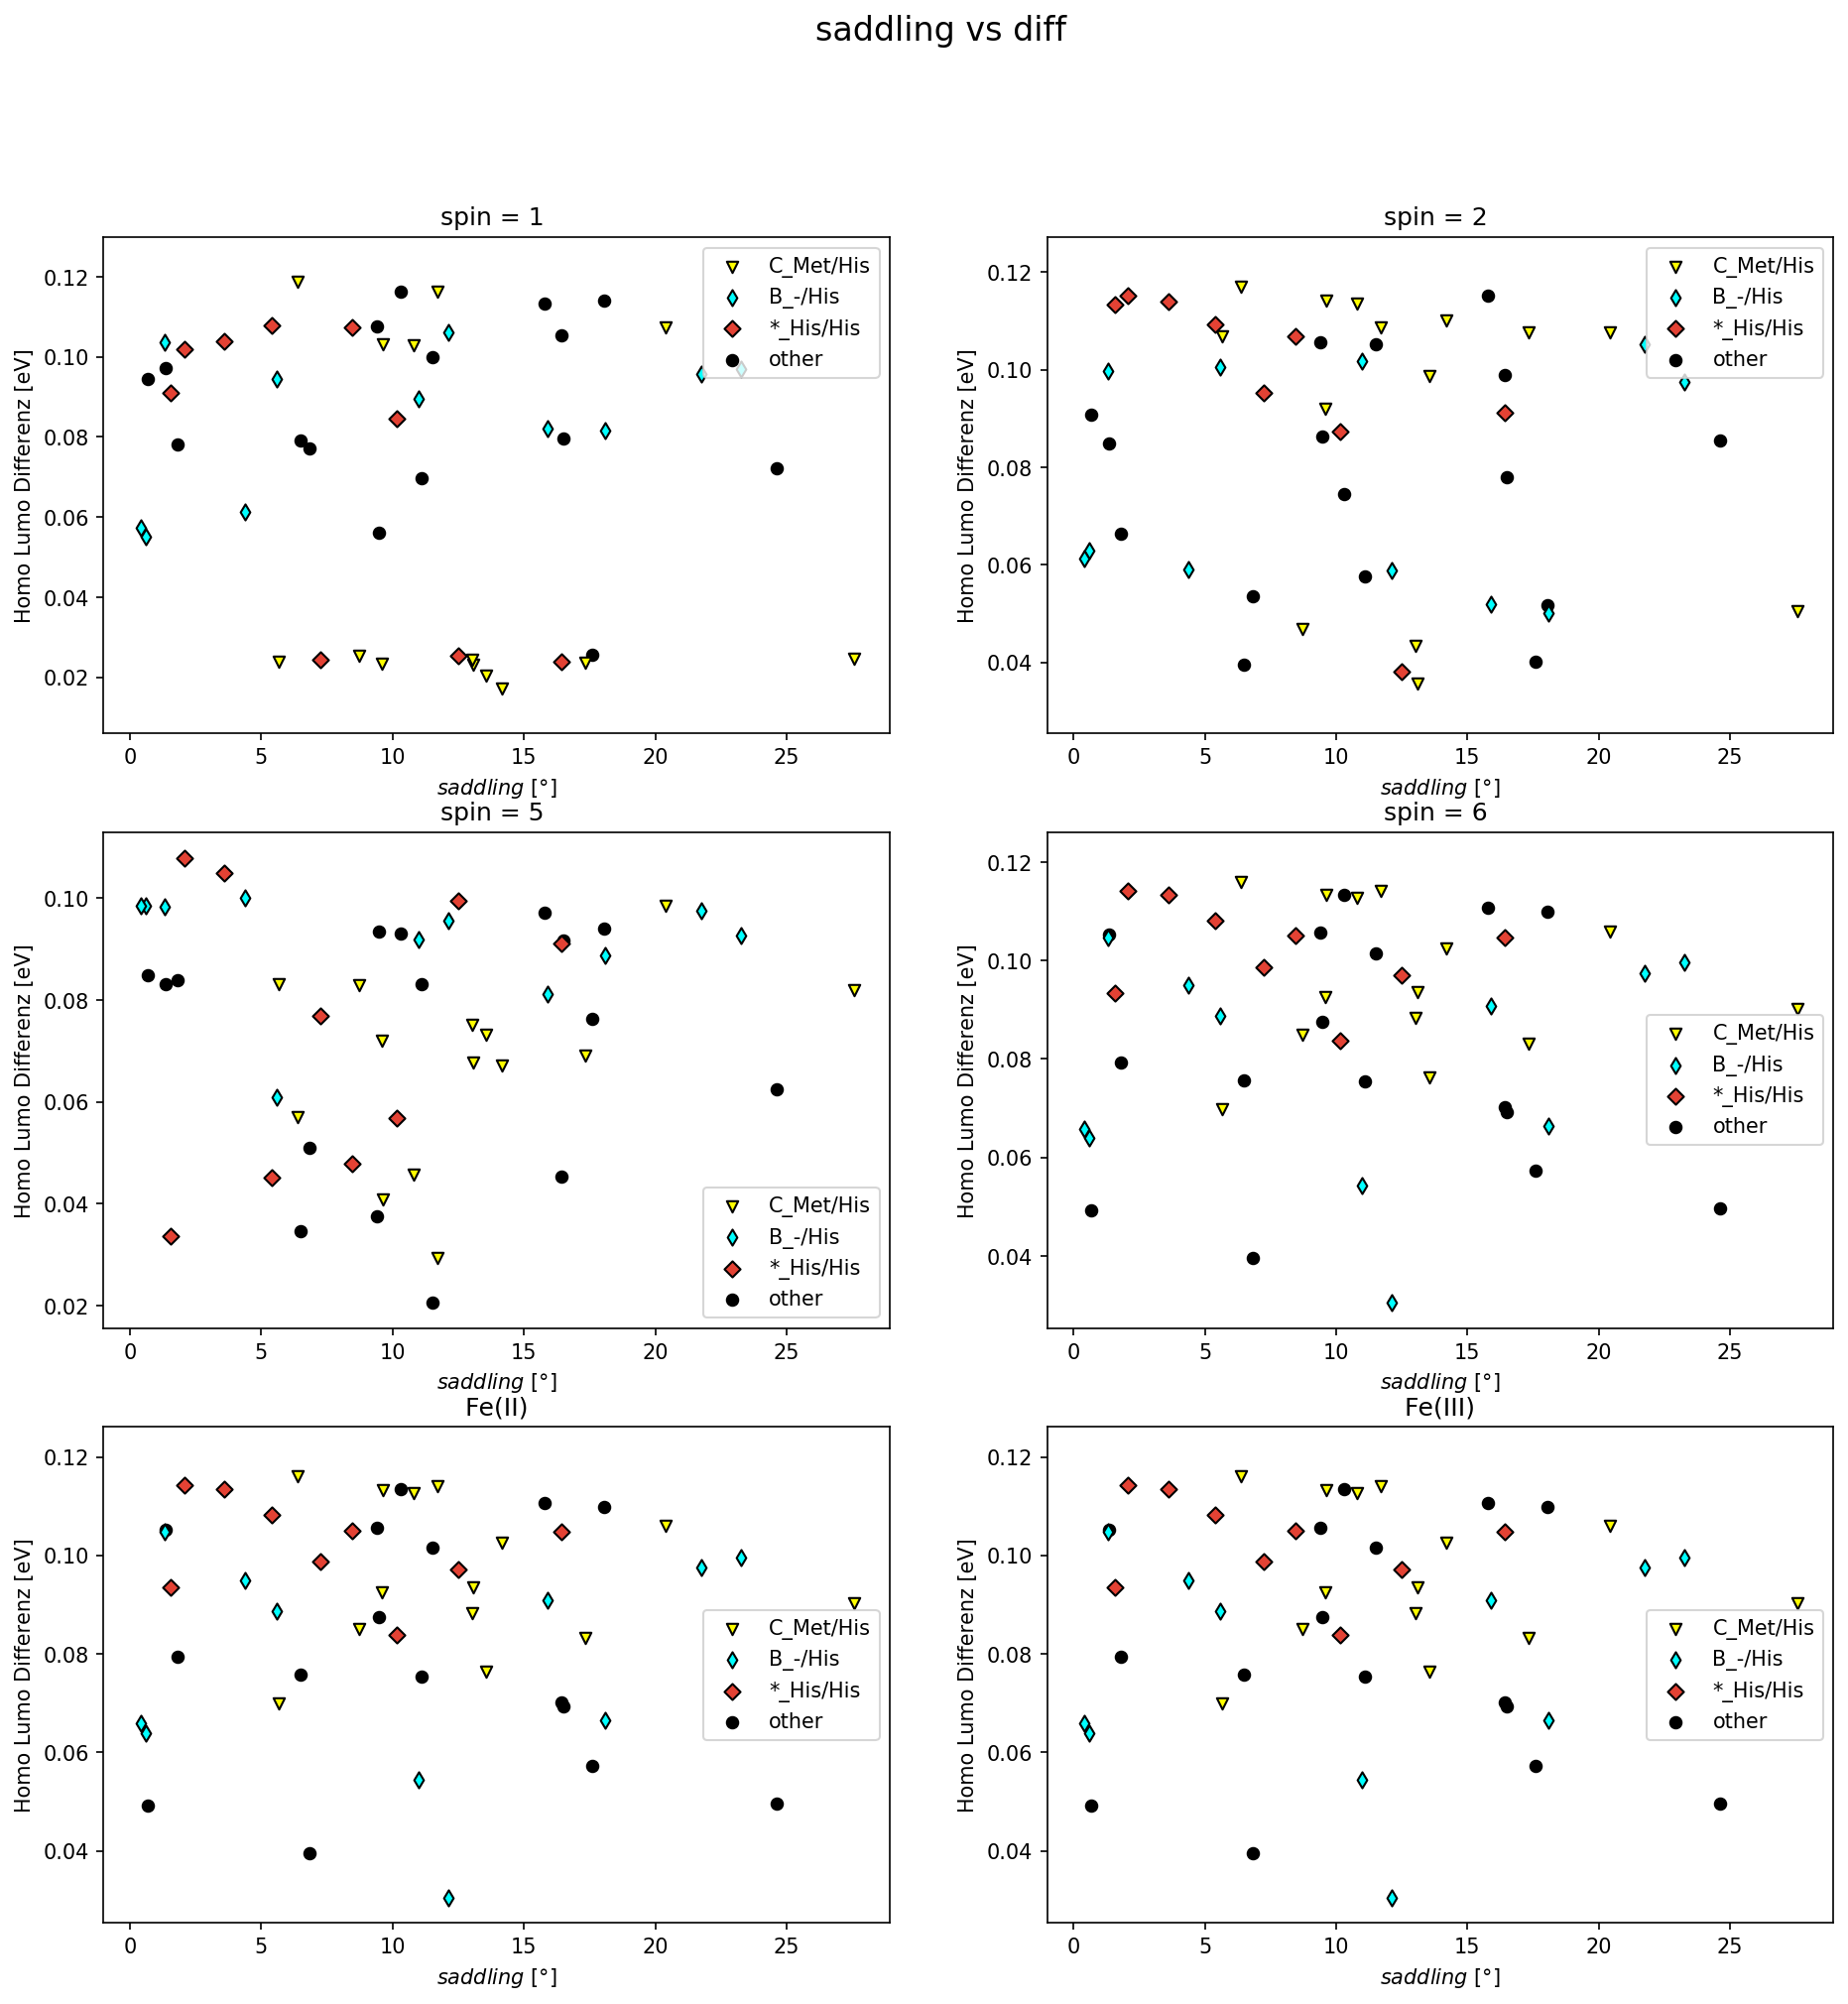

In [198]:
fig = plt.figure(dpi = 150,figsize=(15,15))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('saddling vs diff', fontsize=16)
    plt.subplot(3,2,i)
    plt.title(f"spin = {s} ")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedsad)
    scatterkat(df_work2,"saddling",f"diff_{str(s)}_nbo",Kategorie)
    plt.legend()
df = df_work3.copy()
#plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([5,6],["diff_fe2","diff_fe3"]):
    plt.subplot(3,2,a)
    scatterkat(df_work2,"saddling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"Fe({'I'*(a-3)})")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedsad   )
    plt.legend()

fig.savefig(f"{plots}diff_ruffling.png")            